## Projet P4 OC Data Scientist: Anticipez les besoins en consommation électrique de bâtiments

La ville de Seatle souhaite  atteindre son objectif de ville neutre en émissions de carbonne en 2050. Pour cela, elle souhaite dans un premier temps :

- Obtenir une prédiction des émissions de Co2 et de la consommation totale d'énergie des bâtiments pour lesquels elles n'ont pas été mesurées 

- Evaluer l’intérêt de "l'ENERGY STAR Score" pour la prédiction d’émissions

Ce deuxième notebook permet réaliser les diverses modélisations grâce à des approches linéaires et non-linéaires afin de prédire les émissions de CO2 et les consommations d'énergie des bâtiments.

Etapes du projet présentées dans ce notebook : 

1. Preprocessing
  - Encodage et standardisation
  - Préparation des jeux d'entrainement et de test
  
  
2. Modèle Baseline : Régression linéaire multivariée


3. Modèle linéaires : ElasticNet, Lasso, Ridge et SVR
  - Modèle ElasticNet
  - Modèle Lasso
  - Modèle Ridge
  - Modèle Support Vector Regression (SVR)
  
  
4. Modèle non-linéaires : GradientBoostingRegressor et RandomForestRegressor
  - Modèle RandomForestRegressor
  - Modèle GradientBostingRegressor
  
  
5. Sélection des meilleurs modèles
  - Modèle de prédiction des émissions de CO2
  - Modèle de prédiction des consommations d'énergie
  
6. Test des modèles sélectionnés
  - Prédiction des émissions de CO2
  - Prédiction des consommation d'énergie
  
  
7. Influence du score ENERGY STAR

Lien vers les consignes : https://openclassrooms.com/fr/projects/629/assignment

Lien vers les données 2015 : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Lien vers les données 2016:  https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2016-building-energy-benchmarking.csv

Lien vers score Star Energy : https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what

Lien vers la signification des colonnes (trouvé via recherche web) : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

## 1. Mise en place environnement et import des librairies

In [235]:
# Librairies communes pour la Data Science
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import xgboost as xg
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, RobustScaler,\
                                  MinMaxScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error,\
                            SCORERS, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

# Autres librairies
import os
import ast # Traitement des arbres de la grammaire de syntaxe abstraite Python
import math
import joblib
import pickle
import inspect
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 200)
#pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_colwidth', None)
# pd.options.display.max_rows = 4000
# pd.options.display.max_seq_items = 4000

# Versions des librairies
print("Version librairie pandas: " + pd.__version__)
print("Version librairie numpy: " + np.__version__)
print("Version librairie matplotlib: " + matplotlib.__version__)
print("Version librairie seaborn: " + sns.__version__)
print("Version librairie sklearn: " + sk.__version__)
print("Version librairie xgboost: " + xg.__version__)

Version librairie pandas: 1.1.3
Version librairie numpy: 1.19.2
Version librairie matplotlib: 3.3.2
Version librairie seaborn: 0.11.0
Version librairie sklearn: 0.24.2
Version librairie xgboost: 1.4.0


## 2. Fonctions

In [236]:
# Fonction pour la passage à l'échelle logarithmique des colonnes du dataset
def passage_log(df_in, funct, col=None, df_index=None):
    
    # Définition fonction FunctionTransformer
    logtransformer = FunctionTransformer(np.log1p, inverse_func = np.expm1, check_inverse = True)
    
    # Traitement X_train, X_test      
    if df_in.shape[1] > 1:
        var_quant = df_in.select_dtypes(include=['int32', 'int64', 'float64', 'uint8']).columns
        
        # Passage échelle logarithmique
        if funct == 'log':
            df_ret = logtransformer.transform(df_in)

        # Passage fonction inverse (exp)    
        elif funct == 'inverse':
            df_ret = logtransformer.inverse_transform(df_in[var_quant])
        
    # Traitement y_train, y_test    
    else:
        
        # Passage échelle logarithmique
        if funct == 'log':
            df = logtransformer.transform(df_in)
        
        # Passage fonction inverse (exp)
        if funct == 'inverse':
            df = logtransformer.inverse_transform(df_in)
        
        df = pd.DataFrame(df, columns=[col], index=df_index)
        df_ret = df.reindex(df_index)
        
    return df_ret

In [237]:
def fuite_donnees(df_in, liste_col):
    
    for col in liste_col:
        
        new_col = col[0:col.find("(")]
        
        df_in[new_col] = df_in[col].astype(bool)
        df_in[new_col] = df_in[new_col].astype(int)
        df_in.drop(col, axis=1, inplace=True)
 
    return df_in

In [238]:
# Fonction pour limiter les catégories des variables qualitatives
def categ_var_qual(df_in, col, nbre_max_modalite, display):
          
    counts = df_in[col].value_counts()
    if display == 'O':
        print('------ Variable ' + col + '------')
        print(str(counts))
    idx = counts[counts < nbre_max_modalite].index
    df_in.loc[df_in[col].isin(idx), col] = "Other"
        
    if display == 'O':
        print('')
        
    return df_in

In [239]:
# Fonction encodage OneHotEncoder
def encodage_OneHot(df_in, liste_col):

    ohe = OneHotEncoder(sparse=False)
    ohe.fit_transform(df_in[liste_col])
    
    df_temp = pd.DataFrame(columns = ohe.get_feature_names().tolist(),
                   data = ohe.fit_transform(df_in[liste_col]))
   
    return df_temp

In [240]:
# Fonction qui montre les variables fortement corrélées 
def corr_df(df_in, corr_val):
    
    #On supprime les targets du traitement
    
    nb_col = df_in.shape[1]
    
    df_in_temp = df_in.loc[:,["TotalGHGEmissions_CO2", "SiteEnergyUse(kBtu)"]]
    
    df_in.drop(["TotalGHGEmissions_CO2", "SiteEnergyUse(kBtu)"], axis=1, inplace=True)
    
    # Création de la matrice de corrélation et instanciation
    corr_matrix = df_in.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
    print("Liste des colonnes fortement corrélées:")

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                #print(col.values[i], "|", row.values[i], "|", round(val[i][i], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = df_in.iloc[:, (i+1):(i+2)].columns.values
        print(col)
        df_in = df_in.drop(col, axis=1)
    
    df_in = pd.concat([df_in,df_in_temp], axis=1)
    print(nb_col - df_in.shape[1], "colonnes fortement corrélées supprimées.")
    return df_in

In [241]:
# Fonction pour la création de la variable "AreaBuildings" (surface réelle d'un bâtiment)
def create_var_AreaBuildings(df_in):
    
    #On crée une variable nombre d'étages qui est le nombre de niveaux + le rez de chaussée
    df_in["Nb_etages"] = 1
    df_in["Nb_etages"] = df_in["NumberofFloors"] + df_in["Nb_etages"]
    
    #On calcule la surface réelle d'un bâtiment
    df_in["AreaBuildings"] = df_in["Nb_etage"] * df_in["PropertyGFABuildings"]
    
    #On supprime les colonnes inutiles à présent
    df_in.drop(["NumberofFloors","PropertyGFABuildings","Nb_etages"], axis=1, inplace=True)
    
    return df_in

In [242]:
# Fonction principale pour la création de nouvelles variables
def create_new_var(df_in):
    df_ret = create_var_AreaBuildings(df_in)
    return df_ret

In [243]:
# Fonction pour standardisation des données d'entraînement /test 
def standardisation_df(df_in):
    scaler = StandardScaler()
    df_in_std = scaler.fit_transform(df_in.values)
    df_in_std_df = pd.DataFrame(df_in_std, index=df_in.index, columns=df_in.columns)
    
    return df_in_std_df

In [244]:
# Fonction pour la suppression des outliers par la méthode des interquartiles
def supp_outliers(df_in, target):
    
    #Méthode de suppression des outliers par les interquartiles
    Q1 = df_in[target].quantile(0.25)
    Q3 = df_in[target].quantile(0.75)
    IQR = Q3 - Q1
    df_in = df_in[~((df_in[target] < (Q1 - 1.5 * IQR)) |(df_in[target] > (Q3 + 1.5 * IQR)))]
    print(df_in.shape)
 
    return df_in

In [245]:
# Fonction pour preprocessing traitement des données avant sélection des modèles
def pipeline_preprocessing(df_in, liste_col_enc_var_qual, target1, nom_log_target1, target2,
                           nom_log_target2, liste_col_ident_bat, liste_col_std):
    
    print('Jeu de données d\'origine - dimension = ' + str(df_in.shape))
    print('')
    
    # Hypothèse 4: Simplification du nombre de modalités pour les variables qualitatives 
    df_in = categ_var_qual(df_in, "BuildingType", 25, 'O')
    df_in = categ_var_qual(df_in, "PrimaryPropertyType", 114, 'O')
    df_in = categ_var_qual(df_in, "LargestPropertyUseType", 75, 'O')
    df_in = categ_var_qual(df_in, "SecondLargestPropertyUseType", 29, 'O')
    df_in = categ_var_qual(df_in, "ThirdLargestPropertyUseType", 32, 'O')
    
    print('Jeu de données - simplification modalités var qualitatives - dimension  = ' + str(df_in.shape))
    print('')
    
    # Hypothèse 4: Encodage OneHot variables qualitatives 
    df_bat_enc = encodage_OneHot(df_in, liste_col_enc_var_qual)
    
    # Concaténation avec le dataframe d'origine 
    df_bat_pp = pd.concat([df_in, df_bat_enc], axis=1)
    df_bat_pp.drop(columns=["BuildingType","LargestPropertyUseType","SecondLargestPropertyUseType",
                          "ThirdLargestPropertyUseType","PrimaryPropertyType"], inplace=True)
    
    print('Jeu de données - encodage OneHot var qualitatives - dimension  = ' + str(df_bat_pp.shape))
    print('')
    
    
    # Fuite de données sur les relevés
    liste_col_rel = ["Electricity(kBtu)","NaturalGas(kBtu)","SteamUse(kBtu)"]
    df_bat_pp = fuite_donnees(df_bat_pp, liste_col_rel)
    
    print('Jeu de données - encodage binaire relevés - dimension  = ' + str(df_bat_pp.shape))
    print('')
    
    # Hypothèse 2: Passage à l'échelle logarithmique - variable
    # Appel de la fonction pour la passage à l'échelle logarithmique - variable "SiteEnergyUse(kBtu)"
    df_var_predict_target1 = passage_log(np.array(df_bat_model_pp[target1]).reshape(-1, 1),
                                'log', nom_log_target1, df_bat_pp.index)
    
    print('Jeu de données - variable (échelle log) ' + target1 + ' - dimension  = ' 
          + str(df_var_predict_target1.shape))
    print('')
    
    # Concaténation avec la dataframe d'origine
    df_bat_pp = pd.concat([df_bat_pp, df_var_predict_target1], axis=1)
    
    print('Jeu de données complet - variable (échelle log) ' + target1 + ' - dimension  = ' 
          + str(df_bat_pp.shape))
    print('')
    
     # Appel de la fonction pour la passage à l'échelle logarithmique - variable "TotalGHGEmissions_CO2"
    df_var_predict_target2 = passage_log(np.array(df_bat_model_pp[target2]).reshape(-1, 1),
                                'log', nom_log_target2, df_bat_pp.index)
    
    print('Jeu de données - variable (échelle log) ' + target2 + ' - dimension  = ' 
          + str(df_var_predict_target2.shape))
    print('')
    
    # Concaténation avec la dataframe d'origine
    df_bat_pp = pd.concat([df_bat_pp, df_var_predict_target2], axis=1)
    
    print('Jeu de données complet - variable (échelle log) ' + target1 + ' - dimension  = ' 
          + str(df_bat_pp.shape))
    print('')
    
    # Hypothèse 3: Suppression des valeurs atypiques sur variables cible - méthode inter-quartile
    df_bat_pp_outlier = df_bat_pp.copy()
    
    # Appel fonction suppression des valeurs atypiques -variable "SiteEnergyUse(kBtu)"
    df_bat_pp_outlier_target1 = supp_outliers(df_bat_pp_outlier, target1)
    
    print('Jeu de données complet - variable (méthode inter-quartile) ' + target1 + ' - dimension  = ' 
          + str(df_bat_pp_outlier_target1.shape))
    print('')
    
    # Appel fonction suppression des valeurs atypiques "TotalGHGEmissions_CO2"
    df_bat_pp_outlier_target2 = supp_outliers(df_bat_pp_outlier, target2)
    
    print('Jeu de données complet - variable (méthode inter-quartile) ' + target2 + ' - dimension  = ' 
          + str(df_bat_pp_outlier_target2.shape))
    print('')
    
    # Hypothèse 1: Standardisation des données en entrée
    # Standardisation pour les données en entrée avec les valeurs atypiques
    # Valeurs à prédire - valeurs réelles
    y_reel_with_out = df_bat_pp[[target1, target2]]
    
    print('Jeu de données - Variables réelles à prédire avec valeurs atypiques  - dimension  = ' 
          + str(y_reel_with_out.shape))
    print('')
    
    # Valeurs à prédire - valeurs échelle logarithmique
    y_log_with_out = df_bat_pp[[nom_log_target1, nom_log_target2]]
    
    print('Jeu de données - Variables à prédire (échelle log) avec valeurs atypiques  - dimension  = ' 
          + str(y_log_with_out.shape))
    print('')
    
    # Valeurs de l'identification du bâtiment
    df_ident_bat_with_out = df_bat_pp[liste_col_ident_bat]
    
    print('Jeu de données - identification du bâtiment  - dimension  = ' 
          + str(df_ident_bat_with_out.shape))
    print('')

    # Valeurs X pour standardisation
    X = df_bat_pp[liste_col_std]
    
    # Appel fonction pour standardisation variables d'entrée avec outliers
    X_std_with_out = standardisation_df(X)
    
    print('Jeu de données - Variables entrée standardisées avec valeurs atypiques  - dimension  = ' 
          + str(X_std_with_out.shape))
    print('')
    
    # Standardisation pour les données en entrée sans les données atypiques
    # Valeurs à prédire - variable "SiteEnergyUse(kBtu)"
    y_reel_noout_target1 = df_bat_pp_outlier_target1[[target1]]
    
    # Valeurs à prédire - variable "SiteEnergyUse(kBtu)" échelle logarithmique
    y_log_noout_target1 = df_bat_pp_outlier_target1[[nom_log_target1]]
    
    # Concaténation des variables y
    y_noout_target1 = pd.concat([y_reel_noout_target1, y_log_noout_target1], axis=1)
    
    print('Jeu de données - Variables à prédire (échelle log) sans valeur atypique (target1)  - dimension  = ' 
          + str(y_noout_target1.shape))
    print('')
    
    # Valeurs à prédire - variable "TotalGHGEmissions_CO2"
    y_reel_noout_target2 = df_bat_pp_outlier_target2[[target2]]
    
    # Valeurs à prédire - variable "TotalGHGEmissions_CO2" échelle logarithmique
    y_log_noout_target2 = df_bat_pp_outlier_target2[[nom_log_target2]]
    
    # Concaténation des variables y
    y_noout_target2 = pd.concat([y_reel_noout_target2, y_log_noout_target2], axis=1)
    
    print('Jeu de données - Variables à prédire (échelle log) sans valeur atypique (target2)  - dimension  = ' 
          + str(y_noout_target2.shape))
    print('')
    
    # Valeurs identifiant le bâtiment - target 1
    df_ident_bat_noout_target1 = df_bat_pp_outlier_target1[liste_col_ident_bat]
    
    print('Jeu de données - identification du bâtiment (target1) sans valeur atypique - dimension  = ' 
          + str(df_ident_bat_noout_target1.shape))
    print('')
    
    # Valeurs identifiant le bâtiment - target 2
    df_ident_bat_noout_target2 = df_bat_pp_outlier_target2[liste_col_ident_bat]
    
    print('Jeu de données - identification du bâtiment (target2) sans valeur atypique  - dimension  = ' 
          + str(df_ident_bat_noout_target2.shape))
    print('')
    
    # Valeurs X pour standardisation - target 1
    X_noout_target1 = df_bat_pp_outlier_target1[liste_col_std]
    
     # Valeurs X pour standardisation - target 2
    X_noout_target2 = df_bat_pp_outlier_target2[liste_col_std]
    
    # Appel fonction pour standardisation variables d'entrée avec outliers -target1
    X_std_noout_target1 = standardisation_df(X_noout_target1)
    
    print('Jeu de données - Variables entrée standardisées sans valeur atypique (target1) - dimension  = ' 
          + str(X_std_noout_target1.shape))
    print('')
    
    # Appel fonction pour standardisation variables d'entrée avec outliers -target2
    X_std_noout_target2 = standardisation_df(X_noout_target2)
    
    print('Jeu de données - Variables entrée standardisées san valeurs atypique (target2) - dimension  = ' 
          + str(X_std_noout_target2.shape))
    print('')
    
    return (df_ident_bat_with_out, 
            X_std_with_out, 
            y_reel_with_out, 
            y_log_with_out, 
            df_ident_bat_noout_target1,
            df_ident_bat_noout_target2,
            X_std_noout_target1,
            X_std_noout_target2,
            y_noout_target1,
            y_noout_target2)

In [246]:
# Fonction pour afficher la liste des hyper-paramètres pour une liste de modèles
def model_list_hyperparam(list_models):
    
    for key, value in list_models.items():
        print('Liste des hyper-paramètres (avec les valeurs par défaut) pour le modèle: ' + key)
        print('--------------------------------------------------')
        hyper_param = value.get_params()
        print(hyper_param)
        print('')

    return None

In [247]:
def optim_hyperparam_model(X_train, X_test, y_train, y_test, model, param_grid, model_txt, log, target, 
               hyp_num, nb_fold):
    
    # Création tableau des résultats réglages hyper-paramètres pour le modèle
    df_tab_hyperparam = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli", "Liste hyper-paramètres"])

    print('Optimisation des hyper-paramètres pour la variable cible ' + target)
    print('---------------------------------------------------------------------------------')
    print('')
    
    model_grid = GridSearchCV(estimator = model, 
                      param_grid = param_grid,
                      scoring = 'neg_root_mean_squared_error',
                      cv=nb_fold,
                      verbose=1,
                      n_jobs=-1,
                      refit=True,
                      return_train_score=True        
                     )
    # Entraînement du modèle
    model_grid.fit(X_train, y_train.values.ravel())

    print("Optimal hyperparameter combination: ", model_grid.best_params_)
    print("Best score (RMSE): ", -model_grid.best_score_)
    
    # Sauvegarde des hyper-paramètres optimisés
    joblib.dump(model_grid.best_params_,
                './input/'+model_txt+'_'+target+'_'+'hyph'+str(hyp_num)+'_'+'optim_params.pkl')
    
    
    # Remplissage du tableau des optimisations des hyper-paramètres 
    df_tab_hyperparam = df_tab_hyperparam.append(dict(zip(df_tab_hyperparam.columns,
                                                          [model_txt, target, nb_fold,
                                                           model_grid.best_params_])),
                                                           ignore_index=True)

    return df_tab_hyperparam

In [248]:
# Fonction pour la prédiction des valeurs cible
def predict_model(X_train, y_train, X_test, y_test, model, model_txt, hyph_id, fic_hyperparam, target, log):
    
    # Chargement du fichier des hyper-paramètres
    loaded_hyp_param = joblib.load(fic_hyperparam)
    print('-----------------------------------------------------------------------------')
    print('Entraînement du modèle sur les hyper-paramètres optimisés: ' + model_txt)
    print('-----------------------------------------------------------------------------')
    print('Chargement du fichier des hyper-paramètres: ' + fic_hyperparam) 
    print('Hyper-paramètres optimisés: ' + str(loaded_hyp_param))
    
    # Entraînement du modèle
    model.set_params(**loaded_hyp_param)
    print('Prédictions avec les paramètres suivants du modèle:')
    print(model.get_params())
    print('')
    
    model.fit(X_train,y_train.values.ravel())
   
    # Prédictions sur le train et test set
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)  

    
    # Détermination du coefficient de détermination R²
    r2_test = np.round(r2_score(y_test, y_pred),2)
    r2_train = np.round(r2_score(y_train, y_pred_train),2)
    
    # si échelle logarithmique, passage à la fonction inverse (exp)
    if log == 'O':
        y_train = passage_log(np.array(y_train).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_train.index)
        y_test =  passage_log(np.array(y_test).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_test.index)
        y_pred = passage_log(np.array(y_pred).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_test.index)
        y_pred_train = passage_log(np.array(y_pred_train).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_train.index)

    # Détermination de la RMSE
    rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)
    
    # Détermination de la MAPE
    mape_test = np.round(mean_absolute_percentage_error(y_test, y_pred),2)
    mape_train = np.round(mean_absolute_percentage_error(y_train, y_pred_train),2)

    print('----------------------------------------------------------------------------------------')
    print('Calcul des prédictions pour le modèle ' + model_txt + ' sur le jeu de données train') 
    print('----------------------------------------------------------------------------------------')
    print("Train R2: ", r2_train)
    print("Train RMSE: ", rmse_train)
    print("Train MAPE: ", mape_train)
    print('')
     
    print('----------------------------------------------------------------------------------------')
    print('Calcul des prédictions pour le modèle ' + model_txt + ' sur le jeu de données test') 
    print('----------------------------------------------------------------------------------------')       
    print("Test R2: ", r2_test)
    print("Test RMSE: ", rmse_test)
    print("Test MAPE: ", mape_test)
    print('')    
    
    # Création du tableau de synthèse des erreurs de prédiction - train set
    df_results_error_train = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"], index=X_train.index)
    
    # Création du tableau de synthèse des erreurs de prédiction - test set
    df_results_error_test = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"], index=X_test.index)
    
    # Création du tableau de synthèse des indicateurs de performance du modèle - train set
    df_results_perf_train = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])
    
    # Création du tableau de synthèse des indicateurs de performance du modèle - test set
    df_results_perf_test = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])
    
    # Remplissage du tableau des erreurs de prédiction pour le train/test
    df_results_error_train['Modeles'] = model_txt
    df_results_error_test['Modeles'] = model_txt
    df_results_error_train['Hypothese_id'] = hyph_id
    df_results_error_test['Hypothese_id'] = hyph_id
    df_results_error_train['Target'] = target
    df_results_error_test['Target'] = target
    df_results_error_train['Dataset'] = 'Train'
    df_results_error_test['Dataset'] = 'Test'
    df_results_error_train['y'] = y_train
    df_results_error_test['y'] = y_test
    df_results_error_train['y_pred'] = y_pred_train
    df_results_error_test['y_pred'] = y_pred
    df_results_error_train['abs(y-y_pred)'] = abs(df_results_error_train['y']-df_results_error_train['y_pred'])
    df_results_error_test['abs(y-y_pred)'] = abs(df_results_error_test['y']-df_results_error_test['y_pred'])
    df_results_error_train['%error'] = round(df_results_error_train['abs(y-y_pred)']/df_results_error_train['y']*100,2)
    df_results_error_test['%error'] = round(df_results_error_test['abs(y-y_pred)']/df_results_error_test['y']*100,2)
    
    # Remplissage du tableau des métriques de performance pour le train
    df_results_perf_train = df_results_perf_train.append(dict(zip(df_results_perf_train.columns,
                                                                  [model_txt, 
                                                                   hyph_id,
                                                                   target,
                                                                   'Train', 
                                                                   r2_train, 
                                                                   rmse_train, 
                                                                   mape_train])),ignore_index=True)
    
    # Remplissage du tableau des métriques de performance pour le test
    df_results_perf_test = df_results_perf_test.append(dict(zip(df_results_perf_test.columns,
                                                                  [model_txt, 
                                                                   hyph_id,
                                                                   target,
                                                                   'Test', 
                                                                   r2_test, 
                                                                   rmse_test, 
                                                                   mape_test])),ignore_index=True)
                
    #return df_results_error, df_results_perf
    return (df_results_error_train, df_results_error_test, df_results_perf_train, df_results_perf_test) 

In [249]:
# Fonction pour la prédiction des valeurs cible - Feature importance
def predict_model_fi(X_train, y_train, X_test, y_test, model, model_txt, hyph_id, fic_hyperparam, target, log):
    
    perm_imp = '' 
    imp = ''
    

    # Chargement du fichier des hyper-paramètres
    loaded_hyp_param = joblib.load(fic_hyperparam)
    print('-----------------------------------------------------------------------------')
    print('Entraînement du modèle sur les hyper-paramètres optimisés: ' + model_txt)
    print('-----------------------------------------------------------------------------')
    print('Chargement du fichier des hyper-paramètres: ' + fic_hyperparam) 
    print('Hyper-paramètres optimisés: ' + str(loaded_hyp_param))
    
    # Entraînement du modèle
    model.set_params(**loaded_hyp_param)
    print('Prédictions avec les paramètres suivants du modèle:')
    print(model.get_params())
    print('')
    
    model.fit(X_train,y_train.values.ravel())
   
    # Prédictions sur le train et test set
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)  
    
    if model_txt in ('RandomForestRegressor', 'GradientBoostingRegressor', 'XGBoostRegressor') :
        # Features importance
        imp = model.feature_importances_
        
        #Permutation importance
        perm_imp = permutation_importance(model, X_test, y_test, scoring='neg_root_mean_squared_error', 
                                          n_repeats=10) 
    
    
    # Détermination du coefficient de détermination R²
    r2_test = np.round(r2_score(y_test, y_pred),2)
    r2_train = np.round(r2_score(y_train, y_pred_train),2)
    
    # si échelle logarithmique, passage à la fonction inverse (exp)
    if log == 'O':
        y_train = passage_log(np.array(y_train).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_train.index)
        y_test =  passage_log(np.array(y_test).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_test.index)
        y_pred = passage_log(np.array(y_pred).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_test.index)
        y_pred_train = passage_log(np.array(y_pred_train).reshape(-1, 1), 'inverse', "SiteEnergyUse(kBtu)", X_train.index)

    # Détermination de la RMSE
    rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)
    
    # Détermination de la MAPE
    mape_test = np.round(mean_absolute_percentage_error(y_test, y_pred),2)
    mape_train = np.round(mean_absolute_percentage_error(y_train, y_pred_train),2)

    print('----------------------------------------------------------------------------------------')
    print('Calcul des prédictions pour le modèle ' + model_txt + ' sur le jeu de données train') 
    print('----------------------------------------------------------------------------------------')
    print("Train R2: ", r2_train)
    print("Train RMSE: ", rmse_train)
    print("Train MAPE: ", mape_train)
    print('')
     
    print('----------------------------------------------------------------------------------------')
    print('Calcul des prédictions pour le modèle ' + model_txt + ' sur le jeu de données test') 
    print('----------------------------------------------------------------------------------------')       
    print("Test R2: ", r2_test)
    print("Test RMSE: ", rmse_test)
    print("Test MAPE: ", mape_test)
    print('')    
    
    # Création du tableau de synthèse des erreurs de prédiction - train set
    df_results_error_train = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"], index=X_train.index)
    
    # Création du tableau de synthèse des erreurs de prédiction - test set
    df_results_error_test = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"], index=X_test.index)
    
    # Création du tableau de synthèse des indicateurs de performance du modèle - train set
    df_results_perf_train = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])
    
    # Création du tableau de synthèse des indicateurs de performance du modèle - test set
    df_results_perf_test = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])
    
    # Remplissage du tableau des erreurs de prédiction pour le train/test
    df_results_error_train['Modeles'] = model_txt
    df_results_error_test['Modeles'] = model_txt
    df_results_error_train['Hypothese_id'] = hyph_id
    df_results_error_test['Hypothese_id'] = hyph_id
    df_results_error_train['Target'] = target
    df_results_error_test['Target'] = target
    df_results_error_train['Dataset'] = 'Train'
    df_results_error_test['Dataset'] = 'Test'
    df_results_error_train['y'] = y_train
    df_results_error_test['y'] = y_test
    df_results_error_train['y_pred'] = y_pred_train
    df_results_error_test['y_pred'] = y_pred
    df_results_error_train['abs(y-y_pred)'] = abs(df_results_error_train['y']-df_results_error_train['y_pred'])
    df_results_error_test['abs(y-y_pred)'] = abs(df_results_error_test['y']-df_results_error_test['y_pred'])
    df_results_error_train['%error'] = round(df_results_error_train['abs(y-y_pred)']/df_results_error_train['y']*100,2)
    df_results_error_test['%error'] = round(df_results_error_test['abs(y-y_pred)']/df_results_error_test['y']*100,2)
    
    # Remplissage du tableau des métriques de performance pour le train
    df_results_perf_train = df_results_perf_train.append(dict(zip(df_results_perf_train.columns,
                                                                  [model_txt, 
                                                                   hyph_id,
                                                                   target,
                                                                   'Train', 
                                                                   r2_train, 
                                                                   rmse_train, 
                                                                   mape_train])),ignore_index=True)
    
    # Remplissage du tableau des métriques de performance pour le test
    df_results_perf_test = df_results_perf_test.append(dict(zip(df_results_perf_test.columns,
                                                                  [model_txt, 
                                                                   hyph_id,
                                                                   target,
                                                                   'Test', 
                                                                   r2_test, 
                                                                   rmse_test, 
                                                                   mape_test])),ignore_index=True)
                
    #return df_results_error, df_results_perf
    return (df_results_error_train, df_results_error_test, df_results_perf_train, df_results_perf_test,
            perm_imp, imp) 

In [250]:
# Fonction affichage résultats globaux par modèle
def affic_results_glob_model(df_in_train, df_in_test, metric):
    labels = df_in_train["Modeles"].unique()
    
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(25,12))
    rects1 = ax.bar(x - width, df_in_train[metric], width, label=metric + ' train')
    rects2 = ax.bar(x, df_in_test[metric], width, label=metric + ' test')
   
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', size=16)
    ax.set_title('Résultats globaux par modèle', size=18)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0, fontsize=18)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    

    fig.tight_layout()

    plt.show()
    
    return None

In [662]:
# Fonction affichage résultats globaux par modèle
def affic_results_glob_model_2(df_in_train, df_in_test, metric):
    labels = df_in_train["Modeles"].unique()
    
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,8))
    rects1 = ax.bar(x - width, df_in_train[metric], width, label=metric + ' train')
    rects2 = ax.bar(x, df_in_test[metric], width, label=metric + ' test')
   
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', size=16)
    ax.set_title('Résultats globaux par modèle', size=18)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0, fontsize=18, horizontalalignment='right')
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    

    #fig.tight_layout()

    plt.show()
    
    return None

In [251]:
# Fonction affichage plot valeurs réelles /prédite pour un modèle
def affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target):
    fig,ax = plt.subplots(1,2,figsize=(14,7))
    ax[0].scatter(train_values, train_pred_values)
    ax[0].plot([train_values.min(), train_values.max()], [train_values.min(), train_values.max()], 'k--', lw=4)
    ax[0].set_xlabel('Valeurs réelles')
    ax[0].set_ylabel('Valeurs prédites')
    ax[0].set_title('Train set ' + target)

    ax[1].scatter(test_values, test_pred_values)
    ax[1].plot([test_values['y'].min(), test_values['y'].max()], [test_values['y'].min(), test_values['y'].max()],
           'k--', lw=4)
    ax[1].set_xlabel('Valeurs réelles')
    ax[1].set_ylabel('Valeurs prédites')
    ax[1].set_title('Test set ' + target)

    plt.show()
    
    return None

In [252]:
# Affichage des features importance / permutation importances
def affic_features_impotance_model(importance, perm_importance, X_test):

    # Affichage Features importance
    plt.figure(figsize=(7,7))
    plt.barh(X_test.columns, np.sort(importance))
    plt.xlabel("Feature Importance")
    plt.show()

    # Tri Permutation importance
    sorted_idx = perm_importance.importances_mean.argsort()
    
    # Affichage Permutation importance
    plt.figure(figsize=(7,7))
    plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()
    
    return None

In [253]:
def perm_imp_model(X_train,y_train,X_test,y_test,model,fic_hyperparam):
    
    loaded_hyp_param = joblib.load(fic_hyperparam)
    
    # Entraînement du modèle
    model.set_params(**loaded_hyp_param)
    print('Prédictions avec les paramètres suivants du modèle:')
    print(model.get_params())
    print('')
    
    model.fit(X_train,y_train.values.ravel())
    
    #Permutation Importance
    perm = PermutationImportance(model, scoring='neg_root_mean_squared_error').fit(X_test, y_test)
    show_weights(perm, feature_names = list(X_test.columns))
    
    return perm

## 3. Chargement et description des données

In [254]:
# Chargement des données
df_data_bat_model = pd.read_csv('./input/df_data_bat_model.csv', delimiter=',', encoding='utf-8', low_memory=False)

In [255]:
# Affichage des données
df_data_bat_model.head(3)

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,AreaBuildingsMean,AreaParkingMean
0,61,1.0,4.0,48383.0,38172.0,10211.0,0.0,2953338.0,915977.0,1448859.0,588563.0,112.06,2.19,2,115,0.456414,75.0,Multifamily LR (1-4),Low-Rise Multifamily,GATEWOOD APTS,107 PINE ST,DOWNTOWN,Multifamily Housing,Retail Store,Other,241915.0,0.0
1,266,1.0,4.0,52134.0,52134.0,0.0,0.0,1212551.0,0.0,1212601.0,0.0,8.45,0.06,1,8,4.745164,85.0,Multifamily LR (1-4),Low-Rise Multifamily,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,Multifamily Housing,Other,Other,260670.0,0.0
2,325,1.0,4.0,111077.0,111077.0,0.0,0.0,9898724.0,0.0,9899135.0,0.0,69.01,0.24,1,26,0.439292,91.0,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,Other,Other,Other,555385.0,0.0


In [256]:
# Dimensions du dataset
print(df_data_bat_model.shape)

(3259, 27)


In [257]:
# Structure des données
df_data_bat_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

In [258]:
df_data_bat_model.describe()

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,AreaBuildingsMean,AreaParkingMean
count,3259.000000,3259.000000,3259.000000,3.259000e+03,3.259000e+03,3259.000000,3259.000000,3.259000e+03,3.259000e+03,3.259000e+03,3.259000e+03,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3259.000000,3.259000e+03,3259.000000
mean,21362.900583,1.091899,4.782755,9.550105e+04,7.945310e+04,14444.344016,2147.771494,5.523743e+06,2.825501e+05,3.799006e+06,1.383010e+06,121.745009,1.106112,1.818349,47.451979,2.920759,67.535133,8.936269e+05,10050.419550
std,12123.879608,2.043700,5.558004,2.212797e+05,2.045246e+05,39882.104912,13304.673511,2.204446e+07,3.886965e+06,1.512385e+07,6.893002e+06,547.211409,1.791638,1.110592,33.229429,2.282667,23.263951,4.288995e+06,33739.598372
min,1.000000,0.500000,0.000000,1.128500e+04,6.455000e+03,0.000000,0.000000,5.526710e+04,0.000000e+00,7.000000e+00,0.000000e+00,0.385000,0.005000,1.000000,1.000000,0.015490,1.000000,1.544400e+04,0.000000
25%,20066.500000,1.000000,2.000000,2.829600e+04,2.500000e+04,0.000000,0.000000,9.356382e+05,0.000000e+00,6.372447e+05,0.000000e+00,9.650000,0.150000,1.000000,19.000000,0.996303,59.000000,1.040360e+05,0.000000
50%,23162.000000,1.000000,4.000000,4.396900e+04,3.897000e+04,0.000000,0.000000,1.797402e+06,0.000000e+00,1.184872e+06,3.154435e+05,33.960000,0.545000,2.000000,41.000000,2.178392,68.000000,1.825080e+05,0.000000
75%,25999.500000,1.000000,5.000000,9.136650e+04,7.582975e+04,11351.500000,0.000000,4.253448e+06,0.000000e+00,2.876120e+06,1.146438e+06,92.427500,1.295000,2.000000,68.000000,4.345443,85.000000,4.403768e+05,3352.750000
max,50226.000000,111.000000,99.000000,9.320156e+06,9.320156e+06,639931.000000,459748.000000,8.739237e+08,1.314066e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000,13.000000,116.000000,8.969855,100.000000,1.257271e+08,512608.000000


In [259]:
df_data_bat_model

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,AreaBuildingsMean,AreaParkingMean
0,61,1.0,4.0,48383.0,38172.0,10211.0,0.0,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,Multifamily LR (1-4),Low-Rise Multifamily,GATEWOOD APTS,107 PINE ST,DOWNTOWN,Multifamily Housing,Retail Store,Other,241915.0,0.0
1,266,1.0,4.0,52134.0,52134.0,0.0,0.0,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,Multifamily LR (1-4),Low-Rise Multifamily,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,Multifamily Housing,Other,Other,260670.0,0.0
2,325,1.0,4.0,111077.0,111077.0,0.0,0.0,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,Other,Other,Other,555385.0,0.0
3,400,1.0,6.0,98370.0,98370.0,0.0,0.0,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,Office,Other,Other,507150.0,25920.0
4,442,1.0,4.0,193788.0,138672.0,47539.0,11166.0,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,Office,Parking,Other,779670.0,37854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,50221,1.0,1.0,18261.0,18261.0,0.0,0.0,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,Nonresidential COS,Other,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,Other - Recreation,Other,Other,36522.0,0.0
3255,50223,1.0,1.0,16000.0,16000.0,0.0,0.0,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,Nonresidential COS,Other,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,Other - Recreation,Other,Other,32000.0,0.0
3256,50224,1.0,1.0,13157.0,7583.0,5574.0,0.0,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,Nonresidential COS,Other,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,26314.0,0.0
3257,50225,1.0,1.0,14101.0,6601.0,6501.0,484.0,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,Nonresidential COS,Mixed Use Property,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,28202.0,0.0


In [260]:
df_bat_model = df_data_bat_model.copy()

In [261]:
df_bat_model

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,BuildingType,PrimaryPropertyType,PropertyName,Address,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,AreaBuildingsMean,AreaParkingMean
0,61,1.0,4.0,48383.0,38172.0,10211.0,0.0,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,Multifamily LR (1-4),Low-Rise Multifamily,GATEWOOD APTS,107 PINE ST,DOWNTOWN,Multifamily Housing,Retail Store,Other,241915.0,0.0
1,266,1.0,4.0,52134.0,52134.0,0.0,0.0,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,Multifamily LR (1-4),Low-Rise Multifamily,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,Multifamily Housing,Other,Other,260670.0,0.0
2,325,1.0,4.0,111077.0,111077.0,0.0,0.0,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,Other,Other,Other,555385.0,0.0
3,400,1.0,6.0,98370.0,98370.0,0.0,0.0,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,Office,Other,Other,507150.0,25920.0
4,442,1.0,4.0,193788.0,138672.0,47539.0,11166.0,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,Office,Parking,Other,779670.0,37854.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,50221,1.0,1.0,18261.0,18261.0,0.0,0.0,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,Nonresidential COS,Other,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,Other - Recreation,Other,Other,36522.0,0.0
3255,50223,1.0,1.0,16000.0,16000.0,0.0,0.0,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,Nonresidential COS,Other,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,Other - Recreation,Other,Other,32000.0,0.0
3256,50224,1.0,1.0,13157.0,7583.0,5574.0,0.0,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,Nonresidential COS,Other,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool,26314.0,0.0
3257,50225,1.0,1.0,14101.0,6601.0,6501.0,484.0,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,Nonresidential COS,Mixed Use Property,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,28202.0,0.0


## 4. Feature engineering

### 4.1 Variables qualitatives : sélection des modalités avec un nombre important d'occurences 

In [262]:
# Affichage du nombre d'occurences par modalité des variables qualitatives
liste_var_qual = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']

for var in liste_var_qual:
    print('------ Variable ' + var + ' ------')
    print(df_bat_model[var].value_counts())
    print('')

------ Variable BuildingType ------
NonResidential          1456
Multifamily LR (1-4)    1005
Multifamily MR (5-9)     573
Multifamily HR (10+)     108
Nonresidential COS        81
Campus                    25
SPS-District K-12         10
Nonresidential WA          1
Name: BuildingType, dtype: int64

------ Variable PrimaryPropertyType ------
Low-Rise Multifamily           976
Mid-Rise Multifamily           556
Small- and Mid-Sized Office    291
Other                          256
Warehouse                      185
Large Office                   172
Mixed Use Property             133
High-Rise Multifamily          103
Retail Store                    88
Hotel                           76
Worship Facility                70
Distribution Center             53
K-12 School                     51
Senior Care Community           44
Medical Office                  42
Supermarket / Grocery Store     40
Self-Storage Facility           28
University                      25
Residence Hall           

Pour la variable "Buildingtype", on prend en compte les 3 modalités suivantes: NonResidential, NonResidential COS, Campus.

Pour la variable "PrimaryPropertyType" on prend en compte les 5 modalités suivantes: Small- and Mid-Sized Office, Other, Warehouse, Large Office, Mixed Use Propoerty.

Pour la variable "LargestPropertyUseType", on prend en compte les 5 modalités suivantes: Office, Non-refrigerated Warehosue, Other, Retail Store, Hotel.

Pour la variable "SecondLargestPropertyUseType", on prend en compte les 5 modalités suivantes: Other, Parking, Office, Retail Store, Restaurant.

Pour la variable "ThirdLargestPropertyUseType", on prend en compte les 5 modalités suivantes: Other, Parking, Office, Retail Store, Restaurant.

Pour chaque variable, les autres modalités seront remplacées par la valeur 'Other'.

Par conséquent, les modalités suivantes sont conservées pour l'encodage OneHot:
- variable "BuildingType": NonResidential, NonResidential COS, Campus + Other (4)
- variable "PrimaryPropertyType": Small- and Mid-Sized Office, Other, Warehouse, Large Office, Mixed Use Propoerty (5)
- variable "LargestPropertyUseType": Office, Non-refrigerated Warehouse, Other, Retail Store, Hotel (5)
- variable "SecondLargestPropertyUseType": Other, Parking, Office, Retail Store, Restaurant (5)
- variable "ThirdLargestPropertyUseType": Other, Parking, Office, Retail Store, Restaurant (5)


In [263]:
# Simplification modalités pour la variable "BuildingType" 
df_bat_model = categ_var_qual(df_bat_model, "BuildingType", 107, 'O')

------ Variable BuildingType------
NonResidential          1456
Multifamily LR (1-4)    1005
Multifamily MR (5-9)     573
Multifamily HR (10+)     108
Nonresidential COS        81
Campus                    25
SPS-District K-12         10
Nonresidential WA          1
Name: BuildingType, dtype: int64



In [264]:
# Simplification modalités pour la variable "PrimaryPropertyType" 
df_bat_model = categ_var_qual(df_bat_model, "PrimaryPropertyType", 103, 'O')

------ Variable PrimaryPropertyType------
Low-Rise Multifamily           976
Mid-Rise Multifamily           556
Small- and Mid-Sized Office    291
Other                          256
Warehouse                      185
Large Office                   172
Mixed Use Property             133
High-Rise Multifamily          103
Retail Store                    88
Hotel                           76
Worship Facility                70
Distribution Center             53
K-12 School                     51
Senior Care Community           44
Medical Office                  42
Supermarket / Grocery Store     40
Self-Storage Facility           28
University                      25
Residence Hall                  23
Restaurant                      13
Refrigerated Warehouse          12
Laboratory                      10
Hospital                        10
Non-Refrigerated Warehouse       2
Name: PrimaryPropertyType, dtype: int64



In [265]:
# Simplification modalités pour la variable "LargestPropertyUseType"
df_bat_model = categ_var_qual(df_bat_model, "LargestPropertyUseType", 76, 'O')

------ Variable LargestPropertyUseType------
Multifamily Housing                                     1640
Office                                                   493
Non-Refrigerated Warehouse                               198
Other                                                    131
Retail Store                                              94
Hotel                                                     76
Worship Facility                                          69
Distribution Center                                       54
K-12 School                                               51
Senior Care Community                                     45
Medical Office                                            44
Supermarket/Grocery Store                                 41
Parking                                                   31
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                      

In [266]:
# Affichage des du nombre d'occurences par modalité des variables qualitatives
liste_var_qual = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']

for var in liste_var_qual:
    print('------ Variable ' + var + ' ------')
    print(df_bat_model[var].value_counts())
    print('')

------ Variable BuildingType ------
NonResidential          1456
Multifamily LR (1-4)    1005
Multifamily MR (5-9)     573
Other                    117
Multifamily HR (10+)     108
Name: BuildingType, dtype: int64

------ Variable PrimaryPropertyType ------
Low-Rise Multifamily           976
Other                          843
Mid-Rise Multifamily           556
Small- and Mid-Sized Office    291
Warehouse                      185
Large Office                   172
Mixed Use Property             133
High-Rise Multifamily          103
Name: PrimaryPropertyType, dtype: int64

------ Variable LargestPropertyUseType ------
Multifamily Housing           1640
Other                          758
Office                         493
Non-Refrigerated Warehouse     198
Retail Store                    94
Hotel                           76
Name: LargestPropertyUseType, dtype: int64



In [267]:
df_bat_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

### 4.2 Encodage OneHot des variables qualitatives

In [268]:
liste_col_enc_var_qual = ["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType"]
 
# Encodage OneHot des variables qualitatives
df_bat_onehot = encodage_OneHot(df_bat_model, liste_col_enc_var_qual)
df_bat_onehot

,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_High-Rise Multifamily,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3255,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3256,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3257,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [269]:
# Concaténation avec le dataframe d'origine 
df_bat_model_pp = pd.concat([df_bat_model, df_bat_onehot], axis=1)
df_bat_model_pp.drop(columns=["BuildingType","LargestPropertyUseType","SecondLargestPropertyUseType",
                          "ThirdLargestPropertyUseType","PrimaryPropertyType"], inplace=True)

In [270]:
df_bat_model_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

### 4.3 Passage à l'échelle logarithmique des variables à prédire

#### 4.3.1 Variable "SiteEnergyUse(kBtu)"

In [271]:
# Appel de la fonction pour la passage à l'échelle logarithmique - variable "SiteEnergyUse(kBtu)"
df_var_to_predict = passage_log(np.array(df_bat_model_pp['SiteEnergyUse(kBtu)']).reshape(-1, 1),
                                'log', 'log_SiteEnergyUse(kBtu)', df_bat_model_pp.index)
df_var_to_predict

,log_SiteEnergyUse(kBtu)
0,14.898447
1,14.008238
2,16.107917
3,15.691288
4,16.634519
...,...
3254,13.745177
3255,13.764509
3256,15.567472
3257,13.486273


In [272]:
# Concaténation avec la dataframe d'origine
df_bat_model_pp = pd.concat([df_bat_model_pp, df_var_to_predict], axis=1)
df_bat_model_pp

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,PropertyName,Address,Neighborhood,AreaBuildingsMean,AreaParkingMean,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_High-Rise Multifamily,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,log_SiteEnergyUse(kBtu)
0,61,1.0,4.0,48383.0,38172.0,10211.0,0.0,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,GATEWOOD APTS,107 PINE ST,DOWNTOWN,241915.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.898447
1,266,1.0,4.0,52134.0,52134.0,0.0,0.0,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,260670.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.008238
2,325,1.0,4.0,111077.0,111077.0,0.0,0.0,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,555385.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.107917
3,400,1.0,6.0,98370.0,98370.0,0.0,0.0,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,507150.0,25920.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.691288
4,442,1.0,4.0,193788.0,138672.0,47539.0,11166.0,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,779670.0,37854.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.634519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,50221,1.0,1.0,18261.0,18261.0,0.0,0.0,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,36522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.745177
3255,50223,1.0,1.0,16000.0,16000.0,0.0,0.0,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,32000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.764509
3256,50224,1.0,1.0,13157.0,7583.0,5574.0,0.0,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,26314.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.567472
3257,50225,1.0,1.0,14101.0,6601.0,6501.0,484.0,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,28202.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.486273


#### 4.3.2 Variable "TotalGHGEmissions_CO2"

In [273]:
# Appel de la fonction pour la passage à l'échelle logarithmique - variable "TotalGHGEmissions_CO2"
df_var_to_predict = passage_log(np.array(df_bat_model_pp['TotalGHGEmissions_CO2']).reshape(-1, 1),
                                'log', 'log_TotalGHGEmissions_CO2', df_bat_model_pp.index)
df_var_to_predict

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3254,3.060115
3255,3.501646
3256,5.414054
3257,3.140265


In [274]:
# Concaténation avec la dataframe d'origine
df_bat_model_pp = pd.concat([df_bat_model_pp, df_var_to_predict], axis=1)
df_bat_model_pp

,Building_id,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions_CO2,GHGEmissionsIntensity_CO2,TotalUseTypesCount,AgeOfBuilding,Distance_harversine,EnergyStar,PropertyName,Address,Neighborhood,AreaBuildingsMean,AreaParkingMean,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_High-Rise Multifamily,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,log_SiteEnergyUse(kBtu),log_TotalGHGEmissions_CO2
0,61,1.0,4.0,48383.0,38172.0,10211.0,0.0,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,112.06,2.19,2,115,0.456414,75.0,GATEWOOD APTS,107 PINE ST,DOWNTOWN,241915.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.898447,4.727919
1,266,1.0,4.0,52134.0,52134.0,0.0,0.0,1.212551e+06,0.0,1.212601e+06,0.000000e+00,8.45,0.06,1,8,4.745164,85.0,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE,260670.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.008238,2.246015
2,325,1.0,4.0,111077.0,111077.0,0.0,0.0,9.898724e+06,0.0,9.899135e+06,0.000000e+00,69.01,0.24,1,26,0.439292,91.0,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN,555385.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.107917,4.248638
3,400,1.0,6.0,98370.0,98370.0,0.0,0.0,6.525887e+06,0.0,6.488262e+06,3.789300e+04,47.24,0.20,1,109,0.236408,45.0,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN,507150.0,25920.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.691288,3.876189
4,442,1.0,4.0,193788.0,138672.0,47539.0,11166.0,1.676022e+07,0.0,1.676091e+07,0.000000e+00,116.84,0.23,5,68,1.171413,59.0,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION,779670.0,37854.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.634519,4.769328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,50221,1.0,1.0,18261.0,18261.0,0.0,0.0,9.320821e+05,0.0,6.323620e+05,2.997200e+05,20.33,1.11,1,34,4.935141,68.0,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS,36522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.745177,3.060115
3255,50223,1.0,1.0,16000.0,16000.0,0.0,0.0,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,1,12,0.811312,68.0,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN,32000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.764509,3.501646
3256,50224,1.0,1.0,13157.0,7583.0,5574.0,0.0,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,3,42,2.407156,68.0,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE,26314.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.567472,5.414054
3257,50225,1.0,1.0,14101.0,6601.0,6501.0,484.0,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,5,27,5.389475,68.0,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH,28202.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.486273,3.140265


In [275]:
df_bat_model_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

### 4.4 Suppression des valeurs atypiques sur les variables cible

Utilisation de la méthode inter-quartiles

In [276]:
df_bat_model_pp_outlier = df_bat_model_pp.copy()

#### 4.4.1 Variable "SiteEnergyUse(kBtu)"

In [277]:
df_bat_model_pp_outlier_target1 = supp_outliers(df_bat_model_pp_outlier, 'SiteEnergyUse(kBtu)')

(2879, 43)


#### 4.4.2 Variable "TotalGHGEmissions_CO2"

In [278]:
df_bat_model_pp_outlier_target2 = supp_outliers(df_bat_model_pp_outlier, 'TotalGHGEmissions_CO2')

(2907, 43)


On peut penser que, si nous utilisions un jeu de données inédit avec la présence de valeurs atypiques sur les variables à prédire (proportion de valeurs atypiques sur les variables cible d'environ 11%), les modèles ne prenant pas en compte ces valeurs atypiques produiraient alors des prédictions plus erronées pour 11% du jeu de données.  

In [279]:
df_bat_model_pp_outlier_target1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2879 entries, 0 to 3258
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      2879 non-null   int64  
 1   NumberofBuildings                2879 non-null   float64
 2   NumberofFloors                   2879 non-null   float64
 3   PropertyGFATotal                 2879 non-null   float64
 4   LargestPropertyUseTypeGFA        2879 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  2879 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   2879 non-null   float64
 7   SiteEnergyUse(kBtu)              2879 non-null   float64
 8   SteamUse(kBtu)                   2879 non-null   float64
 9   Electricity(kBtu)                2879 non-null   float64
 10  NaturalGas(kBtu)                 2879 non-null   float64
 11  TotalGHGEmissions_CO2            2879 non-null   float64
 12  GHGEmissionsIntensit

In [280]:
df_bat_model_pp_outlier_target2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2907 entries, 0 to 3258
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      2907 non-null   int64  
 1   NumberofBuildings                2907 non-null   float64
 2   NumberofFloors                   2907 non-null   float64
 3   PropertyGFATotal                 2907 non-null   float64
 4   LargestPropertyUseTypeGFA        2907 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  2907 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   2907 non-null   float64
 7   SiteEnergyUse(kBtu)              2907 non-null   float64
 8   SteamUse(kBtu)                   2907 non-null   float64
 9   Electricity(kBtu)                2907 non-null   float64
 10  NaturalGas(kBtu)                 2907 non-null   float64
 11  TotalGHGEmissions_CO2            2907 non-null   float64
 12  GHGEmissionsIntensit

### 4.5 Standardisation des données en entrée

In [281]:
df_bat_model_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Building_id                      3259 non-null   int64  
 1   NumberofBuildings                3259 non-null   float64
 2   NumberofFloors                   3259 non-null   float64
 3   PropertyGFATotal                 3259 non-null   float64
 4   LargestPropertyUseTypeGFA        3259 non-null   float64
 5   SecondLargestPropertyUseTypeGFA  3259 non-null   float64
 6   ThirdLargestPropertyUseTypeGFA   3259 non-null   float64
 7   SiteEnergyUse(kBtu)              3259 non-null   float64
 8   SteamUse(kBtu)                   3259 non-null   float64
 9   Electricity(kBtu)                3259 non-null   float64
 10  NaturalGas(kBtu)                 3259 non-null   float64
 11  TotalGHGEmissions_CO2            3259 non-null   float64
 12  GHGEmissionsIntensit

#### 4.5.1 Standardisation des variables en entrée avec valeurs atypiques

In [282]:
# Valeurs à prédire - valeurs réelles
y = df_bat_model_pp[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions_CO2']]
y

,SiteEnergyUse(kBtu),TotalGHGEmissions_CO2
0,2.953338e+06,112.06
1,1.212551e+06,8.45
2,9.898724e+06,69.01
3,6.525887e+06,47.24
4,1.676022e+07,116.84
...,...,...
3254,9.320821e+05,20.33
3255,9.502762e+05,32.17
3256,5.765898e+06,223.54
3257,7.194712e+05,22.11


In [283]:
# Valeurs à prédire - valeurs échelle logarithmique
y_log = df_bat_model_pp[['log_SiteEnergyUse(kBtu)', 'log_TotalGHGEmissions_CO2']]
y_log

,log_SiteEnergyUse(kBtu),log_TotalGHGEmissions_CO2
0,14.898447,4.727919
1,14.008238,2.246015
2,16.107917,4.248638
3,15.691288,3.876189
4,16.634519,4.769328
...,...,...
3254,13.745177,3.060115
3255,13.764509,3.501646
3256,15.567472,5.414054
3257,13.486273,3.140265


In [284]:
# Valeurs identifiant le bâtiment
df_ident_bat = df_bat_model_pp[['Building_id', 'PropertyName', 'Address', 'Neighborhood' ]]
df_ident_bat

,Building_id,PropertyName,Address,Neighborhood
0,61,GATEWOOD APTS,107 PINE ST,DOWNTOWN
1,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE
2,325,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN
3,400,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN
4,442,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION
...,...,...,...,...
3254,50221,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS
3255,50223,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN
3256,50224,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE
3257,50225,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH


In [285]:
# Liste colonnes pour standardisation variables d'entrée
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA','TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'EnergyStar', 'x0_Multifamily HR (10+)',
               'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)', 'x0_NonResidential', 'x0_Other',                         
               'x1_Large Office', 'x1_Low-Rise Multifamily', 'x1_Mid-Rise Multifamily',
               'x1_Mixed Use Property', 'x1_Other', 'x1_Small- and Mid-Sized Office', 'x1_Warehouse',
               'x2_Hotel', 'x2_Multifamily Housing', 'x2_Non-Refrigerated Warehouse', 'x2_Office',
               'x2_Other', 'x2_Retail Store' , 'Distance_harversine', 'NumberofBuildings',
               'NumberofFloors', 'PropertyGFATotal']

# Valeurs X pour standardisation
X = df_bat_model_pp[liste_col_X]
X

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,38172.0,10211.0,0.0,2,115,241915.0,0.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.456414,1.0,4.0,48383.0
1,52134.0,0.0,0.0,1,8,260670.0,0.0,85.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.745164,1.0,4.0,52134.0
2,111077.0,0.0,0.0,1,26,555385.0,0.0,91.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.439292,1.0,4.0,111077.0
3,98370.0,0.0,0.0,1,109,507150.0,25920.0,45.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.236408,1.0,6.0,98370.0
4,138672.0,47539.0,11166.0,5,68,779670.0,37854.0,59.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.171413,1.0,4.0,193788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,18261.0,0.0,0.0,1,34,36522.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.935141,1.0,1.0,18261.0
3255,16000.0,0.0,0.0,1,12,32000.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.811312,1.0,1.0,16000.0
3256,7583.0,5574.0,0.0,3,42,26314.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.407156,1.0,1.0,13157.0
3257,6601.0,6501.0,484.0,5,27,28202.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.389475,1.0,1.0,14101.0


In [286]:
# Appel fonction pour standardisation variables d'entrée avec outliers
X_std_outliers = standardisation_df(X)
X_std_outliers

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,-0.201870,-0.106163,-0.161455,0.163587,2.033089,-0.151973,-0.297928,0.320926,-0.185135,1.497593,-0.461875,-0.898634,-0.192970,-0.236046,1.529425,-0.453539,-0.206268,-0.590698,-0.313123,-0.245321,-0.154521,0.993577,-0.254332,-0.422180,-0.550526,-0.172336,-1.079755,-0.044974,-0.140856,-0.212967
1,-0.133594,-0.362232,-0.161455,-0.736972,-1.187442,-0.147600,-0.297928,0.750842,-0.185135,1.497593,-0.461875,-0.898634,-0.192970,-0.236046,1.529425,-0.453539,-0.206268,-0.590698,-0.313123,-0.245321,-0.154521,0.993577,-0.254332,-0.422180,-0.550526,-0.172336,0.799366,-0.044974,-0.140856,-0.196013
2,0.154645,-0.362232,-0.161455,-0.736972,-0.645671,-0.078875,-0.297928,1.008791,-0.185135,-0.667738,-0.461875,1.112800,-0.192970,-0.236046,-0.653841,-0.453539,-0.206268,1.692913,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,-1.087257,-0.044974,-0.140856,0.070401
3,0.092506,-0.362232,-0.161455,-0.736972,1.852498,-0.090123,0.470427,-0.968820,-0.185135,-0.667738,-0.461875,1.112800,-0.192970,-0.236046,-0.653841,-0.453539,-0.206268,-0.590698,3.193636,-0.245321,-0.154521,-1.006465,-0.254332,2.368659,-0.550526,-0.172336,-1.176151,-0.044974,0.219041,0.012967
4,0.289589,0.829940,0.677928,2.865265,0.618463,-0.026574,0.824190,-0.366939,-0.185135,-0.667738,-0.461875,1.112800,-0.192970,4.236470,-0.653841,-0.453539,-0.206268,-0.590698,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,2.368659,-0.550526,-0.172336,-0.766478,-0.044974,-0.140856,0.444243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.299238,-0.362232,-0.161455,-0.736972,-0.404883,-0.199869,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,-0.206268,1.692913,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,0.882604,-0.044974,-0.680701,-0.349114
3255,-0.310294,-0.362232,-0.161455,-0.736972,-1.067049,-0.200923,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,-0.206268,1.692913,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,-0.924256,-0.044974,-0.680701,-0.359334
3256,-0.351455,-0.222448,-0.161455,1.064146,-0.164096,-0.202249,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,-0.206268,1.692913,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,-0.225035,-0.044974,-0.680701,-0.372184
3257,-0.356257,-0.199201,-0.125071,2.865265,-0.615572,-0.201809,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,4.848068,-0.590698,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,1.081671,-0.044974,-0.680701,-0.367917


#### 4.5.2 Standardisation des variables en entrée sans valeurs atypiques

In [287]:
# Valeurs à prédire - variable "SiteEnergyUse(kBtu)"
y_outlier_target1 = df_bat_model_pp_outlier_target1[['SiteEnergyUse(kBtu)']]
y_outlier_target1

,SiteEnergyUse(kBtu)
0,2.953338e+06
1,1.212551e+06
3,6.525887e+06
5,4.476997e+06
7,1.575581e+06
...,...
3254,9.320821e+05
3255,9.502762e+05
3256,5.765898e+06
3257,7.194712e+05


In [288]:
# Valeurs à prédire - variable "TotalGHGEmissions_CO2"
y_outlier_target2 = df_bat_model_pp_outlier_target2[['TotalGHGEmissions_CO2']]
y_outlier_target2

,TotalGHGEmissions_CO2
0,112.06
1,8.45
2,69.01
3,47.24
4,116.84
...,...
3253,60.81
3254,20.33
3255,32.17
3257,22.11


In [289]:
# Valeurs à prédire - variable "SiteEnergyUse(kBtu)" échelle logarithmique
y_outlier_log_target1 = df_bat_model_pp_outlier_target1[['log_SiteEnergyUse(kBtu)']]
y_outlier_log_target1

,log_SiteEnergyUse(kBtu)
0,14.898447
1,14.008238
3,15.691288
5,15.314463
7,14.270135
...,...
3254,13.745177
3255,13.764509
3256,15.567472
3257,13.486273


In [290]:
# Valeurs à prédire - variable "SiteEnergyUse(kBtu)" échelle logarithmique
y_outlier_log_target2 = df_bat_model_pp_outlier_target2[['log_TotalGHGEmissions_CO2']]
y_outlier_log_target2

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3253,4.124065
3254,3.060115
3255,3.501646
3257,3.140265


In [291]:
# Valeurs identifiant le bâtiment - target 1
df_ident_bat_target1 = df_bat_model_pp_outlier_target1[['Building_id', 'PropertyName', 'Address',
                                                        'Neighborhood' ]]
df_ident_bat_target1

,Building_id,PropertyName,Address,Neighborhood
0,61,GATEWOOD APTS,107 PINE ST,DOWNTOWN
1,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE
3,400,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN
5,499,ASIAN COUNSELING AND REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,GREATER DUWAMISH
7,560,EVERGREEN WHLSLE FLORIST (DEMOLISHED),1255 HARRISON ST,LAKE UNION
...,...,...,...,...
3254,50221,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS
3255,50223,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN
3256,50224,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE
3257,50225,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH


In [292]:
# Valeurs identifiant le bâtiment - target 2
df_ident_bat_target2 = df_bat_model_pp_outlier_target2[['Building_id', 'PropertyName', 'Address',
                                                        'Neighborhood' ]]
df_ident_bat_target2

,Building_id,PropertyName,Address,Neighborhood
0,61,GATEWOOD APTS,107 PINE ST,DOWNTOWN
1,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE
2,325,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN
3,400,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN
4,442,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION
...,...,...,...,...
3253,50219,GARFIELD COMMUNITY CENTER,2323 EAST CHERRY ST,CENTRAL
3254,50221,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS
3255,50223,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN
3257,50225,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH


In [293]:
# Liste colonnes pour standardisation variables d'entrée -target 1
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA','TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'EnergyStar', 'x0_Multifamily HR (10+)',
               'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)', 'x0_NonResidential', 'x0_Other',                         
               'x1_Large Office', 'x1_Low-Rise Multifamily', 'x1_Mid-Rise Multifamily',
               'x1_Mixed Use Property', 'x1_Other', 'x1_Small- and Mid-Sized Office', 'x1_Warehouse',
               'x2_Hotel', 'x2_Multifamily Housing', 'x2_Non-Refrigerated Warehouse', 'x2_Office',
               'x2_Other', 'x2_Retail Store' , 'Distance_harversine', 'NumberofBuildings',
               'NumberofFloors', 'PropertyGFATotal']

# Valeurs X pour standardisation
X_target1 = df_bat_model_pp_outlier_target1[liste_col_X]
X_target1

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,38172.0,10211.0,0.0,2,115,241915.0,0.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.456414,1.0,4.0,48383.0
1,52134.0,0.0,0.0,1,8,260670.0,0.0,85.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.745164,1.0,4.0,52134.0
3,98370.0,0.0,0.0,1,109,507150.0,25920.0,45.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.236408,1.0,6.0,98370.0
5,55188.0,21410.0,0.0,2,7,220752.0,21410.0,76.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.924194,1.0,3.0,76598.0
7,66968.0,0.0,0.0,1,60,133936.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.054099,1.0,1.0,66968.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,18261.0,0.0,0.0,1,34,36522.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.935141,1.0,1.0,18261.0
3255,16000.0,0.0,0.0,1,12,32000.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.811312,1.0,1.0,16000.0
3256,7583.0,5574.0,0.0,3,42,26314.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.407156,1.0,1.0,13157.0
3257,6601.0,6501.0,484.0,5,27,28202.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.389475,1.0,1.0,14101.0


In [294]:
# Liste colonnes pour standardisation variables d'entrée -target 2
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA','TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'EnergyStar', 'x0_Multifamily HR (10+)',
               'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)', 'x0_NonResidential', 'x0_Other',                         
               'x1_Large Office', 'x1_Low-Rise Multifamily', 'x1_Mid-Rise Multifamily',
               'x1_Mixed Use Property', 'x1_Other', 'x1_Small- and Mid-Sized Office', 'x1_Warehouse',
               'x2_Hotel', 'x2_Multifamily Housing', 'x2_Non-Refrigerated Warehouse', 'x2_Office',
               'x2_Other', 'x2_Retail Store' , 'Distance_harversine', 'NumberofBuildings',
               'NumberofFloors', 'PropertyGFATotal']

# Valeurs X pour standardisation
X_target2 = df_bat_model_pp_outlier_target2[liste_col_X]
X_target2

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,38172.0,10211.0,0.0,2,115,241915.0,0.0,75.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.456414,1.0,4.0,48383.0
1,52134.0,0.0,0.0,1,8,260670.0,0.0,85.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.745164,1.0,4.0,52134.0
2,111077.0,0.0,0.0,1,26,555385.0,0.0,91.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.439292,1.0,4.0,111077.0
3,98370.0,0.0,0.0,1,109,507150.0,25920.0,45.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.236408,1.0,6.0,98370.0
4,138672.0,47539.0,11166.0,5,68,779670.0,37854.0,59.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.171413,1.0,4.0,193788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,8108.0,7726.0,3779.0,4,22,40100.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.393667,1.0,1.0,20050.0
3254,18261.0,0.0,0.0,1,34,36522.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.935141,1.0,1.0,18261.0
3255,16000.0,0.0,0.0,1,12,32000.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.811312,1.0,1.0,16000.0
3257,6601.0,6501.0,484.0,5,27,28202.0,0.0,68.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.389475,1.0,1.0,14101.0


In [295]:
# Appel fonction pour standardisation variables d'entrée avec outliers -target1
X_std_nooutlier_target1 = standardisation_df(X_target1)
X_std_nooutlier_target1

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,-0.276391,0.164762,-0.253304,0.252413,1.978927,-0.153221,-0.306671,0.292936,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.543764,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,-1.146547,-0.071133,0.007543,-0.203785
1,0.055793,-0.480173,-0.253304,-0.724330,-1.222779,-0.118290,-0.306671,0.732990,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.543764,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,0.745851,-0.071133,0.007543,-0.133729
3,1.155842,-0.480173,-0.253304,-0.724330,1.799392,0.340777,1.261566,-1.027226,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.543764,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-1.243625,-0.071133,0.610764,0.729807
5,0.128454,0.872099,-0.253304,0.252413,-1.252701,-0.192636,0.988698,0.336942,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.543764,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-0.057647,-0.071133,-0.294068,0.323178
7,0.408724,-0.480173,-0.253304,-0.724330,0.333190,-0.354330,-0.306671,-2.963464,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,1.839032,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.882821,-0.071133,-0.897288,0.143321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.750114,-0.480173,-0.253304,-0.724330,-0.444794,-0.535763,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.839032,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,0.829678,-0.071133,-0.897288,-0.766365
3255,-0.803908,-0.480173,-0.253304,-0.724330,-1.103089,-0.544185,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.839032,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.989950,-0.071133,-0.897288,-0.808593
3256,-1.004166,-0.128115,-0.253304,1.229156,-0.205414,-0.554775,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.839032,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.285788,-0.071133,-0.897288,-0.861691
3257,-1.027530,-0.069565,-0.125345,3.182643,-0.654252,-0.551259,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,5.041115,-0.543764,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,1.030151,-0.071133,-0.897288,-0.844060


In [296]:
# Appel fonction pour standardisation variables d'entrée avec outliers -target2
X_std_nooutlier_target2 = standardisation_df(X_target2)
X_std_nooutlier_target2

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,-0.293171,0.037121,-0.253480,0.233796,2.019592,-0.155762,-0.291236,0.293530,-0.148835,1.379890,-0.479808,-0.849798,-0.168222,-0.208402,1.409846,-0.471652,-0.197374,-0.534522,-0.330971,-0.256917,-0.113543,0.923457,-0.26667,-0.418354,-0.504618,-0.173553,-1.135438,-0.070823,-0.038325,-0.242580
1,-0.048613,-0.429837,-0.253480,-0.738515,-1.204849,-0.140004,-0.291236,0.731047,-0.148835,1.379890,-0.479808,-0.849798,-0.168222,-0.208402,1.409846,-0.471652,-0.197374,-0.534522,-0.330971,-0.256917,-0.113543,0.923457,-0.26667,-0.418354,-0.504618,-0.173553,0.765027,-0.070823,-0.038325,-0.192894
2,0.983831,-0.429837,-0.253480,-0.738515,-0.662420,0.107614,-0.291236,0.993558,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,-0.208402,-0.709297,-0.471652,-0.197374,1.870829,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-1.143026,-0.070823,-0.038325,0.587879
3,0.761256,-0.429837,-0.253480,-0.738515,1.838782,0.067088,0.798229,-1.019024,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,-0.208402,-0.709297,-0.471652,-0.197374,-0.534522,3.021410,-0.256917,-0.113543,-1.082888,-0.26667,2.390319,-0.504618,-0.173553,-1.232929,-0.070823,0.492202,0.419559
4,1.467184,1.744163,2.259751,3.150731,0.603249,0.296058,1.299837,-0.406499,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,4.798416,-0.709297,-0.471652,-0.197374,-0.534522,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,2.390319,-0.504618,-0.173553,-0.818603,-0.070823,-0.038325,1.683488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,-0.819771,-0.076520,0.597093,2.178419,-0.782959,-0.325326,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,5.066530,-0.534522,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-0.720116,-0.070823,-0.834115,-0.617886
3254,-0.641931,-0.429837,-0.253480,-0.738515,-0.421340,-0.328332,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,-0.197374,1.870829,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,0.849211,-0.070823,-0.834115,-0.641583
3255,-0.681535,-0.429837,-0.253480,-0.738515,-1.084309,-0.332131,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,-0.197374,1.870829,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-0.978173,-0.070823,-0.834115,-0.671533
3257,-0.846168,-0.132540,-0.144542,3.150731,-0.632285,-0.335323,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,5.066530,-0.534522,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,1.050538,-0.070823,-0.834115,-0.696688


## 5. Evaluation et sélection de modèles

### 5.1 Liste des différentes hypothèses testées pour le pré-processing des données

Ces différentes étapes sont combinées pour définir des hypothèses de pré-processing pour le traitement des données:
- **Hypothèse 1:** modélisation simple à partir de 11 variables, suite standardisation des données en entrée, avec valeurs réelles sur variables cible.
- **Hypothèse 2:** modélisation simple à partir de 11 variables, suite standardisation des données en entrée, avec variables cible à l'échelle logarithmique.
- **Hypothèse  3:** modélisation simple à partir de 11 variables, suite standardisation des données en entrée, avec variables cible à l'échelle logarithmique, et suppression des variables atypiques sur les variables cible (méthode inter-quartile).
- **Hypothèse 4:**  modélisation simple à partir de 33 variables (ajout variables qualitatives avec encodage Onehot), suite standardisation des données en entrée, avec variables cible à l'échelle logarithmique, et suppression des variables atypiques sur les variables cibles (méthode inter-quartile).


### 5.2 Pre-processing des données

Le pre-processing des données est réalisé pour toutes les hypothèses sur les données.

In [297]:
# Initialisation des paramètres pour l'hypothèse 1

# Définition des paramètres pour le pré-processing (traitement des données)
# Nom du fichier du jeu de données
ds_file = 'df_bat_model.csv'

# Nom du répertoire dur jeu de données
ds_rep = './input/'

# Variables à prédire
target1 = 'SiteEnergyUse(kBtu)'
target2 = 'TotalGHGEmissions_CO2'
log_target1 = 'log_SiteEnergyUse(kBtu)'
log_target2 = 'log_TotalGHGEmissions_CO2'

# Liste des variables qualitatives du jeu de données pour l'encodage OneHot
liste_col_enc_var_qual = ["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType"]

# Liste des variables pour l'identifcation du bâtiment
liste_col_ident_bat = ['Building_id', 'PropertyName', 'Address', 'Neighborhood']

# Liste colonnes pour standardisation variables d'entrée
liste_col_std = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA','TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'EnergyStar', 'x0_Multifamily HR (10+)',
               'x0_Multifamily LR (1-4)', 'x0_Multifamily MR (5-9)', 'x0_NonResidential', 'x0_Other',                         
               'x1_Large Office', 'x1_Low-Rise Multifamily', 'x1_Mid-Rise Multifamily',
               'x1_Mixed Use Property', 'x1_Other', 'x1_Small- and Mid-Sized Office', 'x1_Warehouse',
               'x2_Hotel', 'x2_Multifamily Housing', 'x2_Non-Refrigerated Warehouse', 'x2_Office',
               'x2_Other', 'x2_Retail Store' , 'Distance_harversine', 'NumberofBuildings',
               'NumberofFloors', 'PropertyGFATotal', 'Electricity', 'NaturalGas', 'SteamUse']

In [298]:
# Appel de la fonction pour le pré-processing des données
(df_ident_bat_with_out, 
X_std_out, 
y_reel_out, 
y_log_out, 
df_ident_bat_noout_target1, 
df_ident_bat_noout_target2,
X_std_noout_target1,
X_std_noout_target2,
y_noout_target1,
y_noout_target2) = pipeline_preprocessing(df_bat_model, liste_col_enc_var_qual, target1, log_target1, target2, 
                              log_target2, liste_col_ident_bat, liste_col_std)

Jeu de données d'origine - dimension = (3259, 27)

------ Variable BuildingType------
NonResidential          1456
Multifamily LR (1-4)    1005
Multifamily MR (5-9)     573
Other                    117
Multifamily HR (10+)     108
Name: BuildingType, dtype: int64

------ Variable PrimaryPropertyType------
Low-Rise Multifamily           976
Other                          843
Mid-Rise Multifamily           556
Small- and Mid-Sized Office    291
Warehouse                      185
Large Office                   172
Mixed Use Property             133
High-Rise Multifamily          103
Name: PrimaryPropertyType, dtype: int64

------ Variable LargestPropertyUseType------
Multifamily Housing           1640
Other                          758
Office                         493
Non-Refrigerated Warehouse     198
Retail Store                    94
Hotel                           76
Name: LargestPropertyUseType, dtype: int64

------ Variable SecondLargestPropertyUseType------
Other                 

In [299]:
df_ident_bat_with_out

,Building_id,PropertyName,Address,Neighborhood
0,61,GATEWOOD APTS,107 PINE ST,DOWNTOWN
1,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE
2,325,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN
3,400,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN
4,442,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION
...,...,...,...,...
3254,50221,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS
3255,50223,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN
3256,50224,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE
3257,50225,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH


In [300]:
X_std_out

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity,NaturalGas,SteamUse
0,-0.201870,-0.106163,-0.161455,0.163587,2.033089,-0.151973,-0.297928,0.320926,-0.185135,1.497593,-0.461875,-0.898634,-0.192970,-0.236046,1.529425,-0.453539,-0.206268,-0.639525,-0.313123,-0.245321,-0.154521,0.993577,-0.254332,-0.422180,-0.550526,-0.172336,-1.079755,-0.044974,-0.140856,-0.212967,0.0,0.761405,4.886498
1,-0.133594,-0.362232,-0.161455,-0.736972,-1.187442,-0.147600,-0.297928,0.750842,-0.185135,1.497593,-0.461875,-0.898634,-0.192970,-0.236046,1.529425,-0.453539,-0.206268,-0.639525,-0.313123,-0.245321,-0.154521,0.993577,-0.254332,-0.422180,-0.550526,-0.172336,0.799366,-0.044974,-0.140856,-0.196013,0.0,-1.313361,-0.204646
2,0.154645,-0.362232,-0.161455,-0.736972,-0.645671,-0.078875,-0.297928,1.008791,-0.185135,-0.667738,-0.461875,1.112800,-0.192970,-0.236046,-0.653841,-0.453539,-0.206268,1.563660,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,-1.087257,-0.044974,-0.140856,0.070401,0.0,-1.313361,-0.204646
3,0.092506,-0.362232,-0.161455,-0.736972,1.852498,-0.090123,0.470427,-0.968820,-0.185135,-0.667738,-0.461875,1.112800,-0.192970,-0.236046,-0.653841,-0.453539,-0.206268,-0.639525,3.193636,-0.245321,-0.154521,-1.006465,-0.254332,2.368659,-0.550526,-0.172336,-1.176151,-0.044974,0.219041,0.012967,0.0,0.761405,-0.204646
4,0.289589,0.829940,0.677928,2.865265,0.618463,-0.026574,0.824190,-0.366939,-0.185135,-0.667738,-0.461875,1.112800,-0.192970,4.236470,-0.653841,-0.453539,-0.206268,-0.639525,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,2.368659,-0.550526,-0.172336,-0.766478,-0.044974,-0.140856,0.444243,0.0,-1.313361,-0.204646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.299238,-0.362232,-0.161455,-0.736972,-0.404883,-0.199869,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,-0.206268,1.563660,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,0.882604,-0.044974,-0.680701,-0.349114,0.0,0.761405,-0.204646
3255,-0.310294,-0.362232,-0.161455,-0.736972,-1.067049,-0.200923,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,-0.206268,1.563660,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,-0.924256,-0.044974,-0.680701,-0.359334,0.0,0.761405,-0.204646
3256,-0.351455,-0.222448,-0.161455,1.064146,-0.164096,-0.202249,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,-0.206268,1.563660,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,-0.225035,-0.044974,-0.680701,-0.372184,0.0,0.761405,-0.204646
3257,-0.356257,-0.199201,-0.125071,2.865265,-0.615572,-0.201809,-0.297928,0.019985,-0.185135,-0.667738,-0.461875,-0.898634,5.182152,-0.236046,-0.653841,-0.453539,4.848068,-0.639525,-0.313123,-0.245321,-0.154521,-1.006465,-0.254332,-0.422180,1.816445,-0.172336,1.081671,-0.044974,-0.680701,-0.367917,0.0,0.761405,-0.204646


In [301]:
y_reel_out

,SiteEnergyUse(kBtu),TotalGHGEmissions_CO2
0,2.953338e+06,112.06
1,1.212551e+06,8.45
2,9.898724e+06,69.01
3,6.525887e+06,47.24
4,1.676022e+07,116.84
...,...,...
3254,9.320821e+05,20.33
3255,9.502762e+05,32.17
3256,5.765898e+06,223.54
3257,7.194712e+05,22.11


In [302]:
y_log_out

,log_SiteEnergyUse(kBtu),log_TotalGHGEmissions_CO2
0,14.898447,4.727919
1,14.008238,2.246015
2,16.107917,4.248638
3,15.691288,3.876189
4,16.634519,4.769328
...,...,...
3254,13.745177,3.060115
3255,13.764509,3.501646
3256,15.567472,5.414054
3257,13.486273,3.140265


In [303]:
df_ident_bat_noout_target1

,Building_id,PropertyName,Address,Neighborhood
0,61,GATEWOOD APTS,107 PINE ST,DOWNTOWN
1,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE
3,400,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN
5,499,ASIAN COUNSELING AND REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,GREATER DUWAMISH
7,560,EVERGREEN WHLSLE FLORIST (DEMOLISHED),1255 HARRISON ST,LAKE UNION
...,...,...,...,...
3254,50221,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS
3255,50223,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN
3256,50224,QUEEN ANNE POOL,1920 1ST AVE W,MAGNOLIA / QUEEN ANNE
3257,50225,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH


In [304]:
df_ident_bat_noout_target2

,Building_id,PropertyName,Address,Neighborhood
0,61,GATEWOOD APTS,107 PINE ST,DOWNTOWN
1,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE,6500 35TH AVE SW,DELRIDGE
2,325,WESTLAKE MALL RETAIL PORTION,400 PINE ST,DOWNTOWN
3,400,GALLAND & SENECA BUILDINGS,1201 2ND AVE,DOWNTOWN
4,442,KING BROADCASTING,333 DEXTER AVE N,LAKE UNION
...,...,...,...,...
3253,50219,GARFIELD COMMUNITY CENTER,2323 EAST CHERRY ST,CENTRAL
3254,50221,HIGH POINT COMMUNITY CENTER,6920 34TH AVE SW,DELRIDGE NEIGHBORHOODS
3255,50223,INTERNATIONAL DISTRICT/CHINATOWN CC,719 8TH AVE S,DOWNTOWN
3257,50225,SOUTH PARK COMMUNITY CENTER,8319 8TH AVE S,GREATER DUWAMISH


In [305]:
X_std_noout_target1

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity,NaturalGas,SteamUse
0,-0.276391,0.164762,-0.253304,0.252413,1.978927,-0.153221,-0.306671,0.292936,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.579088,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,-1.146547,-0.071133,0.007543,-0.203785,0.0,0.799701,6.334712
1,0.055793,-0.480173,-0.253304,-0.724330,-1.222779,-0.118290,-0.306671,0.732990,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.579088,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,0.745851,-0.071133,0.007543,-0.133729,0.0,-1.250467,-0.157860
3,1.155842,-0.480173,-0.253304,-0.724330,1.799392,0.340777,1.261566,-1.027226,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.579088,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-1.243625,-0.071133,0.610764,0.729807,0.0,0.799701,-0.157860
5,0.128454,0.872099,-0.253304,0.252413,-1.252701,-0.192636,0.988698,0.336942,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.579088,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-0.057647,-0.071133,-0.294068,0.323178,0.0,0.799701,-0.157860
7,0.408724,-0.480173,-0.253304,-0.724330,0.333190,-0.354330,-0.306671,-2.963464,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.882821,-0.071133,-0.897288,0.143321,0.0,0.799701,-0.157860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.750114,-0.480173,-0.253304,-0.724330,-0.444794,-0.535763,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,0.829678,-0.071133,-0.897288,-0.766365,0.0,0.799701,-0.157860
3255,-0.803908,-0.480173,-0.253304,-0.724330,-1.103089,-0.544185,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.989950,-0.071133,-0.897288,-0.808593,0.0,0.799701,-0.157860
3256,-1.004166,-0.128115,-0.253304,1.229156,-0.205414,-0.554775,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.285788,-0.071133,-0.897288,-0.861691,0.0,0.799701,-0.157860
3257,-1.027530,-0.069565,-0.125345,3.182643,-0.654252,-0.551259,-0.306671,-0.015102,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,5.041115,-0.579088,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,1.030151,-0.071133,-0.897288,-0.844060,0.0,0.799701,-0.157860


In [306]:
X_std_noout_target2

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,EnergyStar,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity,NaturalGas,SteamUse
0,-0.293171,0.037121,-0.253480,0.233796,2.019592,-0.155762,-0.291236,0.293530,-0.148835,1.379890,-0.479808,-0.849798,-0.168222,-0.208402,1.409846,-0.471652,-0.197374,-0.567419,-0.330971,-0.256917,-0.113543,0.923457,-0.26667,-0.418354,-0.504618,-0.173553,-1.135438,-0.070823,-0.038325,-0.242580,0.0,0.814859,7.201010
1,-0.048613,-0.429837,-0.253480,-0.738515,-1.204849,-0.140004,-0.291236,0.731047,-0.148835,1.379890,-0.479808,-0.849798,-0.168222,-0.208402,1.409846,-0.471652,-0.197374,-0.567419,-0.330971,-0.256917,-0.113543,0.923457,-0.26667,-0.418354,-0.504618,-0.173553,0.765027,-0.070823,-0.038325,-0.192894,0.0,-1.227206,-0.138869
2,0.983831,-0.429837,-0.253480,-0.738515,-0.662420,0.107614,-0.291236,0.993558,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,-0.208402,-0.709297,-0.471652,-0.197374,1.762366,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-1.143026,-0.070823,-0.038325,0.587879,0.0,-1.227206,-0.138869
3,0.761256,-0.429837,-0.253480,-0.738515,1.838782,0.067088,0.798229,-1.019024,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,-0.208402,-0.709297,-0.471652,-0.197374,-0.567419,3.021410,-0.256917,-0.113543,-1.082888,-0.26667,2.390319,-0.504618,-0.173553,-1.232929,-0.070823,0.492202,0.419559,0.0,0.814859,-0.138869
4,1.467184,1.744163,2.259751,3.150731,0.603249,0.296058,1.299837,-0.406499,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,4.798416,-0.709297,-0.471652,-0.197374,-0.567419,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,2.390319,-0.504618,-0.173553,-0.818603,-0.070823,-0.038325,1.683488,0.0,-1.227206,-0.138869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,-0.819771,-0.076520,0.597093,2.178419,-0.782959,-0.325326,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,5.066530,-0.567419,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-0.720116,-0.070823,-0.834115,-0.617886,0.0,0.814859,-0.138869
3254,-0.641931,-0.429837,-0.253480,-0.738515,-0.421340,-0.328332,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,-0.197374,1.762366,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,0.849211,-0.070823,-0.834115,-0.641583,0.0,0.814859,-0.138869
3255,-0.681535,-0.429837,-0.253480,-0.738515,-1.084309,-0.332131,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,-0.197374,1.762366,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-0.978173,-0.070823,-0.834115,-0.671533,0.0,0.814859,-0.138869
3257,-0.846168,-0.132540,-0.144542,3.150731,-0.632285,-0.335323,-0.291236,-0.012733,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,5.066530,-0.567419,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,1.050538,-0.070823,-0.834115,-0.696688,0.0,0.814859,-0.138869


In [307]:
y_noout_target1

,SiteEnergyUse(kBtu),log_SiteEnergyUse(kBtu)
0,2.953338e+06,14.898447
1,1.212551e+06,14.008238
3,6.525887e+06,15.691288
5,4.476997e+06,15.314463
7,1.575581e+06,14.270135
...,...,...
3254,9.320821e+05,13.745177
3255,9.502762e+05,13.764509
3256,5.765898e+06,15.567472
3257,7.194712e+05,13.486273


In [308]:
y_noout_target2

,TotalGHGEmissions_CO2,log_TotalGHGEmissions_CO2
0,112.06,4.727919
1,8.45,2.246015
2,69.01,4.248638
3,47.24,3.876189
4,116.84,4.769328
...,...,...
3253,60.81,4.124065
3254,20.33,3.060115
3255,32.17,3.501646
3257,22.11,3.140265


### 5.3 Liste des modèles pour le réglage des hyper-paramètres

Modèles linéaires:
- LinearRegression (**baseline**)
- Lasso
- ElasticNet
- Ridge

Modèles non linéaires:
- SVR (Support Vector Regressor)
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost


### 5.4 Liste des hyper-paramètres disponibles pour les différents modèles

In [309]:
# Définition des différents modèles
regressors = {'LinearRegression' : LinearRegression(),
             'ElasticNet':ElasticNet(),
             'SVR': SVR(),
             'Random Forest Regressor': RandomForestRegressor(),
             'Gradient Boosting Regressor': GradientBoostingRegressor(),
             'XGBoost': XGBRegressor() 
            }

In [310]:
# Appel de la fonction pour lister les hyper-paramètres d'une liste de modèles
model_list_hyperparam(regressors)

Liste des hyper-paramètres (avec les valeurs par défaut) pour le modèle: LinearRegression
--------------------------------------------------
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Liste des hyper-paramètres (avec les valeurs par défaut) pour le modèle: ElasticNet
--------------------------------------------------
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Liste des hyper-paramètres (avec les valeurs par défaut) pour le modèle: SVR
--------------------------------------------------
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Liste des hyper-paramètres (avec les valeurs par défaut) pour le modèle: Random Forest Regres

Pour chaque modèle, nous allons faire le réglage de quelques hyper-paramètres, c'est-à-dire, les hyper-paramètres les plus importants.

### 5.5 Liste des hyper-paramètres à régler par modèle

In [311]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params = {
                      'LinearRegression'  : {'regressor': {'model' : LinearRegression(), 
                                                           'model_txt' : 'LinearRegression'}, 
                                             'hyperparam_grid' : {'fit_intercept' : [True]}},
                      
                      'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                           'model_txt' : 'ElasticNet'},
                                             'hyperparam_grid': {'alpha': [0.0001, 0.001, 0.01, 0.1,
                                                                           1, 10, 100],
                                                                 'l1_ratio': np.arange(0.0, 1.0, 0.1),
                                                                 'tol': [0.1, 0.01, 0.001, 0.0001]}},
                     
                      'SVR'               : {'regressor': {'model' : SVR(),
                                                           'model_txt' : 'SVR'},
                                             'hyperparam_grid': {'C': [0.001, 0.01, 0.1, 1, 10],
                                                                 'epsilon': [0.001, 0.01, 0.1, 1],
                                                                 'gamma': [1e-8, 1e-7, 1e-6, 1e-5,
                                                                           1e-4, 1e-3, 1e-2, 1e-1]}},
                      
                      
                      'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(), 
                                                           'model_txt' : 'RandomForestRegressor'},
                                             'hyperparam_grid': {'bootstrap' : [True], 
                                                                 'max_depth' : [4, 6, 8, 10], 
                                                                 'max_features' : ['log2', 'sqrt', 'auto'], 
                                                                 'n_estimators' : [500]}},
                        
                     
                     'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(), 
                                                           'model_txt' : 'GradientBoostingRegressor'},
                                             'hyperparam_grid': {'learning_rate': [0.2, 0.4, 0.7],
                                                                 'max_depth'    : [4, 6, 8, 10],
                                                                 'loss' : ['ls','lad','huber']}},
    
                     'XGBoostReg'         : {'regressor': {'model' : XGBRegressor(), 
                                                           'model_txt' : 'XGBoostRegressor'},
                                             'hyperparam_grid': {'n_estimators' : [100, 500, 1000, 2000],
                                                                 'max_depth': [4, 6, 10]}}

                     }


### 5.6 Baseline et métriques retenues

Le modèle de référence (baseline) sera le modèle LinearRegression car il est simple, il ne présente pas de réglage pour les hyper-paramètres.

La métrique principale est la RMSE (Root Mean Squared Error), mais 2 autre métriques sont aussi observées:
- la MAPE (Mean Absolute Percentage Error) pour avoir une vision plus concrète du pourcentage d'erreurs de prédiction sur un jeu de données.
- le R² (coefficient de détermination) pour évaluer la qualité de prédiction et l'overfiting entre les jeux de données d'entraînemeent et d etest.

### 5.6 Hypothèse 1: réglage hyper-paramètres, entraînement, prédictions sur les modèles

In [ ]:
# Variables en entrée
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'Distance_harversine','PropertyGFATotal', 'NumberofBuildings', 
               'NumberofFloors']

# Jeu de données en entrée
X = X_std_out[liste_col_X]

In [3508]:
X

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,Distance_harversine,PropertyGFATotal,NumberofBuildings,NumberofFloors
0,-0.201870,-0.106163,-0.161455,0.163587,2.033089,-0.151973,-0.297928,-1.079755,-0.212967,-0.044974,-0.140856
1,-0.133594,-0.362232,-0.161455,-0.736972,-1.187442,-0.147600,-0.297928,0.799366,-0.196013,-0.044974,-0.140856
2,0.154645,-0.362232,-0.161455,-0.736972,-0.645671,-0.078875,-0.297928,-1.087257,0.070401,-0.044974,-0.140856
3,0.092506,-0.362232,-0.161455,-0.736972,1.852498,-0.090123,0.470427,-1.176151,0.012967,-0.044974,0.219041
4,0.289589,0.829940,0.677928,2.865265,0.618463,-0.026574,0.824190,-0.766478,0.444243,-0.044974,-0.140856
...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.299238,-0.362232,-0.161455,-0.736972,-0.404883,-0.199869,-0.297928,0.882604,-0.349114,-0.044974,-0.680701
3255,-0.310294,-0.362232,-0.161455,-0.736972,-1.067049,-0.200923,-0.297928,-0.924256,-0.359334,-0.044974,-0.680701
3256,-0.351455,-0.222448,-0.161455,1.064146,-0.164096,-0.202249,-0.297928,-0.225035,-0.372184,-0.044974,-0.680701
3257,-0.356257,-0.199201,-0.125071,2.865265,-0.615572,-0.201809,-0.297928,1.081671,-0.367917,-0.044974,-0.680701


In [ ]:
# Variable à prédire - variable "SiteEnergyUse(kBtu)"
y_target1 = y_reel_out[['SiteEnergyUse(kBtu)']]
y_target1

In [ ]:
# Variable à prédire - variable "TotalGHGEmissions_CO2"
y_target2 = y_reel_out[['TotalGHGEmissions_CO2']]
y_target2

In [ ]:
# Hypothèse testée
id_hyp = 1

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_lr1 = ds_rep + 'LinearRegression_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet1 = ds_rep + 'ElasticNet_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr1 = ds_rep + 'SVR_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr1 = ds_rep + 'RandomForestRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr1 = ds_rep + 'GradientBoostingRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr1 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'

# Variable cible "Total_GHGEmissions_CO2"
fic_lr2 = ds_rep + 'LinearRegression_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet2 = ds_rep + 'ElasticNet_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr2 = ds_rep + 'SVR_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr2 = ds_rep + 'RandomForestRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr2 = ds_rep + 'GradientBoostingRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr2 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'


In [3512]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target1 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr1}},
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet1}},
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr1}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr1}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr1}},
                       
                       
                       'XGBoostReg'         : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr1}}}

In [3513]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "TotalGHGEmissions_CO2"
hyper_params_target2 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr2}},
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet2}},
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr2}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr2}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr2}},
                       
                        'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr2}}}

#### 5.6.1 Variable "SiteEnergyUse(kBtu)" - Réglage hyper-paramètres et entraînement modèles

In [3514]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target1, X_test_target1, y_train_target1, y_test_target1 = train_test_split(X,
                                                                                    y_target1,
                                                                                    test_size=0.20,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target1.shape))
print('Dimension jeu de données y_train:' + str(y_train_target1.shape))
print('Dimension jeu de données X_test:' + str(X_test_target1.shape))
print('Dimension jeu de données y_test:' + str(y_test_target1.shape))

Dimension jeu de données X_train:(2607, 11)
Dimension jeu de données y_train:(2607, 1)
Dimension jeu de données X_test:(652, 11)
Dimension jeu de données y_test:(652, 1)


In [3515]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_energie_hyp1 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target1, X_test_target1, y_train_target1,y_test_target1,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target1, 1, 10)
    
    df_optim_hyperparam_energie_hyp1 = pd.concat([df_optim_hyperparam_energie_hyp1, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  11087516.744918281

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
Optimal hyperparameter combination:  {'alpha': 0.01, 'l1_ratio': 0.0, 'tol': 0.1}
Best score (RMSE):  10885185.71245682

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
-------------------------------------------------------------

In [3516]:
df_optim_hyperparam_energie_hyp1

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,SiteEnergyUse(kBtu),10,{'fit_intercept': True}
1,ElasticNet,SiteEnergyUse(kBtu),10,"{'alpha': 0.01, 'l1_ratio': 0.0, 'tol': 0.1}"
2,SVR,SiteEnergyUse(kBtu),10,"{'C': 10, 'epsilon': 0.001, 'gamma': 0.1}"
3,RandomForestRegressor,SiteEnergyUse(kBtu),10,"{'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}"
4,GradientBoostingRegressor,SiteEnergyUse(kBtu),10,"{'learning_rate': 0.4, 'loss': 'ls', 'max_depth': 10}"
5,XGBoostRegressor,SiteEnergyUse(kBtu),10,"{'max_depth': 6, 'n_estimators': 100}"


#### 5.6.2 Variable "SiteEnergyUse(kBtu)" - Prédictions 

In [3517]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target1_hyp1_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target1_hyp1_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target1_hyp1_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target1_hyp1_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target1:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target1, y_train_target1, X_test_target1, y_test_target1, 
                  hyper_params_target1[model_hyper_param]['regressor']['model'],
                  hyper_params_target1[model_hyper_param]['regressor']['model_txt'],
                  1, hyper_params_target1[model_hyper_param]['regressor']['fic_hyperparam'],target1, 'N')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target1_hyp1_tr = pd.concat([df_results_error_target1_hyp1_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target1_hyp1_te = pd.concat([df_results_error_target1_hyp1_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target1_hyp1_tr = pd.concat([df_results_perf_target1_hyp1_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target1_hyp1_te = pd.concat([df_results_perf_target1_hyp1_te, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_SiteEnergyUse(kBtu)_hyph1_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.81
Train RMSE:  10014329.6
Train MAPE:  1.02

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearReg

D:\Applications\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [3520]:
df_results_error_target1_hyp1_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,1,SiteEnergyUse(kBtu),Train,3.340444e+06,2.293069e+06,1.047375e+06,31.35
1,LinearRegression,1,SiteEnergyUse(kBtu),Train,7.604626e+05,7.871852e+05,2.672268e+04,3.51
2,LinearRegression,1,SiteEnergyUse(kBtu),Train,2.013563e+06,2.611344e+06,5.977814e+05,29.69
3,LinearRegression,1,SiteEnergyUse(kBtu),Train,6.247612e+06,9.495439e+06,3.247826e+06,51.99
4,LinearRegression,1,SiteEnergyUse(kBtu),Train,2.711776e+06,4.762656e+06,2.050879e+06,75.63
...,...,...,...,...,...,...,...,...
15637,XGBoostRegressor,1,SiteEnergyUse(kBtu),Train,5.088064e+06,4.848847e+06,2.392168e+05,4.70
15638,XGBoostRegressor,1,SiteEnergyUse(kBtu),Train,1.654055e+07,1.609940e+07,4.411450e+05,2.67
15639,XGBoostRegressor,1,SiteEnergyUse(kBtu),Train,6.254270e+05,5.310546e+05,9.437238e+04,15.09
15640,XGBoostRegressor,1,SiteEnergyUse(kBtu),Train,5.308561e+05,1.183015e+06,6.521593e+05,122.85


In [3521]:
df_results_error_target1_hyp1_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,1,SiteEnergyUse(kBtu),Test,3.839674e+06,4.997118e+06,1.157443e+06,30.14
1,LinearRegression,1,SiteEnergyUse(kBtu),Test,1.236982e+06,1.120090e+06,1.168923e+05,9.45
2,LinearRegression,1,SiteEnergyUse(kBtu),Test,6.216292e+05,3.717939e+06,3.096310e+06,498.10
3,LinearRegression,1,SiteEnergyUse(kBtu),Test,8.055710e+05,6.501216e+05,1.554494e+05,19.30
4,LinearRegression,1,SiteEnergyUse(kBtu),Test,9.621609e+05,1.667144e+06,7.049831e+05,73.27
...,...,...,...,...,...,...,...,...
3907,XGBoostRegressor,1,SiteEnergyUse(kBtu),Test,1.410017e+06,1.779997e+06,3.699797e+05,26.24
3908,XGBoostRegressor,1,SiteEnergyUse(kBtu),Test,8.610940e+05,9.107619e+05,4.966794e+04,5.77
3909,XGBoostRegressor,1,SiteEnergyUse(kBtu),Test,4.272201e+06,3.761643e+06,5.105580e+05,11.95
3910,XGBoostRegressor,1,SiteEnergyUse(kBtu),Test,1.397038e+06,8.179273e+05,5.791106e+05,41.45


In [3522]:
df_results_perf_target1_hyp1_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,1,SiteEnergyUse(kBtu),Train,0.81,10014329.60,1.02
1,ElasticNet,1,SiteEnergyUse(kBtu),Train,0.81,10199149.63,1.03
2,SVR,1,SiteEnergyUse(kBtu),Train,-0.03,23557817.28,0.93
3,RandomForestRegressor,1,SiteEnergyUse(kBtu),Train,0.88,8124808.02,0.72
4,GradientBoostingRegressor,1,SiteEnergyUse(kBtu),Train,1.00,11610.92,0.01
5,XGBoostRegressor,1,SiteEnergyUse(kBtu),Train,1.00,916153.63,0.36


In [3523]:
df_results_perf_target1_hyp1_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,1,SiteEnergyUse(kBtu),Test,0.61,10184082.98,0.94
1,ElasticNet,1,SiteEnergyUse(kBtu),Test,0.59,10406496.80,0.94
2,SVR,1,SiteEnergyUse(kBtu),Test,-0.05,16699548.85,0.91
3,RandomForestRegressor,1,SiteEnergyUse(kBtu),Test,0.67,9303825.35,0.77
4,GradientBoostingRegressor,1,SiteEnergyUse(kBtu),Test,0.56,10834998.25,0.90
5,XGBoostRegressor,1,SiteEnergyUse(kBtu),Test,0.62,10006273.01,0.81


In [3518]:
# Valeur max cible test
y_test_target1.max()

SiteEnergyUse(kBtu)    294451712.0
dtype: float64

In [3525]:
# Valeur moyenne cible test
y_test_target1.mean()

SiteEnergyUse(kBtu)    5.542785e+06
dtype: float64

In [3524]:
# Valeur max cible train
y_train_target1.max()

SiteEnergyUse(kBtu)    873923712.0
dtype: float64

In [3526]:
# Valeur moyenne cible train
y_train_target1.mean()

SiteEnergyUse(kBtu)    5.518981e+06
dtype: float64

#### 5.6.3 Variable "SiteEneryUse(kBtu)"  - Affichage métriques  et choix du modéle

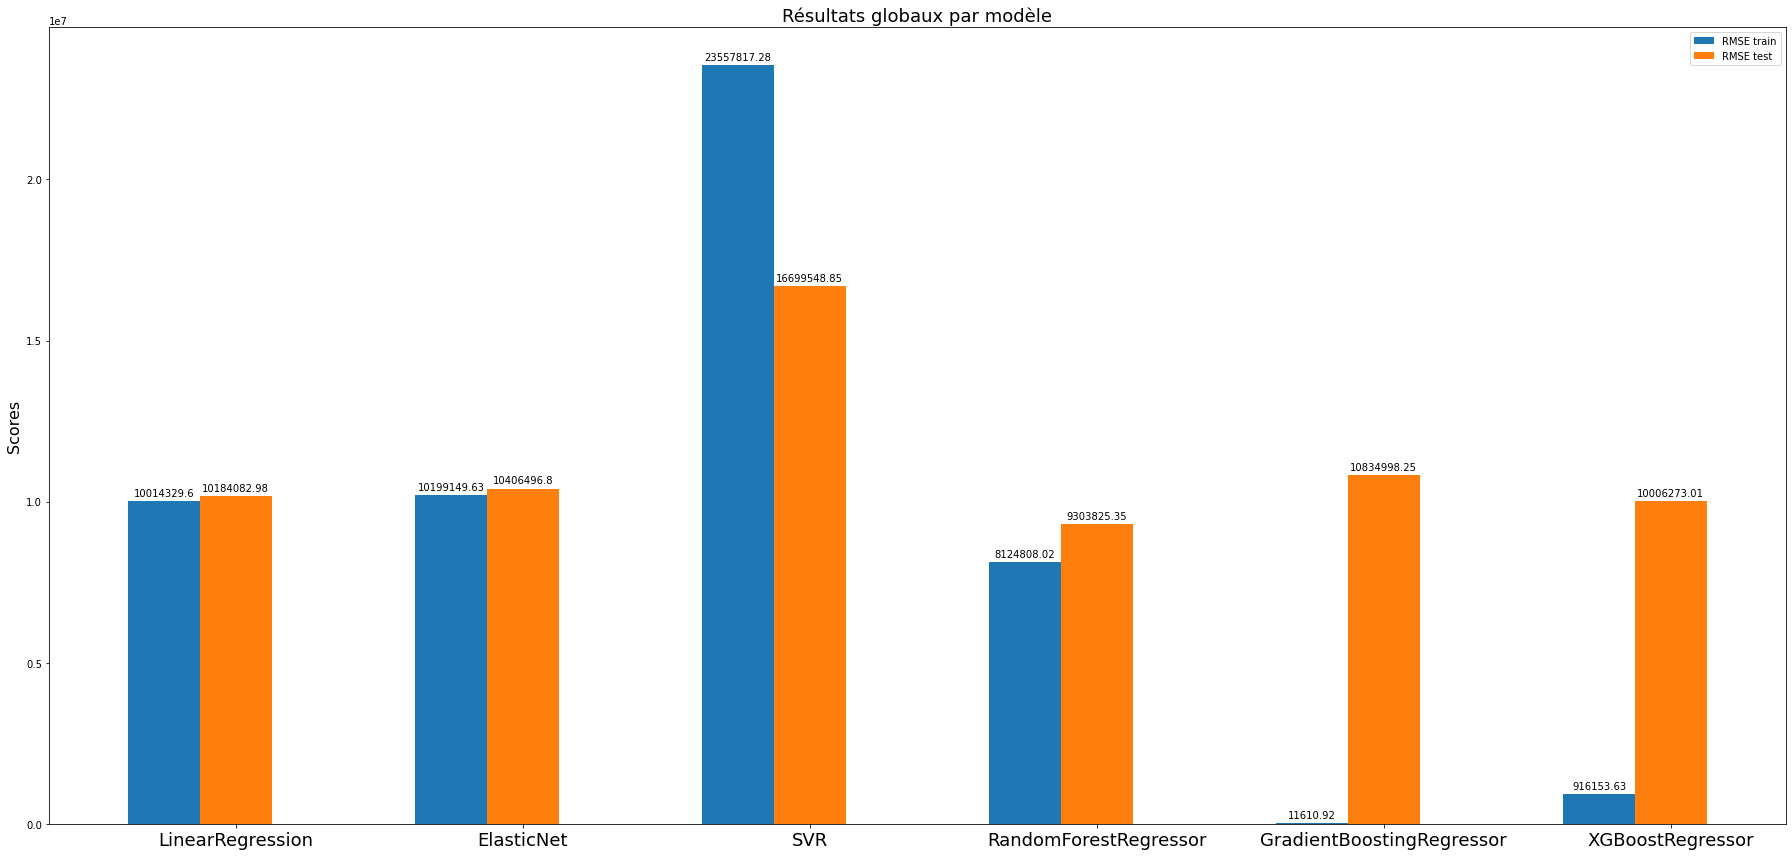

In [4182]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp1_tr, df_results_perf_target1_hyp1_te, 'RMSE')

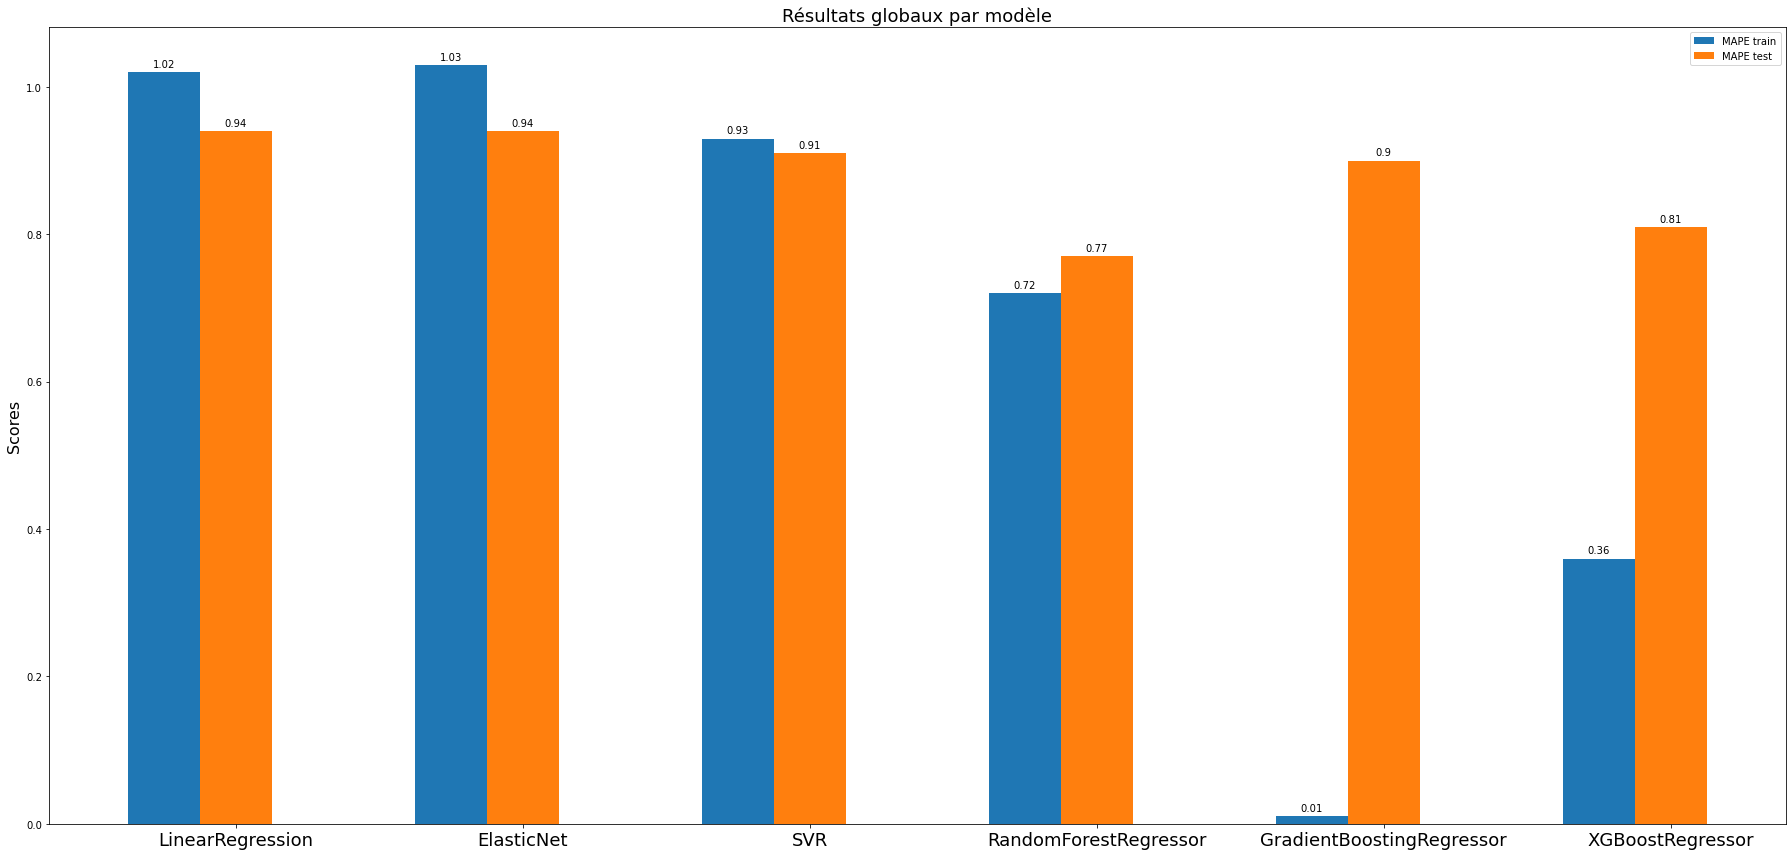

In [4187]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp1_tr, df_results_perf_target1_hyp1_te, 'MAPE')

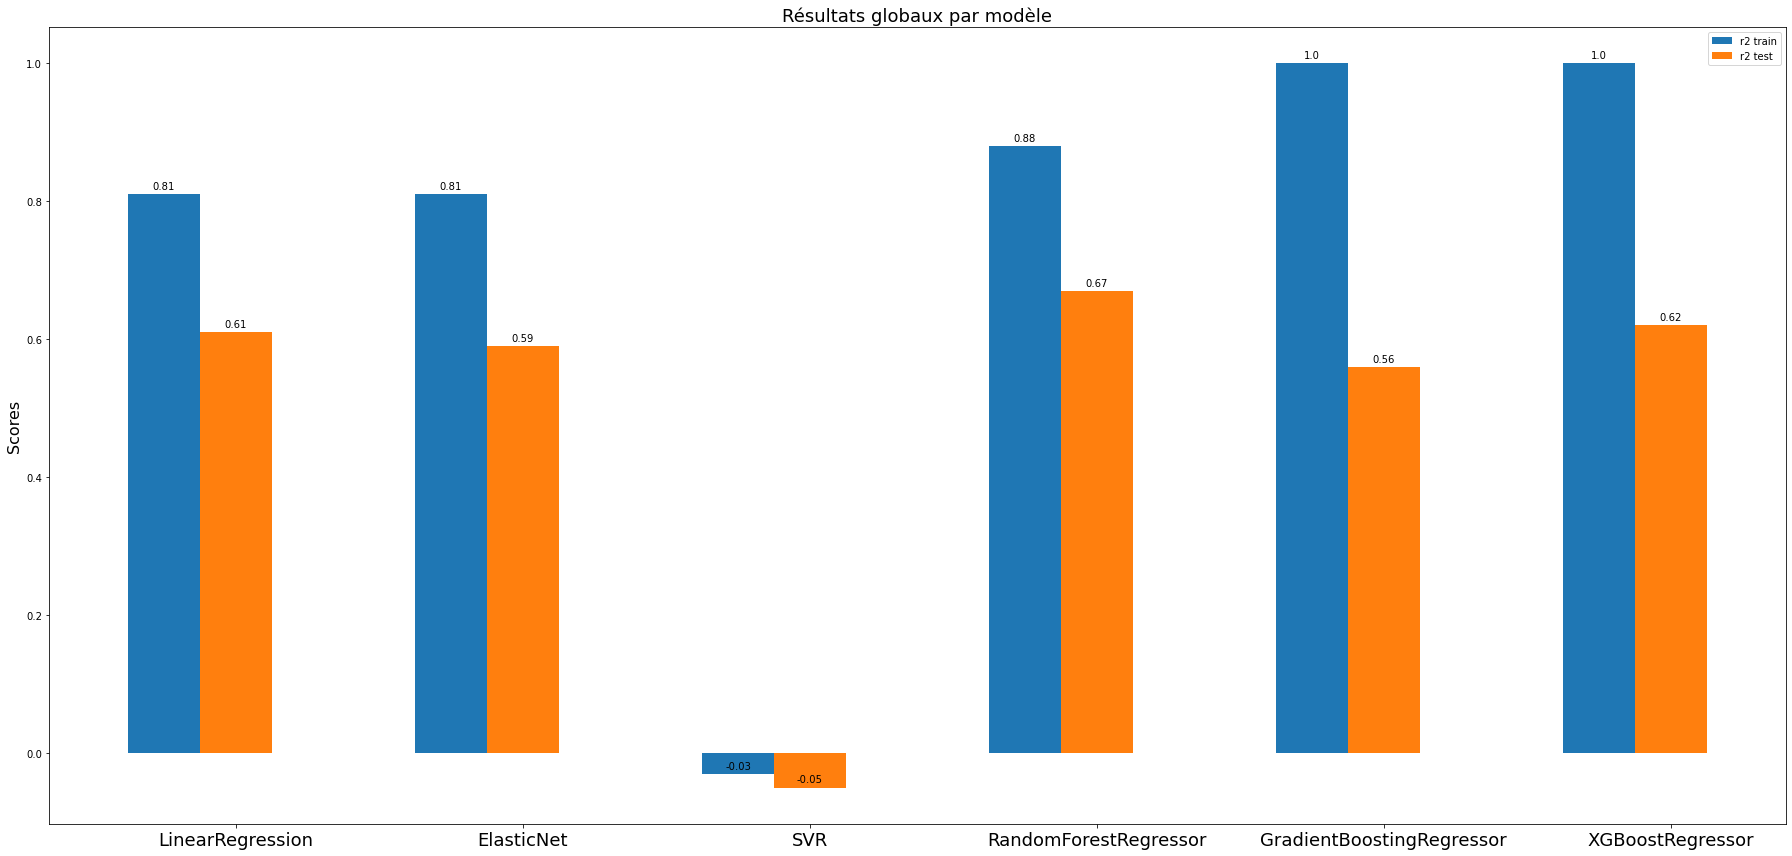

In [4188]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target1_hyp1_tr, df_results_perf_target1_hyp1_te, 'r2')

Sur la métrique de la RMSE, le Random Boosting Regressor (RFR) propose la RMSE la plus faible sur le jeu de test (9303825).
De plus, le RFR propose la meilleur MAPE avec un taux d'erreur moyen sur le jeu de test de 77 %.

Enfin, le RFR obtient le R² le plus élévé sur le jeu de test (0,67).

Le RFR fait un peu mieux que la baseline (LinearRegression) sur la RMSE (10184082) avec un R² plus élevé (0,61.)

**Donc, le Random Forest Regressor est le meilleur modèle pour l'hypothèse 1 sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

On peut remarquer, aussi que le modèle SVR ne semble pas adapté (R² négatif) et que les modèles font du sur-apprentissage sur le jeu de train: en effet, le jeu de train contient la valeur atypique le plus importante. Ainsi, on remarque sur les graphes ci-dessous que les erreurs de prédictions sont liées à l'influence néfaste des quelques valeurs atypiques sur la RMSE, ainsi la variance du modèle correspond à 167% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui est mauvais en termes de qualité des prédictions.

Nous allons tester avec l'hypothèse 2, de passer les variables cible à l'échelle logarithmique, tout en conservant les valeurs atypiques.

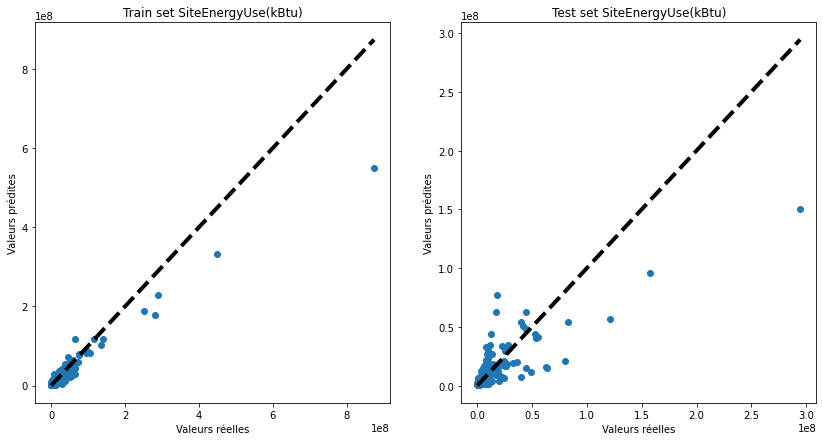

In [4189]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target1_hyp1_tr[df_results_error_target1_hyp1_tr['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

train_pred_values = df_results_error_target1_hyp1_tr[df_results_error_target1_hyp1_tr['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

test_values = df_results_error_target1_hyp1_te[df_results_error_target1_hyp1_te['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

test_pred_values = df_results_error_target1_hyp1_te[df_results_error_target1_hyp1_te['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target1)

#### 5.6.4 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [3532]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target2, X_test_target2, y_train_target2, y_test_target2 = train_test_split(X,
                                                                                    y_target2,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2.shape))

Dimension jeu de données X_train:(2607, 11)
Dimension jeu de données y_train:(2607, 1)
Dimension jeu de données X_test:(652, 11)
Dimension jeu de données y_test:(652, 1)


In [3535]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_hyp1 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2, X_test_target2, y_train_target2,y_test_target2,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target2, 1, 10)
    
    df_optim_hyperparam_co2_hyp1 = pd.concat([df_optim_hyperparam_co2_hyp1, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  457.3373369493115

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
Optimal hyperparameter combination:  {'alpha': 1, 'l1_ratio': 0.5, 'tol': 0.1}
Best score (RMSE):  364.25055143065373

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
----------------------------------------------------------

In [3536]:
df_optim_hyperparam_co2_hyp1

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,TotalGHGEmissions_CO2,10,{'fit_intercept': True}
1,ElasticNet,TotalGHGEmissions_CO2,10,"{'alpha': 1, 'l1_ratio': 0.5, 'tol': 0.1}"
2,SVR,TotalGHGEmissions_CO2,10,"{'C': 10, 'epsilon': 1, 'gamma': 0.01}"
3,RandomForestRegressor,TotalGHGEmissions_CO2,10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}"
4,GradientBoostingRegressor,TotalGHGEmissions_CO2,10,"{'learning_rate': 0.7, 'loss': 'ls', 'max_depth': 6}"
5,XGBoostRegressor,TotalGHGEmissions_CO2,10,"{'max_depth': 6, 'n_estimators': 100}"


#### 5.6.5 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [3537]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_hyp1_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_hyp1_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_hyp1_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_hyp1_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target2, y_train_target2, X_test_target2, y_test_target2, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  1, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'N')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_hyp1_tr = pd.concat([df_results_error_target2_hyp1_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_hyp1_te = pd.concat([df_results_error_target2_hyp1_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_hyp1_tr = pd.concat([df_results_perf_target2_hyp1_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_hyp1_te = pd.concat([df_results_perf_target2_hyp1_te, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_TotalGHGEmissions_CO2_hyph1_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.63
Train RMSE:  334.91
Train MAPE:  3.75

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegre

D:\Applications\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [3538]:
df_results_error_target2_hyp1_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,1,TotalGHGEmissions_CO2,Train,3.345,13.570158,10.225158,305.68
1,LinearRegression,1,TotalGHGEmissions_CO2,Train,8.440,65.025482,56.585482,670.44
2,LinearRegression,1,TotalGHGEmissions_CO2,Train,32.015,-72.894360,104.909360,327.69
3,LinearRegression,1,TotalGHGEmissions_CO2,Train,8.260,6.482887,1.777113,21.51
4,LinearRegression,1,TotalGHGEmissions_CO2,Train,49.840,94.714562,44.874562,90.04
...,...,...,...,...,...,...,...,...
15637,XGBoostRegressor,1,TotalGHGEmissions_CO2,Train,3.435,8.709038,5.274038,153.54
15638,XGBoostRegressor,1,TotalGHGEmissions_CO2,Train,16.705,29.247543,12.542543,75.08
15639,XGBoostRegressor,1,TotalGHGEmissions_CO2,Train,24.240,49.272926,25.032926,103.27
15640,XGBoostRegressor,1,TotalGHGEmissions_CO2,Train,152.675,170.207169,17.532169,11.48


In [3539]:
df_results_error_target2_hyp1_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,1,TotalGHGEmissions_CO2,Test,39.080,103.447269,64.367269,164.71
1,LinearRegression,1,TotalGHGEmissions_CO2,Test,5.955,25.941805,19.986805,335.63
2,LinearRegression,1,TotalGHGEmissions_CO2,Test,5.380,54.390216,49.010216,910.97
3,LinearRegression,1,TotalGHGEmissions_CO2,Test,90.755,118.416885,27.661885,30.48
4,LinearRegression,1,TotalGHGEmissions_CO2,Test,71.060,147.247817,76.187817,107.22
...,...,...,...,...,...,...,...,...
3907,XGBoostRegressor,1,TotalGHGEmissions_CO2,Test,9.925,64.973564,55.048564,554.65
3908,XGBoostRegressor,1,TotalGHGEmissions_CO2,Test,8.620,24.202017,15.582017,180.77
3909,XGBoostRegressor,1,TotalGHGEmissions_CO2,Test,16.700,43.292400,26.592400,159.24
3910,XGBoostRegressor,1,TotalGHGEmissions_CO2,Test,863.370,1920.379028,1057.009028,122.43


In [3540]:
df_results_perf_target2_hyp1_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,1,TotalGHGEmissions_CO2,Train,0.63,334.91,3.75
1,ElasticNet,1,TotalGHGEmissions_CO2,Train,0.50,389.74,3.63
2,SVR,1,TotalGHGEmissions_CO2,Train,0.06,533.37,1.37
3,RandomForestRegressor,1,TotalGHGEmissions_CO2,Train,0.89,180.65,2.26
4,GradientBoostingRegressor,1,TotalGHGEmissions_CO2,Train,1.00,3.97,0.22
5,XGBoostRegressor,1,TotalGHGEmissions_CO2,Train,1.00,25.90,1.01


In [3541]:
df_results_perf_target2_hyp1_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,1,TotalGHGEmissions_CO2,Test,0.36,431.00,3.64
1,ElasticNet,1,TotalGHGEmissions_CO2,Test,0.23,472.26,3.59
2,SVR,1,TotalGHGEmissions_CO2,Test,0.06,522.83,1.30
3,RandomForestRegressor,1,TotalGHGEmissions_CO2,Test,0.62,333.35,2.35
4,GradientBoostingRegressor,1,TotalGHGEmissions_CO2,Test,0.54,364.59,2.34
5,XGBoostRegressor,1,TotalGHGEmissions_CO2,Test,0.64,323.73,2.07


In [3542]:
# Valeur max cible test
y_test_target2.max()

TotalGHGEmissions_CO2    12066.025
dtype: float64

In [3543]:
# Valeur moyenne cible test
y_test_target2.mean()

TotalGHGEmissions_CO2    126.148604
dtype: float64

In [3534]:
# Valeur max cible train
y_train_target2.max()

TotalGHGEmissions_CO2    16870.98
dtype: float64

In [2863]:
# Valeur moyenne cible train
y_train_target2.mean()

TotalGHGEmissions_CO2    123.052956
dtype: float64

#### 5.6.6 Variable "TotalGHGEmissions_CO2"  - Affichage métriques  et choix du modéle

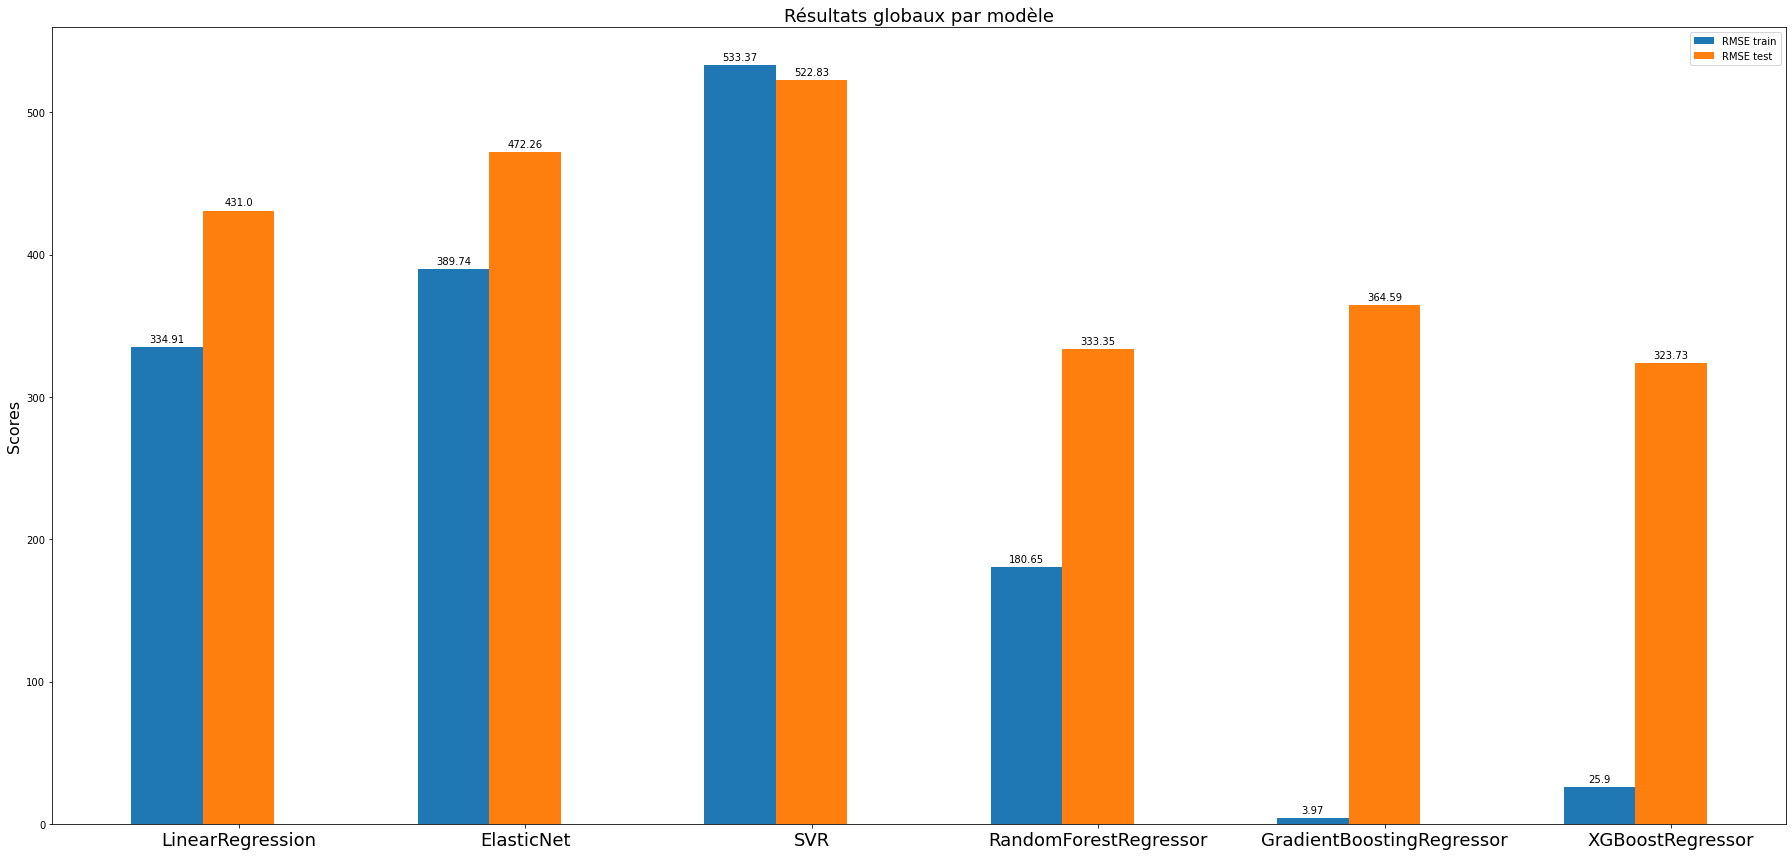

In [4190]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp1_tr, df_results_perf_target2_hyp1_te, 'RMSE')

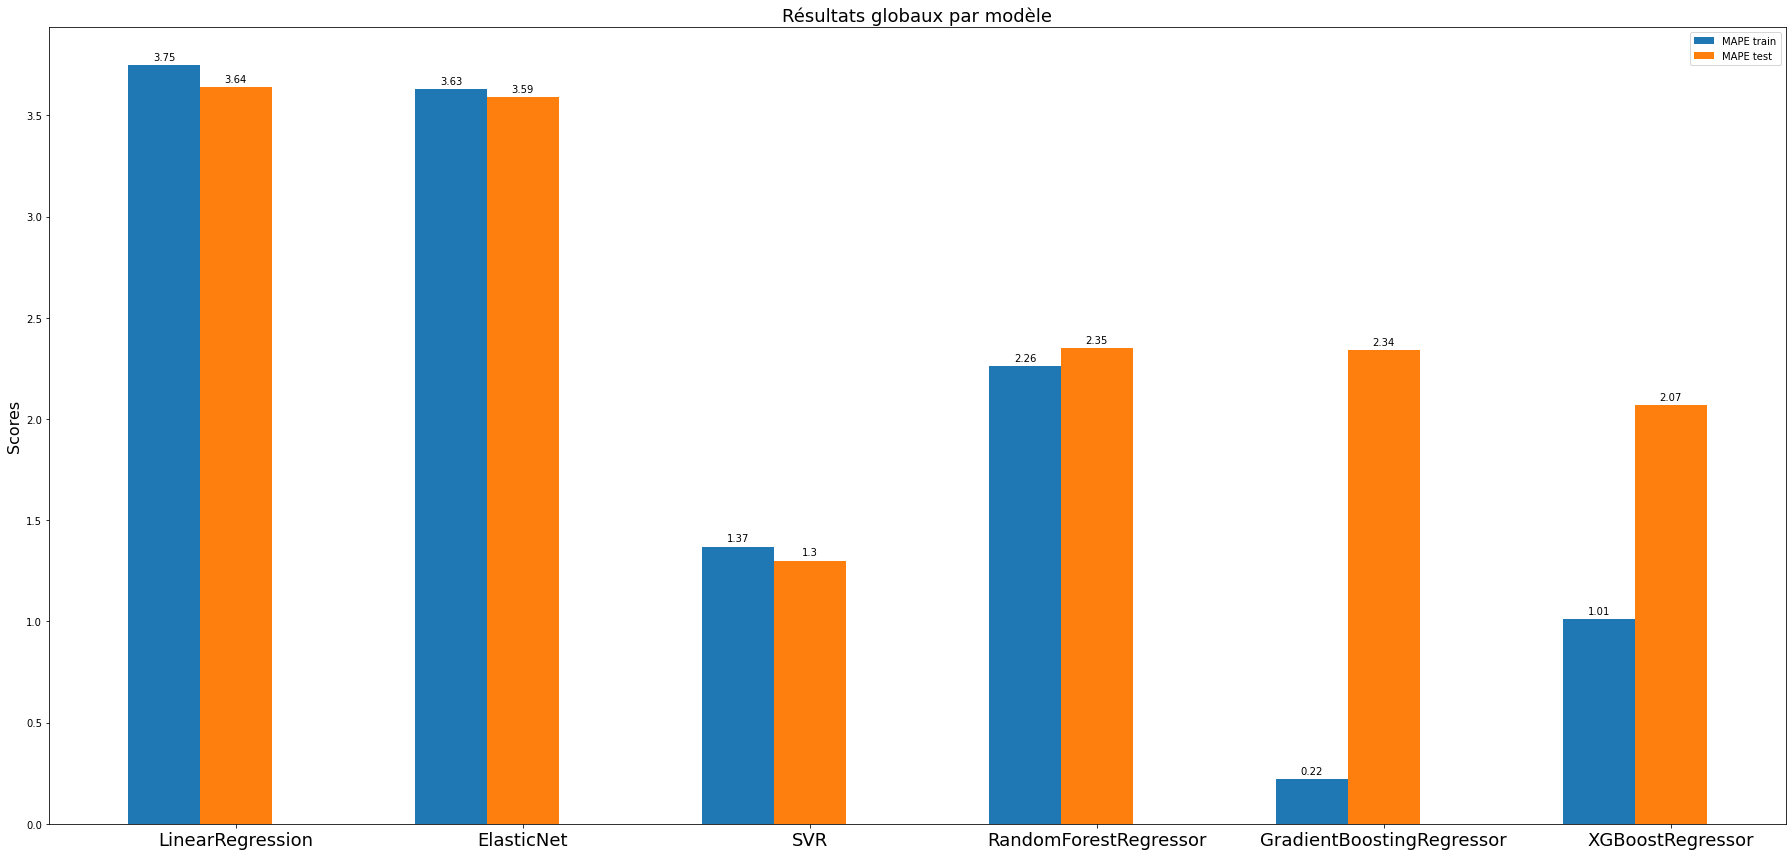

In [4191]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp1_tr, df_results_perf_target2_hyp1_te, 'MAPE')

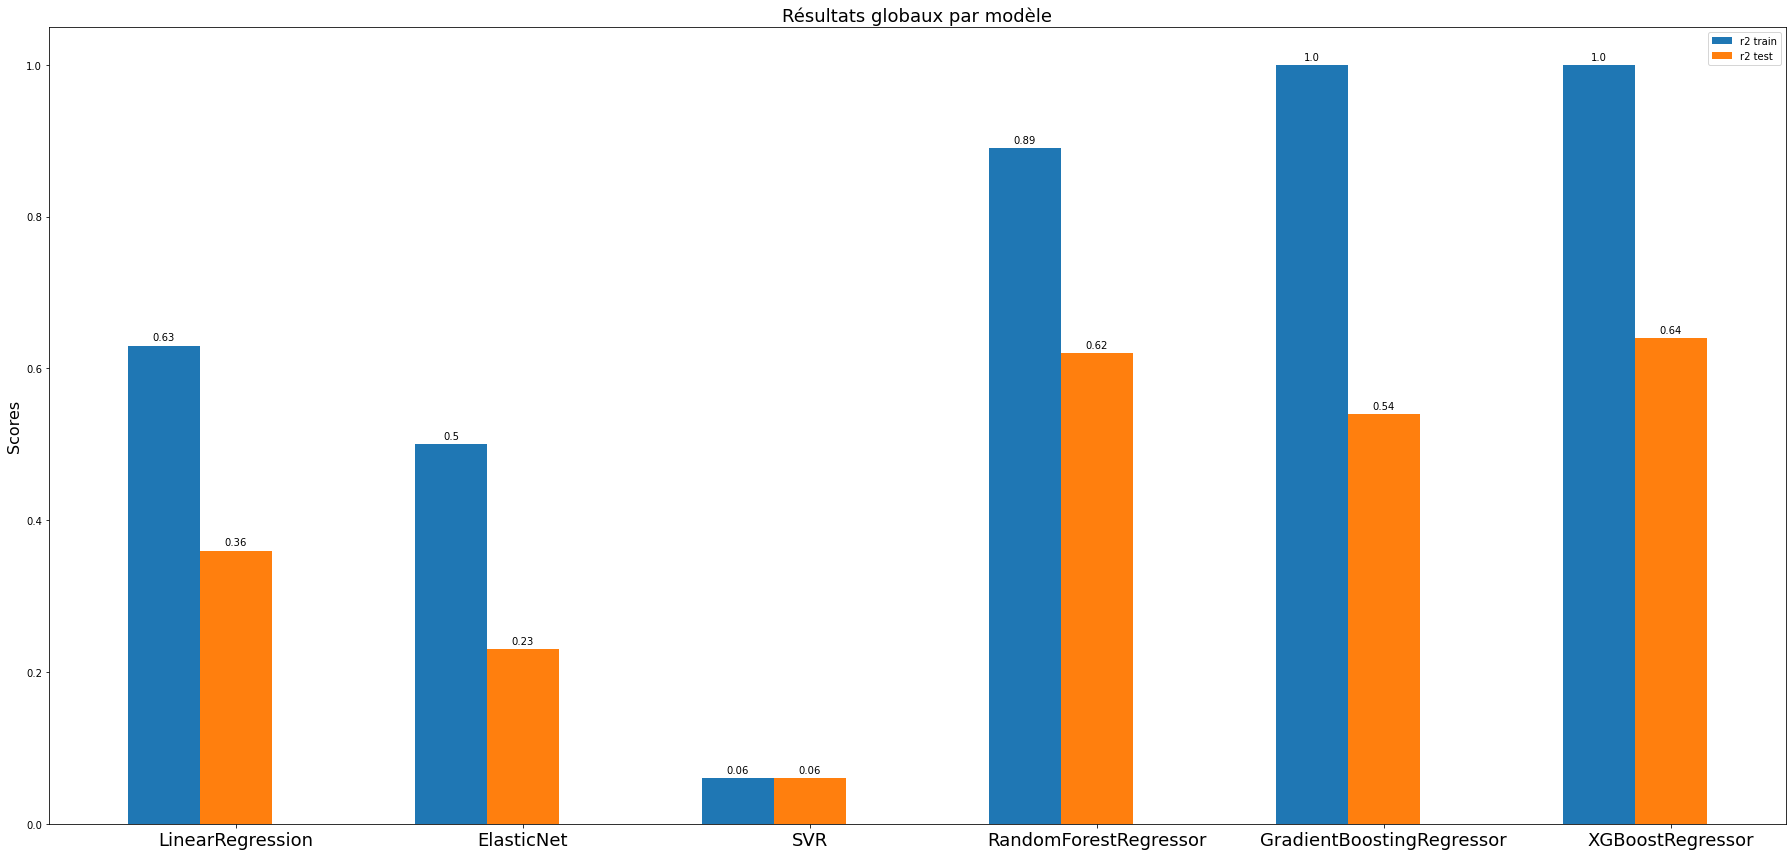

In [4192]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target2_hyp1_tr, df_results_perf_target2_hyp1_te, 'r2')

Sur la métrique de la RMSE, le Extreme Gradient Boosting Regressor (XGR) propose la RMSE la plus faible sur le jeu de test (323).
Sur la MAPE, le XGR affiche un taux d'erreur moyen (MAPE) sur le jeu de test de 207%.

Enfin, le XGR obtient le R² le plus élévé sur le jeu de test (0,64).

Le XGR fait mieux que la baseline (LinearRegression) sur la RMSE (431) avec un R² (0,36)

**Donc, le XGR est le meilleur modèle pour l'hypothèse 1 sur la variable "TotalGHGEmissions-CO2", compte tenu de la métrique RMSE.**

On peut remarquer, aussi que le modèle SVR ne semble pas adapté (R² proche de 0) et que les modèles font du sur-apprentissage sur le jeu de train: en effet, le jeu de train contient la valeur atypique le plus importante. Ainsi, on remarque sur les graphes ci-dessous que les erreurs de prédictions sont liées à l'influence néfaste des quelques valeurs atypiques sur la RMSE, ainsi la variance du modèle correspond à 256% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui est mauvais en termes de qualité des prédictions.


Nous allons tester, avec l'hypothèse 2, de passer les variables cible à l'échelle logarithmique, tout en conservant les valeurs atypiques.

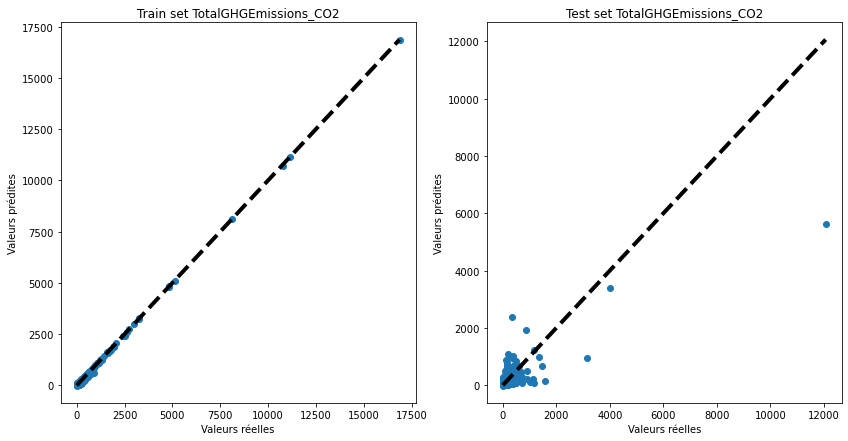

In [4193]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_hyp1_tr[df_results_error_target2_hyp1_tr['Modeles'] ==
                                                'XGBoostRegressor'][['y']]

train_pred_values = df_results_error_target2_hyp1_tr[df_results_error_target2_hyp1_tr['Modeles'] ==
                                                'XGBoostRegressor'][['y_pred']]

test_values = df_results_error_target2_hyp1_te[df_results_error_target2_hyp1_te['Modeles'] ==
                                                'XGBoostRegressor'][['y']]

test_pred_values = df_results_error_target2_hyp1_te[df_results_error_target2_hyp1_te['Modeles'] ==
                                                'XGBoostRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target2)

### 5.7 Hypothèse 2: réglage hyper-paramètres, entraînement, prédictions sur les modèles

In [312]:
# Variables en entrée
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'Distance_harversine','PropertyGFATotal', 'NumberofBuildings', 
               'NumberofFloors']

# Jeu de données en entrée
X = X_std_out[liste_col_X]

In [3549]:
X

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,Distance_harversine,PropertyGFATotal,NumberofBuildings,NumberofFloors
0,-0.201870,-0.106163,-0.161455,0.163587,2.033089,-0.151973,-0.297928,-1.079755,-0.212967,-0.044974,-0.140856
1,-0.133594,-0.362232,-0.161455,-0.736972,-1.187442,-0.147600,-0.297928,0.799366,-0.196013,-0.044974,-0.140856
2,0.154645,-0.362232,-0.161455,-0.736972,-0.645671,-0.078875,-0.297928,-1.087257,0.070401,-0.044974,-0.140856
3,0.092506,-0.362232,-0.161455,-0.736972,1.852498,-0.090123,0.470427,-1.176151,0.012967,-0.044974,0.219041
4,0.289589,0.829940,0.677928,2.865265,0.618463,-0.026574,0.824190,-0.766478,0.444243,-0.044974,-0.140856
...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.299238,-0.362232,-0.161455,-0.736972,-0.404883,-0.199869,-0.297928,0.882604,-0.349114,-0.044974,-0.680701
3255,-0.310294,-0.362232,-0.161455,-0.736972,-1.067049,-0.200923,-0.297928,-0.924256,-0.359334,-0.044974,-0.680701
3256,-0.351455,-0.222448,-0.161455,1.064146,-0.164096,-0.202249,-0.297928,-0.225035,-0.372184,-0.044974,-0.680701
3257,-0.356257,-0.199201,-0.125071,2.865265,-0.615572,-0.201809,-0.297928,1.081671,-0.367917,-0.044974,-0.680701


In [ ]:
# Variable à prédire - variable "SiteEnergyUse(kBtu)"
y_target1_hyp2 = y_log_out[['log_SiteEnergyUse(kBtu)']]
y_target1_hyp2

In [3552]:
# Variable à prédire - variable "TotalGHGEmissions_CO2"
y_target2_hyp2 = y_log_out[['log_TotalGHGEmissions_CO2']]
y_target2_hyp2

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3254,3.060115
3255,3.501646
3256,5.414054
3257,3.140265


In [37]:
# Hypothèse testée
id_hyp = 2

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_lr1 = ds_rep + 'LinearRegression_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet1 = ds_rep + 'ElasticNet_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr1 = ds_rep + 'SVR_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr1 = ds_rep + 'RandomForestRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr1 = ds_rep + 'GradientBoostingRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr1 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'

# Variable cible "TotalGHGEmissions_CO2"
fic_lr2 = ds_rep + 'LinearRegression_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet2 = ds_rep + 'ElasticNet_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr2 = ds_rep + 'SVR_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr2 = ds_rep + 'RandomForestRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr2 = ds_rep + 'GradientBoostingRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr2 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'


NameError: name 'ds_rep' is not defined

In [ ]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target1 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr1}},
                        
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet1}},
                    
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr1}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr1}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr1}},
                       
                       'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr1}}}

In [ ]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "TotalGHGEmissions_CO2"
hyper_params_target2 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr2}},
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet2}},
                    
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr2}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr2}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr2}},
                       
                         'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr2}}}

#### 5.7.1 Variable "SiteEnergyUse(kBtu)" - Réglage hyper-paramètres et entraînement modèles

In [3557]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target1_hyp2, X_test_target1_hyp2, y_train_target1_hyp2, y_test_target1_hyp2 = train_test_split(X,
                                                                                        y_target1_hyp2,
                                                                                       test_size=0.2,
                                                                                       shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target1_hyp2.shape))
print('Dimension jeu de données y_train:' + str(y_train_target1_hyp2.shape))
print('Dimension jeu de données X_test:' + str(X_test_target1_hyp2.shape))
print('Dimension jeu de données y_test:' + str(y_test_target1_hyp2.shape))

Dimension jeu de données X_train:(2607, 11)
Dimension jeu de données y_train:(2607, 1)
Dimension jeu de données X_test:(652, 11)
Dimension jeu de données y_test:(652, 1)


In [3560]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_energie_hyp2 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target1_hyp2, X_test_target1_hyp2, y_train_target1_hyp2,y_test_target2,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target1, 2, 10)
    
    df_optim_hyperparam_energie_hyp2 = pd.concat([df_optim_hyperparam_energie_hyp2, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  1.1892026762165173

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


D:\Applications\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.3074666602606, tolerance: 333.5229826391832
  model = cd_fast.enet_coordinate_descent(


Optimal hyperparameter combination:  {'alpha': 1, 'l1_ratio': 0.0, 'tol': 0.1}
Best score (RMSE):  0.9351399480432688

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Optimal hyperparameter combination:  {'C': 10, 'epsilon': 0.1, 'gamma': 0.1}
Best score (RMSE):  0.658062584149895

------ Optimisation hyper-paramètres du modèle RandomForestRegressor ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Optimal hyperparameter combination:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}
Best score (RMSE):  0.6310120373706515

------ Optimisation hype

In [3561]:
df_optim_hyperparam_energie_hyp2

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,SiteEnergyUse(kBtu),10,{'fit_intercept': True}
1,ElasticNet,SiteEnergyUse(kBtu),10,"{'alpha': 1, 'l1_ratio': 0.0, 'tol': 0.1}"
2,SVR,SiteEnergyUse(kBtu),10,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.1}"
3,RandomForestRegressor,SiteEnergyUse(kBtu),10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}"
4,GradientBoostingRegressor,SiteEnergyUse(kBtu),10,"{'learning_rate': 0.2, 'loss': 'huber', 'max_depth': 4}"
5,XGBoostRegressor,SiteEnergyUse(kBtu),10,"{'max_depth': 4, 'n_estimators': 100}"


#### 5.7.2 Variable "SiteEnergyUse(kBtu)" - Prédictions 

In [3570]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target1_hyp2_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target1_hyp2_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target1_hyp2_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target1_hyp2_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target1:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target1_hyp2, y_train_target1_hyp2, X_test_target1_hyp2, y_test_target1_hyp2, 
                  hyper_params_target1[model_hyper_param]['regressor']['model'],
                  hyper_params_target1[model_hyper_param]['regressor']['model_txt'],
                  2, hyper_params_target1[model_hyper_param]['regressor']['fic_hyperparam'],target1, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target1_hyp2_tr = pd.concat([df_results_error_target1_hyp2_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target1_hyp2_te = pd.concat([df_results_error_target1_hyp2_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target1_hyp2_tr = pd.concat([df_results_perf_target1_hyp2_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target1_hyp2_te = pd.concat([df_results_perf_target1_hyp2_te, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_SiteEnergyUse(kBtu)_hyph2_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.44
Train RMSE:  724660186.58
Train MAPE:  0.79

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearR

D:\Applications\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196.3074666602606, tolerance: 333.5229826391832
  model = cd_fast.enet_coordinate_descent(



-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: SVR
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/SVR_SiteEnergyUse(kBtu)_hyph2_optim_params.pkl
Hyper-paramètres optimisés: {'C': 10, 'epsilon': 0.1, 'gamma': 0.1}
Prédictions avec les paramètres suivants du modèle:
{'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle SVR sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.72
Train RMSE:  3992407.84
Train MAPE:  0.45

-----------------------------------------------------------------------------------

D:\Applications\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [3571]:
df_results_error_target1_hyp2_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,2,SiteEnergyUse(kBtu),Train,2.198355e+06,1.700445e+06,4.979100e+05,22.65
1,LinearRegression,2,SiteEnergyUse(kBtu),Train,1.316454e+06,1.508698e+06,1.922437e+05,14.60
2,LinearRegression,2,SiteEnergyUse(kBtu),Train,2.682956e+06,2.184279e+06,4.986768e+05,18.59
3,LinearRegression,2,SiteEnergyUse(kBtu),Train,1.187627e+06,1.928461e+06,7.408339e+05,62.38
4,LinearRegression,2,SiteEnergyUse(kBtu),Train,1.059819e+06,1.315557e+06,2.557387e+05,24.13
...,...,...,...,...,...,...,...,...
15637,XGBoostRegressor,2,SiteEnergyUse(kBtu),Train,8.326730e+05,1.269040e+06,4.363669e+05,52.41
15638,XGBoostRegressor,2,SiteEnergyUse(kBtu),Train,1.483930e+07,6.393512e+06,8.445788e+06,56.92
15639,XGBoostRegressor,2,SiteEnergyUse(kBtu),Train,1.312044e+06,1.840902e+06,5.288579e+05,40.31
15640,XGBoostRegressor,2,SiteEnergyUse(kBtu),Train,5.216483e+05,7.316154e+05,2.099671e+05,40.25


In [3572]:
df_results_error_target1_hyp2_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,2,SiteEnergyUse(kBtu),Test,1.326367e+07,3.237164e+07,1.910796e+07,144.06
1,LinearRegression,2,SiteEnergyUse(kBtu),Test,1.133013e+06,1.612038e+06,4.790244e+05,42.28
2,LinearRegression,2,SiteEnergyUse(kBtu),Test,2.000861e+06,1.234061e+06,7.668009e+05,38.32
3,LinearRegression,2,SiteEnergyUse(kBtu),Test,1.051543e+06,1.610077e+06,5.585349e+05,53.12
4,LinearRegression,2,SiteEnergyUse(kBtu),Test,6.332029e+05,1.434761e+06,8.015584e+05,126.59
...,...,...,...,...,...,...,...,...
3907,XGBoostRegressor,2,SiteEnergyUse(kBtu),Test,2.230833e+06,2.158000e+06,7.283275e+04,3.26
3908,XGBoostRegressor,2,SiteEnergyUse(kBtu),Test,9.055149e+05,1.212841e+06,3.073264e+05,33.94
3909,XGBoostRegressor,2,SiteEnergyUse(kBtu),Test,3.541307e+06,3.501288e+06,4.001887e+04,1.13
3910,XGBoostRegressor,2,SiteEnergyUse(kBtu),Test,7.554408e+05,1.390323e+06,6.348820e+05,84.04


In [3573]:
df_results_perf_target1_hyp2_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,2,SiteEnergyUse(kBtu),Train,0.44,7.246602e+08,0.79
1,ElasticNet,2,SiteEnergyUse(kBtu),Train,0.35,6.299031e+08,0.89
2,SVR,2,SiteEnergyUse(kBtu),Train,0.72,3.992408e+06,0.45
3,RandomForestRegressor,2,SiteEnergyUse(kBtu),Train,0.84,1.248382e+07,0.36
4,GradientBoostingRegressor,2,SiteEnergyUse(kBtu),Train,0.85,6.367645e+06,0.33
5,XGBoostRegressor,2,SiteEnergyUse(kBtu),Train,0.88,5.564410e+06,0.29


In [3574]:
df_results_perf_target1_hyp2_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,2,SiteEnergyUse(kBtu),Test,0.48,6.265339e+08,0.90
1,ElasticNet,2,SiteEnergyUse(kBtu),Test,0.40,2.812661e+07,0.95
2,SVR,2,SiteEnergyUse(kBtu),Test,0.69,2.055321e+07,0.60
3,RandomForestRegressor,2,SiteEnergyUse(kBtu),Test,0.72,1.872848e+07,0.56
4,GradientBoostingRegressor,2,SiteEnergyUse(kBtu),Test,0.71,1.717615e+07,0.59
5,XGBoostRegressor,2,SiteEnergyUse(kBtu),Test,0.69,1.788884e+07,0.62


In [3563]:
# Valeur max cible test
np.expm1(y_test_target1_hyp2.max())

log_SiteEnergyUse(kBtu)    448385312.0
dtype: float64

In [3569]:
# Valeur moyenne cible test
df_results_error_target1_hyp2_te[df_results_error_target1_hyp2_te['Modeles'] ==
                                                'XGBoostRegressor'][['y']].mean()


y    6.258357e+06
dtype: float64

In [3564]:
# Valeur max cible train
np.expm1(y_train_target1_hyp2.max())

log_SiteEnergyUse(kBtu)    8.739237e+08
dtype: float64

In [3670]:
# Valeur moyenne cible train
df_results_error_target1_hyp2_tr[df_results_error_target1_hyp2_tr['Modeles'] ==
                                                'XGBoostRegressor'][['y']].mean()

y    5.340019e+06
dtype: float64

#### 5.7.3 Variable "SiteEneryUse(kBtu)"  - Affichage métriques  et choix du modéle

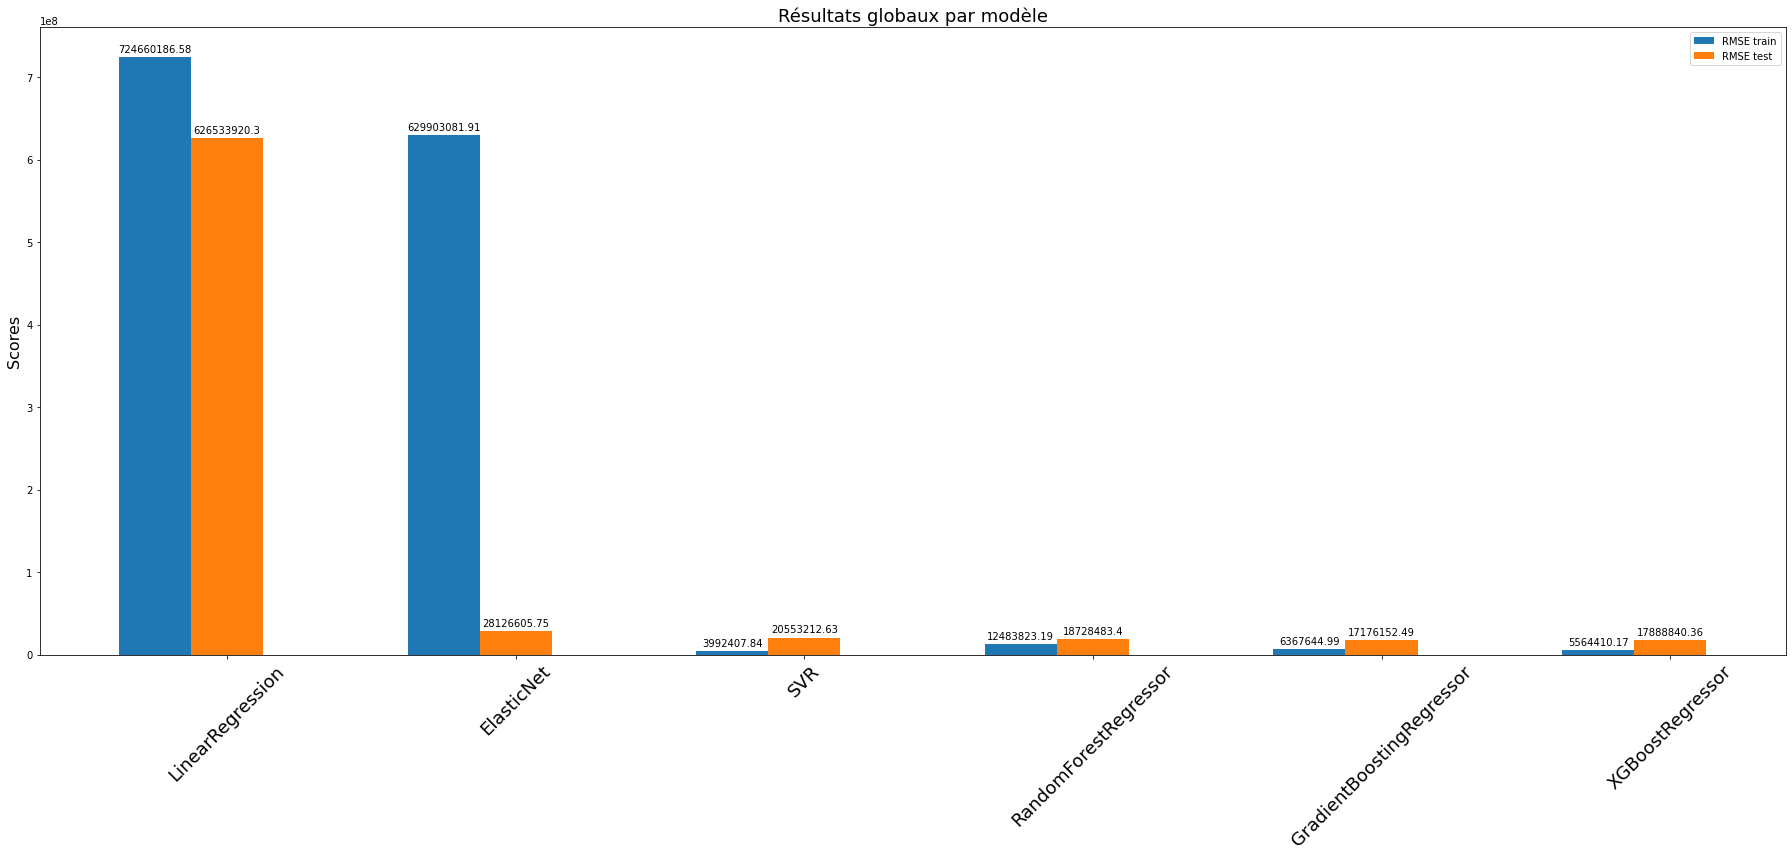

In [3671]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp2_tr, df_results_perf_target1_hyp2_te, 'RMSE')

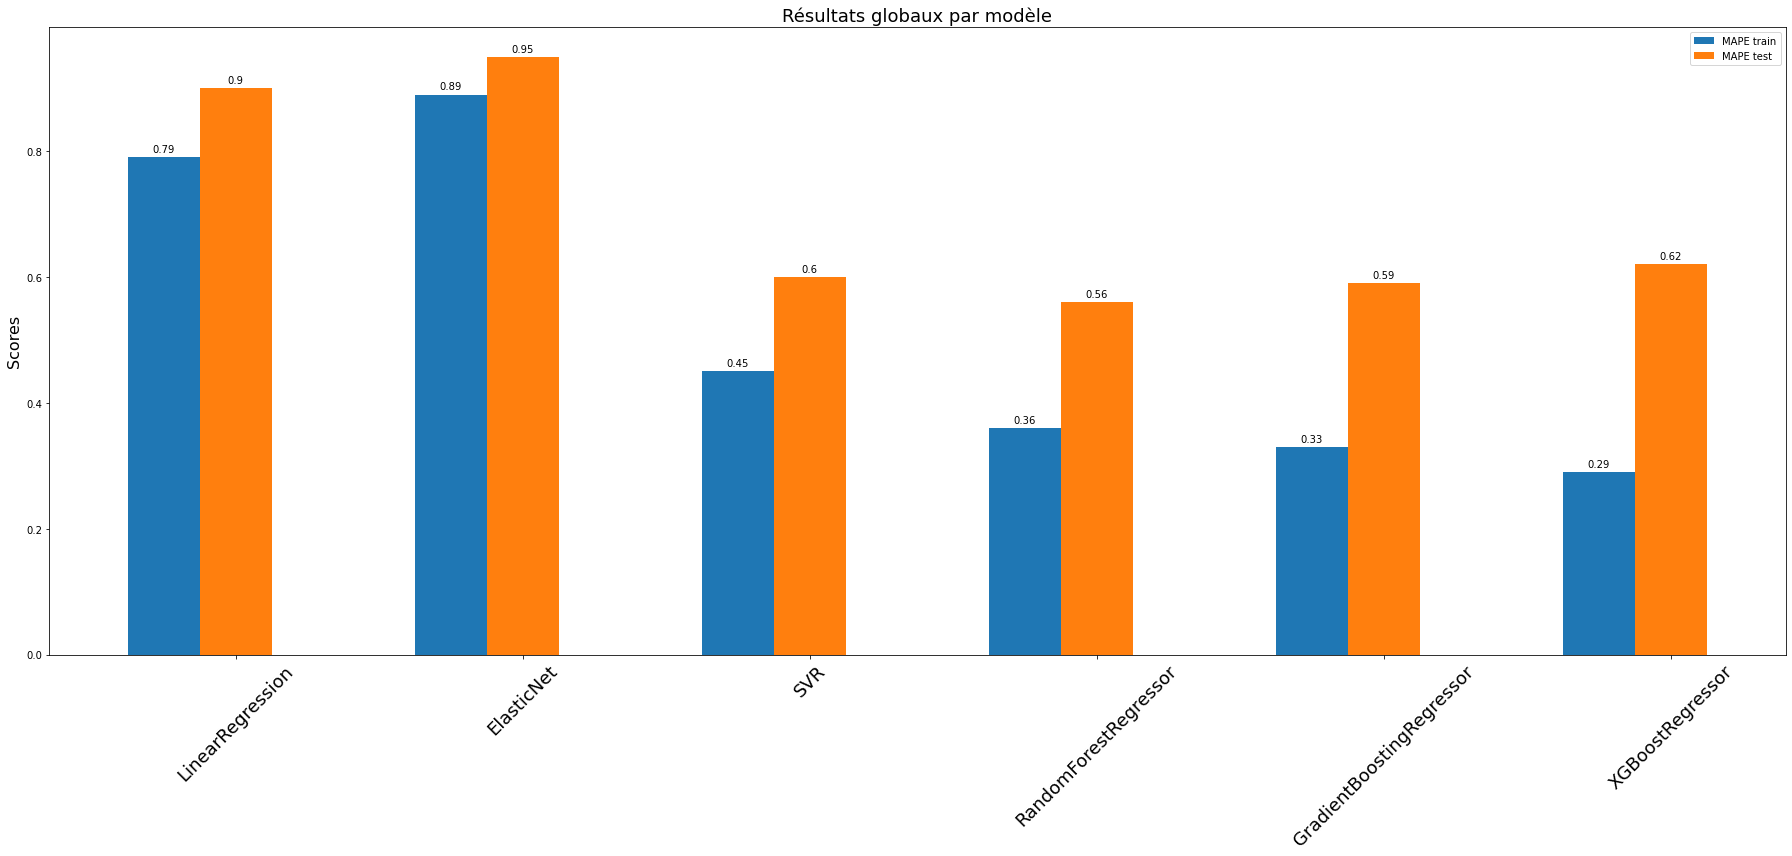

In [3672]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp2_tr, df_results_perf_target1_hyp2_te, 'MAPE')

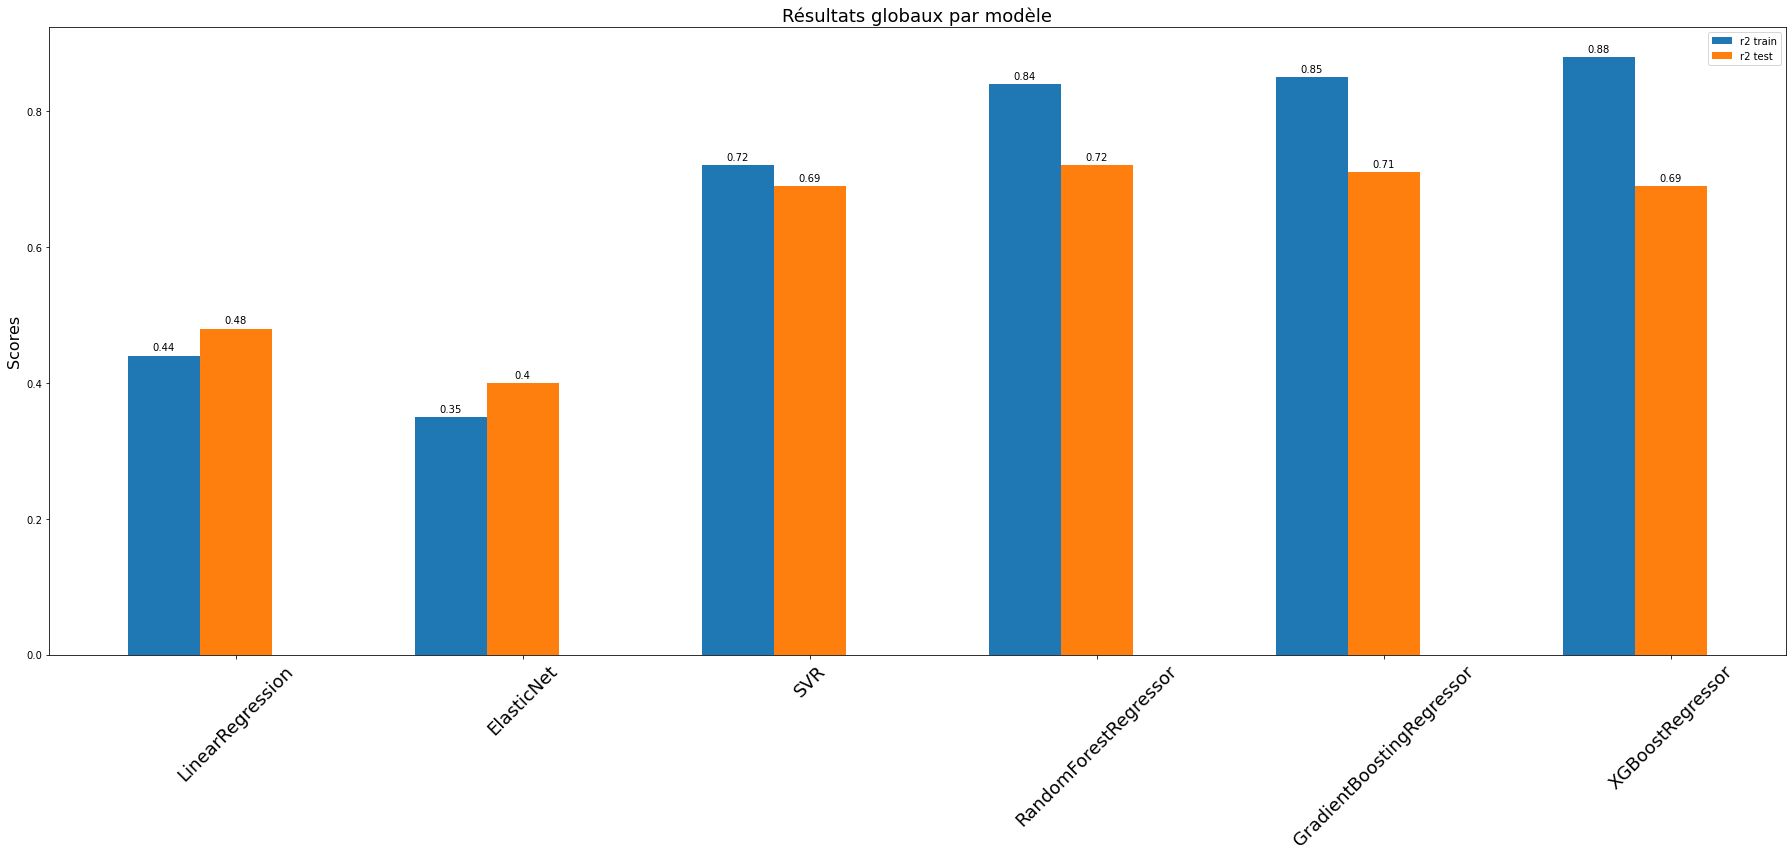

In [3673]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target1_hyp2_tr, df_results_perf_target1_hyp2_te, 'r2')

 Le résultat de l'hypothèse 2 est pire que celui de l'hypothèse 1: en effet, le passage à l'échelle logarithmique de la variable cible réduit le sur-apprentissage sur le jeu train, mais la conversion des cette variable aux valeurs réelles dégrade la RMSE.
 
Le jeu de train contient la valeur atypique la plus élevé en valeur réelle.

Sur la métrique de la RMSE, le Gradient Boosting Regressor (GBR) propose la RMSE la plus faible sur le jeu de test (17176150).
De plus, sur la MAPE, le GBR est à peu près à égalité avec RFR avec un taux d'erreur moyen sur le jeu de test (MAPE) de 59 % (56 % pour le RFR).

Enfin, le GBR obtient un R² de 0,71 sur le jeu de test.

La baseline (LinearRegression), comme tous les modèles linéaires, semble ne pas être adapté pour cette hypothèse (RMSE = 6.265339e+08).

**Donc, le Gradient Boosting Regressor est le meilleur modèle pour l'hypothèse 2 sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

On se rend compte qu'avec l'hypothèse 2, le passage à l'échelle logarithmique de la variable cible permet de limiter le sur-apprentissage sur le jeu de train, mais il y a toujours un impact négatif des valeurs atypiques. Ainsi, on remarque sur les graphes ci-dessous que les erreurs de prédictions sont liées à l'influence néfaste des quelques valeurs atypiques sur la RMSE, ainsi la variance du modèle correspond à 274% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui est mauvais en termes de qualité des prédictions.

Nous allons tester avec l'hypothèse 3, de supprimer les valeurs atypiques sur les variables cible par la méthode des inter-quartiles.

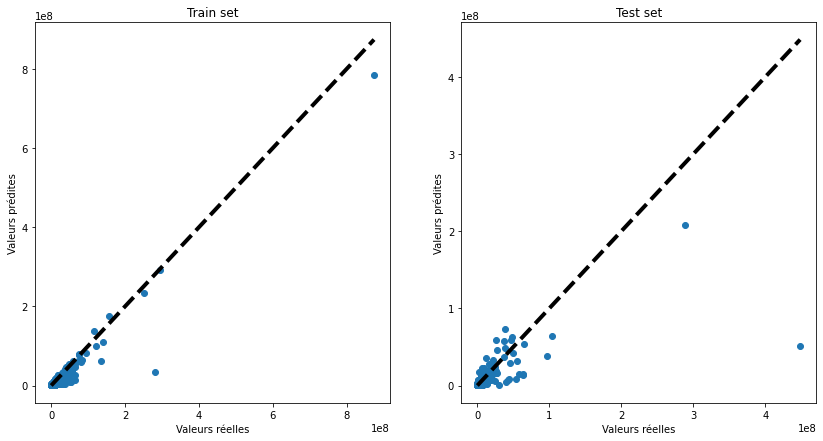

In [3674]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target1_hyp2_tr[df_results_error_target1_hyp2_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target1_hyp2_tr[df_results_error_target1_hyp2_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

test_values = df_results_error_target1_hyp2_te[df_results_error_target1_hyp2_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target1_hyp2_te[df_results_error_target1_hyp2_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target1)

#### 5.7.4 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [ ]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target2_hyp2, X_test_target2_hyp2, y_train_target2_hyp2, y_test_target2_hyp2 = train_test_split(X,
                                                                                    y_target2_hyp2,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2_hyp2.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2_hyp2.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2_hyp2.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2_hyp2.shape))

In [3772]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_hyp2 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2_hyp2, X_test_target2_hyp2, y_train_target2_hyp2,y_test_target2_hyp2,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target2, 2, 10)
    
    df_optim_hyperparam_co2_hyp2 = pd.concat([df_optim_hyperparam_co2_hyp2, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  1.1679372416503069

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
Optimal hyperparameter combination:  {'alpha': 0.01, 'l1_ratio': 0.9, 'tol': 0.1}
Best score (RMSE):  1.1590659207433338

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
------------------------------------------------------

In [3773]:
df_optim_hyperparam_co2_hyp2

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,TotalGHGEmissions_CO2,10,{'fit_intercept': True}
1,ElasticNet,TotalGHGEmissions_CO2,10,"{'alpha': 0.01, 'l1_ratio': 0.9, 'tol': 0.1}"
2,SVR,TotalGHGEmissions_CO2,10,"{'C': 10, 'epsilon': 1, 'gamma': 0.1}"
3,RandomForestRegressor,TotalGHGEmissions_CO2,10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}"
4,GradientBoostingRegressor,TotalGHGEmissions_CO2,10,"{'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 6}"
5,XGBoostRegressor,TotalGHGEmissions_CO2,10,"{'max_depth': 4, 'n_estimators': 100}"


#### 5.7.5 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [3778]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_hyp2_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_hyp2_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_hyp2_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_hyp2_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target2_hyp2, y_train_target2_hyp2, X_test_target2_hyp2, y_test_target2_hyp2, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  2, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_hyp2_tr = pd.concat([df_results_error_target2_hyp2_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_hyp2_te = pd.concat([df_results_error_target2_hyp2_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_hyp2_tr = pd.concat([df_results_perf_target2_hyp2_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_hyp2_te = pd.concat([df_results_perf_target2_hyp2_te, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_TotalGHGEmissions_CO2_hyph2_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.34
Train RMSE:  105827.67
Train MAPE:  2.62

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRe

D:\Applications\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [3779]:
df_results_error_target2_hyp2_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,2,TotalGHGEmissions_CO2,Train,36.610,20.455434,16.154566,44.13
1,LinearRegression,2,TotalGHGEmissions_CO2,Train,27.845,28.683657,0.838657,3.01
2,LinearRegression,2,TotalGHGEmissions_CO2,Train,15.375,25.488466,10.113466,65.78
3,LinearRegression,2,TotalGHGEmissions_CO2,Train,44.770,40.143504,4.626496,10.33
4,LinearRegression,2,TotalGHGEmissions_CO2,Train,35.575,25.044602,10.530398,29.60
...,...,...,...,...,...,...,...,...
15637,XGBoostRegressor,2,TotalGHGEmissions_CO2,Train,229.480,130.069809,99.410191,43.32
15638,XGBoostRegressor,2,TotalGHGEmissions_CO2,Train,143.890,160.514694,16.624694,11.55
15639,XGBoostRegressor,2,TotalGHGEmissions_CO2,Train,21.100,34.440613,13.340613,63.23
15640,XGBoostRegressor,2,TotalGHGEmissions_CO2,Train,136.355,98.658936,37.696064,27.65


In [3780]:
df_results_error_target2_hyp2_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,2,TotalGHGEmissions_CO2,Test,24.055,55.590483,31.535483,131.10
1,LinearRegression,2,TotalGHGEmissions_CO2,Test,5.910,19.487168,13.577168,229.73
2,LinearRegression,2,TotalGHGEmissions_CO2,Test,93.060,38.833682,54.226318,58.27
3,LinearRegression,2,TotalGHGEmissions_CO2,Test,36.720,21.478842,15.241158,41.51
4,LinearRegression,2,TotalGHGEmissions_CO2,Test,8.660,29.622417,20.962417,242.06
...,...,...,...,...,...,...,...,...
3907,XGBoostRegressor,2,TotalGHGEmissions_CO2,Test,26.155,47.161991,21.006991,80.32
3908,XGBoostRegressor,2,TotalGHGEmissions_CO2,Test,27.360,6.203455,21.156545,77.33
3909,XGBoostRegressor,2,TotalGHGEmissions_CO2,Test,3.550,6.875416,3.325416,93.67
3910,XGBoostRegressor,2,TotalGHGEmissions_CO2,Test,61.495,38.319798,23.175202,37.69


In [3781]:
df_results_perf_target2_hyp2_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,2,TotalGHGEmissions_CO2,Train,0.34,105827.67,2.62
1,ElasticNet,2,TotalGHGEmissions_CO2,Train,0.34,87726.48,2.29
2,SVR,2,TotalGHGEmissions_CO2,Train,0.54,360.08,1.25
3,RandomForestRegressor,2,TotalGHGEmissions_CO2,Train,0.75,313.63,0.77
4,GradientBoostingRegressor,2,TotalGHGEmissions_CO2,Train,0.70,231.08,0.85
5,XGBoostRegressor,2,TotalGHGEmissions_CO2,Train,0.81,133.81,0.64


In [3782]:
df_results_perf_target2_hyp2_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,2,TotalGHGEmissions_CO2,Test,-1.73,1.395696e+26,4.906367e+20
1,ElasticNet,2,TotalGHGEmissions_CO2,Test,-1.73,1.250649e+26,4.396474e+20
2,SVR,2,TotalGHGEmissions_CO2,Test,0.56,4.894300e+02,1.250000e+00
3,RandomForestRegressor,2,TotalGHGEmissions_CO2,Test,0.60,4.722800e+02,1.130000e+00
4,GradientBoostingRegressor,2,TotalGHGEmissions_CO2,Test,0.59,3.800600e+02,1.200000e+00
5,XGBoostRegressor,2,TotalGHGEmissions_CO2,Test,0.59,4.073700e+02,1.190000e+00


In [3783]:
# Valeur max cible test
np.expm1(y_test_target2_hyp2.max())

log_TotalGHGEmissions_CO2    11140.56
dtype: float64

In [3791]:
# Valeur moyenne cible test
df_results_error_target2_hyp2_te[df_results_error_target1_hyp2_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    126.781894
dtype: float64

In [3785]:
# Valeur max cible train
np.expm1(y_train_target2_hyp2.max())

log_TotalGHGEmissions_CO2    16870.98
dtype: float64

In [3786]:
# Valeur moyenne cible train
df_results_error_target2_hyp2_tr[df_results_error_target1_hyp2_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    120.485305
dtype: float64

#### 5.7.6 Variable "TotalGHGEmissions_CO2"  - Affichage métriques  et choix du modéle

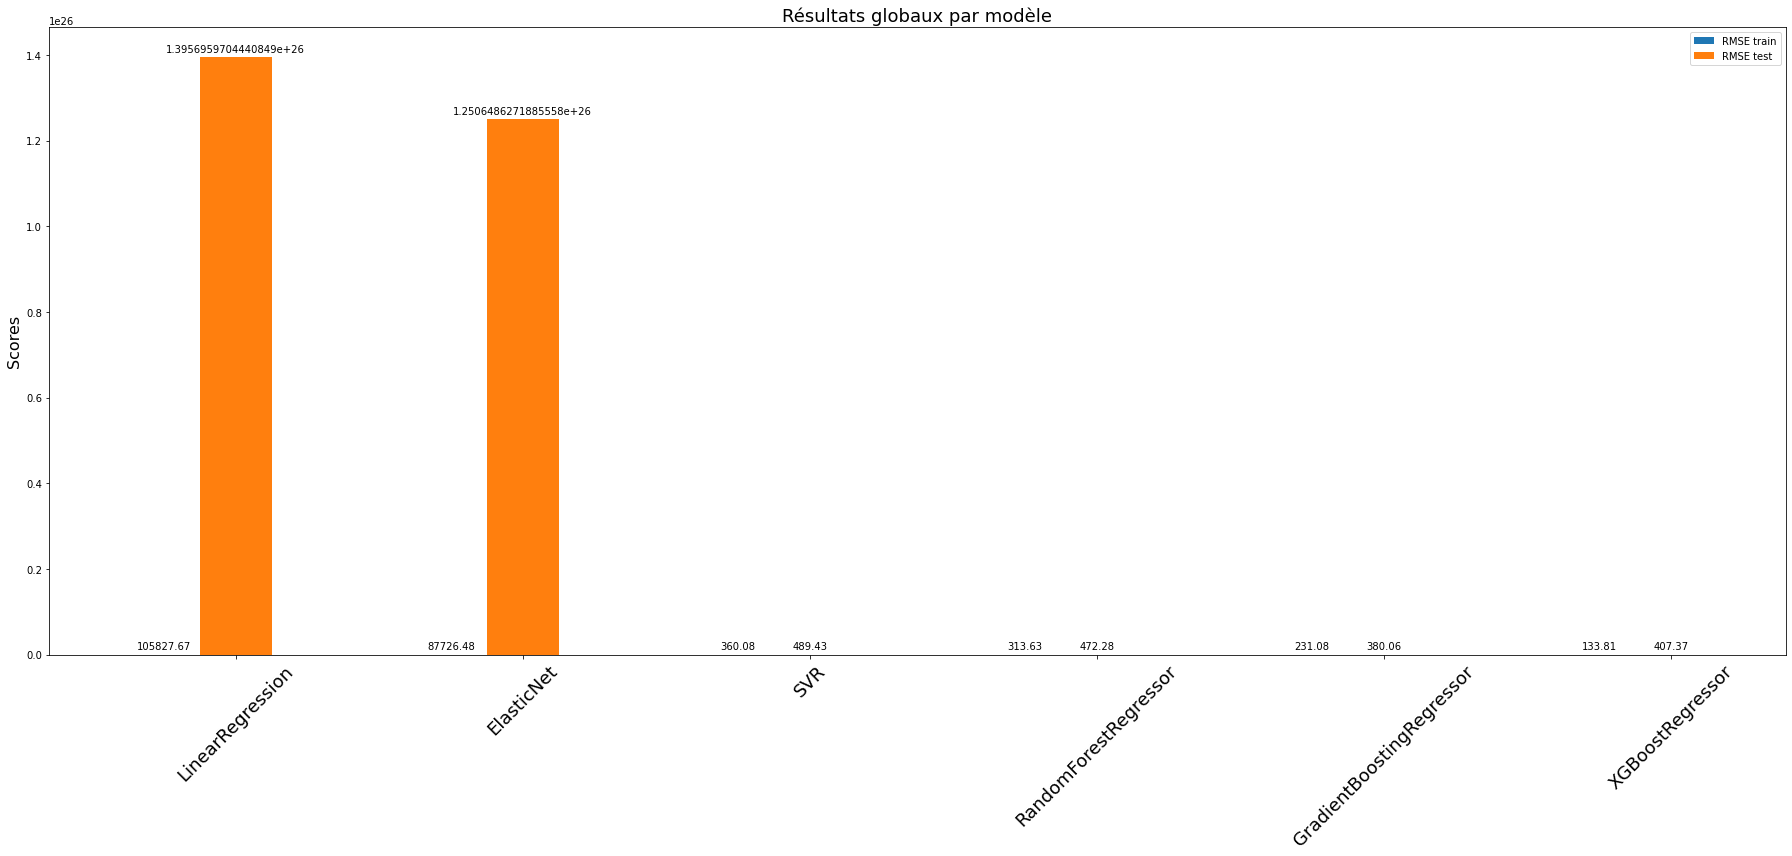

In [3787]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp2_tr, df_results_perf_target2_hyp2_te, 'RMSE')

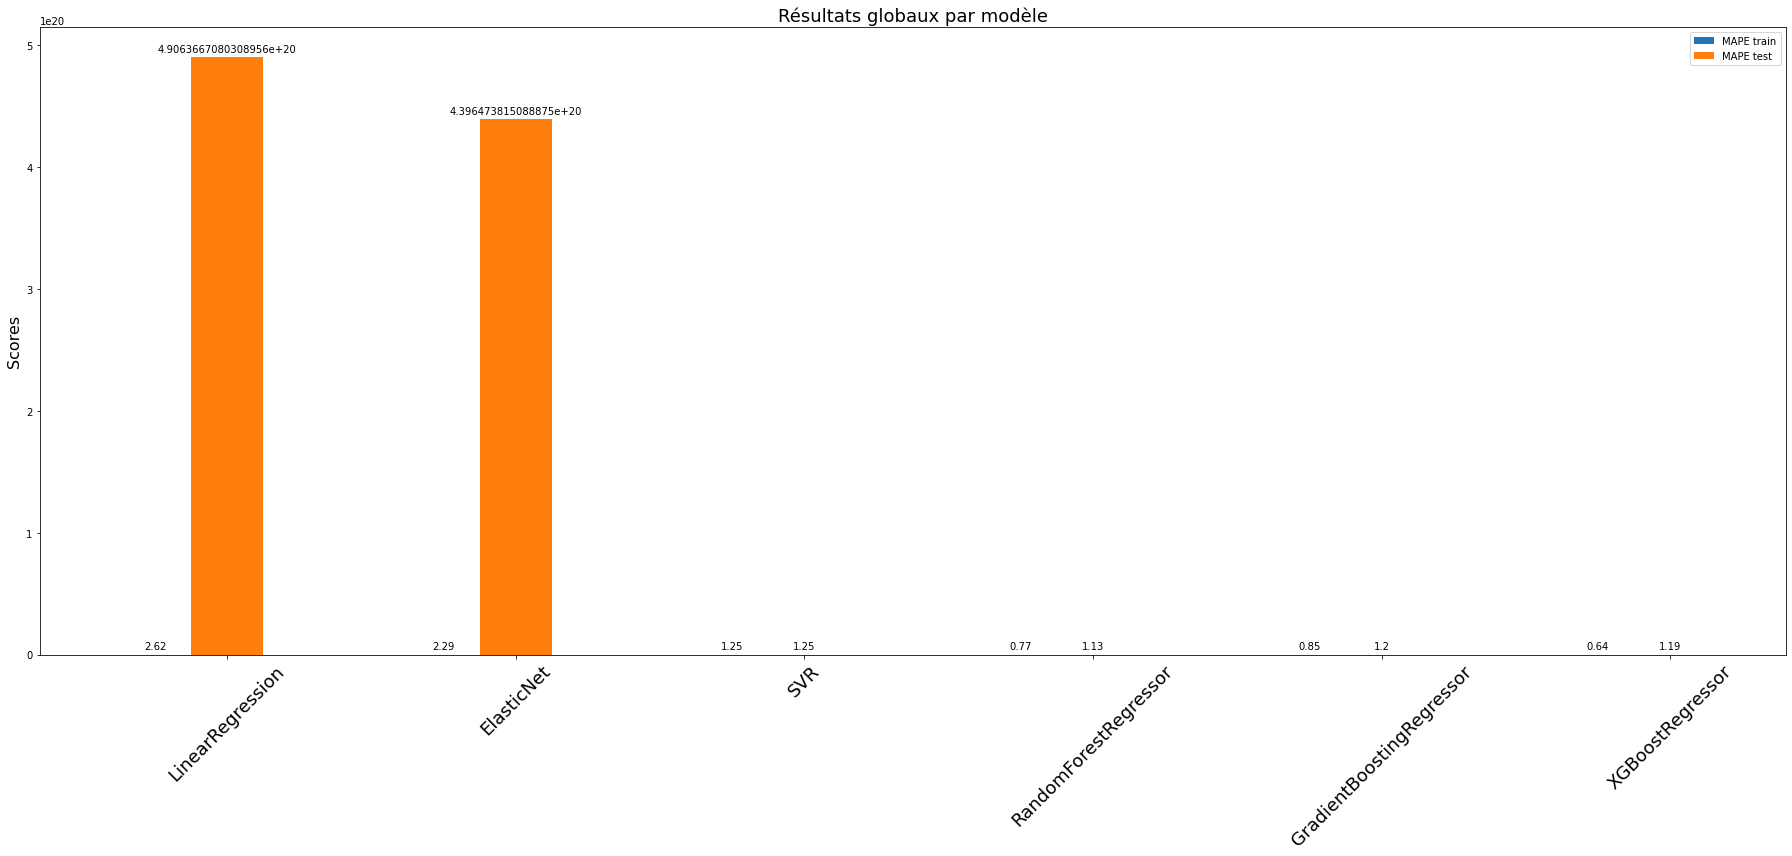

In [3788]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp2_tr, df_results_perf_target2_hyp2_te, 'MAPE')

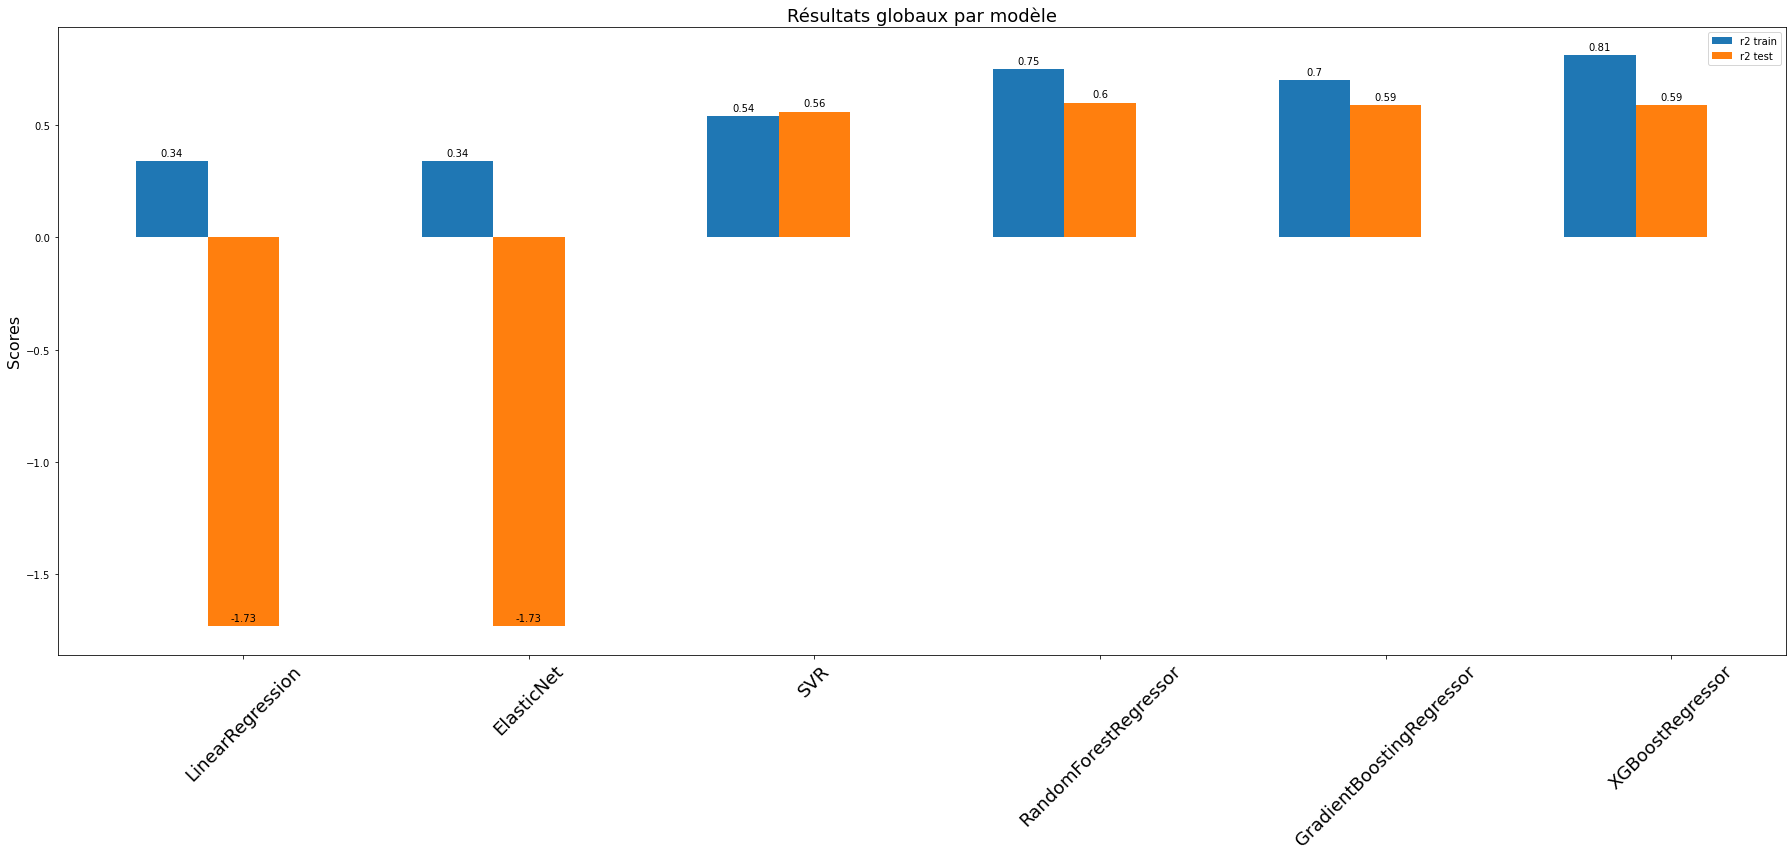

In [3789]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target2_hyp2_tr, df_results_perf_target2_hyp2_te, 'r2')

Le résultat de l'hypothèse 2 est pire que celui de l'hypothèse 1: en effet, le passage à l'échelle logarithmique de la variable cible réduit le sur-apprentissage sur le jeu train, mais la conversion des cette variable aux valeurs réelles dégrade la RMSE.
 
Le jeu de train contient la valeur atypique la plus élevé en valeur réelle.

Sur la métrique de la RMSE, le Gradient Boosting Regressor (GBR) propose la RMSE la plus faible sur le jeu de test (380).
De plus, sur la MAPE, le GBR obtient un taux d'erreur moyen sur le jeu de test (MAPE) de 120 %.

Enfin, le GBR obtient un R² de 0,59 sur le jeu de test.

La baseline (LinearRegression), comme tous les modèles linéaires, semble ne pas être adapté pour cette hypothèse (RMSE = 1.395696e+26).

**Donc, le Gradient Boosting Regressor est le meilleur modèle pour l'hypothèse 2 sur la variable "Total_GHGEmissions_CO2", compte tenu de la métrique RMSE.**

On se rend compte qu'avec l'hypothèse 2, le passage à l'échelle logarithmique de la variable cible permet de limiter le sur-apprentissage sur le jeu de train, mais il y a toujours un impact négatif des valeurs atypiques. Ainsi, on remarque sur les graphes ci-dessous que les erreurs de prédictions sont liées à l'influence néfaste des quelques valeurs atypiques sur la RMSE, ainsi la variance du modèle correspond à 301% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui est mauvais en termes de qualité des prédictions.

Nous allons tester avec l'hypothèse 3, de supprimer les valeurs atypiques sur les variables cible par la méthode des inter-quartiles.

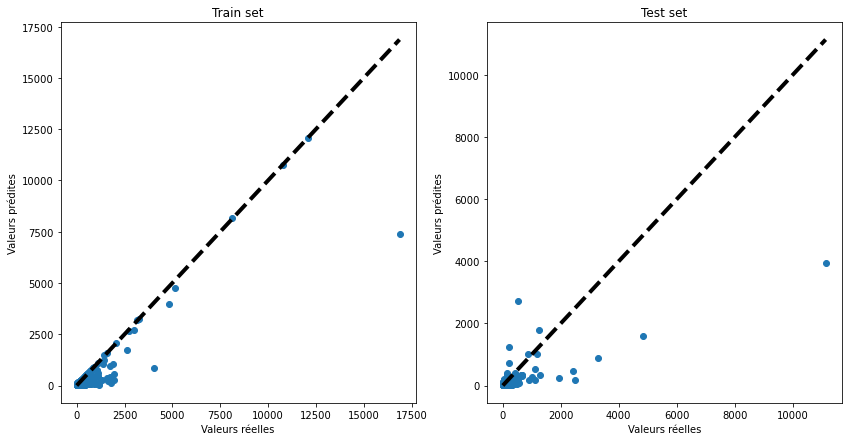

In [3790]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_hyp2_tr[df_results_error_target2_hyp2_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target2_hyp2_tr[df_results_error_target2_hyp2_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

test_values = df_results_error_target2_hyp2_te[df_results_error_target1_hyp2_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target2_hyp2_te[df_results_error_target2_hyp2_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values)

### 5.8 Hypothèse 3: réglage hyper-paramètres, entraînement, prédictions sur les modèles

In [ ]:
# Variables en entrée
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'Distance_harversine','PropertyGFATotal', 'NumberofBuildings', 
               'NumberofFloors']

# Jeu de données en entrée
X_target1_hyp3 = X_std_noout_target1[liste_col_X]
X_target2_hyp3 = X_std_noout_target2[liste_col_X]

In [2929]:
X_target1_hyp3

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,Distance_harversine,PropertyGFATotal,NumberofBuildings,NumberofFloors
0,-0.276391,0.164762,-0.253304,0.252413,1.978927,-0.153221,-0.306671,-1.146547,-0.203785,-0.071133,0.007543
1,0.055793,-0.480173,-0.253304,-0.724330,-1.222779,-0.118290,-0.306671,0.745851,-0.133729,-0.071133,0.007543
3,1.155842,-0.480173,-0.253304,-0.724330,1.799392,0.340777,1.261566,-1.243625,0.729807,-0.071133,0.610764
5,0.128454,0.872099,-0.253304,0.252413,-1.252701,-0.192636,0.988698,-0.057647,0.323178,-0.071133,-0.294068
7,0.408724,-0.480173,-0.253304,-0.724330,0.333190,-0.354330,-0.306671,-0.882821,0.143321,-0.071133,-0.897288
...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.750114,-0.480173,-0.253304,-0.724330,-0.444794,-0.535763,-0.306671,0.829678,-0.766365,-0.071133,-0.897288
3255,-0.803908,-0.480173,-0.253304,-0.724330,-1.103089,-0.544185,-0.306671,-0.989950,-0.808593,-0.071133,-0.897288
3256,-1.004166,-0.128115,-0.253304,1.229156,-0.205414,-0.554775,-0.306671,-0.285788,-0.861691,-0.071133,-0.897288
3257,-1.027530,-0.069565,-0.125345,3.182643,-0.654252,-0.551259,-0.306671,1.030151,-0.844060,-0.071133,-0.897288


In [4772]:
X_target2_hyp3

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,Distance_harversine,PropertyGFATotal,NumberofBuildings,NumberofFloors
0,-0.293171,0.037121,-0.253480,0.233796,2.019592,-0.155762,-0.291236,-1.135438,-0.242580,-0.070823,-0.038325
1,-0.048613,-0.429837,-0.253480,-0.738515,-1.204849,-0.140004,-0.291236,0.765027,-0.192894,-0.070823,-0.038325
2,0.983831,-0.429837,-0.253480,-0.738515,-0.662420,0.107614,-0.291236,-1.143026,0.587879,-0.070823,-0.038325
3,0.761256,-0.429837,-0.253480,-0.738515,1.838782,0.067088,0.798229,-1.232929,0.419559,-0.070823,0.492202
4,1.467184,1.744163,2.259751,3.150731,0.603249,0.296058,1.299837,-0.818603,1.683488,-0.070823,-0.038325
...,...,...,...,...,...,...,...,...,...,...,...
3253,-0.819771,-0.076520,0.597093,2.178419,-0.782959,-0.325326,-0.291236,-0.720116,-0.617886,-0.070823,-0.834115
3254,-0.641931,-0.429837,-0.253480,-0.738515,-0.421340,-0.328332,-0.291236,0.849211,-0.641583,-0.070823,-0.834115
3255,-0.681535,-0.429837,-0.253480,-0.738515,-1.084309,-0.332131,-0.291236,-0.978173,-0.671533,-0.070823,-0.834115
3257,-0.846168,-0.132540,-0.144542,3.150731,-0.632285,-0.335323,-0.291236,1.050538,-0.696688,-0.070823,-0.834115


In [ ]:
# Variable à prédire - variable "SiteEnergyUse(kBtu)"
y_target1_hyp3 = y_noout_target1[['log_SiteEnergyUse(kBtu)']]
y_target1_hyp3

In [3795]:
# Variable à prédire - variable "TotalGHGEmissions_CO2"
y_target2_hyp3 = y_noout_target2[['log_TotalGHGEmissions_CO2']]
y_target2_hyp3

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3253,4.124065
3254,3.060115
3255,3.501646
3257,3.140265


In [ ]:
# Hypothèse testée
id_hyp = 3

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_lr1 = ds_rep + 'LinearRegression_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet1 = ds_rep + 'ElasticNet_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr1 = ds_rep + 'SVR_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr1 = ds_rep + 'RandomForestRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr1 = ds_rep + 'GradientBoostingRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr1 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'

# Variable cible "TotalGHGEmissions_CO2"
fic_lr2 = ds_rep + 'LinearRegression_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet2 = ds_rep + 'ElasticNet_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr2 = ds_rep + 'SVR_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr2 = ds_rep + 'RandomForestRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr2 = ds_rep + 'GradientBoostingRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr2 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'

In [ ]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target1 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr1}},
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet1}},
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr1}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr1}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr1}},
                       
                        'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr1}}}

In [ ]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "TotalGHGEmissions_CO2"
hyper_params_target2 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr2}},
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet2}},
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr2}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr2}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr2}},
                       
                        'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr2}}}

#### 5.8.1 Variable "SiteEnergyUse(kBtu)" - Réglage hyper-paramètres et entraînement modèles

In [3799]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target1_hyp3, X_test_target1_hyp3, y_train_target1_hyp3, y_test_target1_hyp3 = train_test_split(X_target1_hyp3,
                                                                                    y_target1_hyp3,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target1_hyp3.shape))
print('Dimension jeu de données y_train:' + str(y_train_target1_hyp3.shape))
print('Dimension jeu de données X_test:' + str(X_test_target1_hyp3.shape))
print('Dimension jeu de données y_test:' + str(y_test_target1_hyp3.shape))

Dimension jeu de données X_train:(2303, 11)
Dimension jeu de données y_train:(2303, 1)
Dimension jeu de données X_test:(576, 11)
Dimension jeu de données y_test:(576, 1)


In [3802]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_energie_hyp3 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target1_hyp3, X_test_target1_hyp3, y_train_target1_hyp3,y_test_target1_hyp3,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target1, 3, 10)
    
    df_optim_hyperparam_energie_hyp3 = pd.concat([df_optim_hyperparam_energie_hyp3, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  0.6316023048944812

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


D:\Applications\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.4892175812622, tolerance: 158.6128122368607
  model = cd_fast.enet_coordinate_descent(


Optimal hyperparameter combination:  {'alpha': 0.01, 'l1_ratio': 0.0, 'tol': 0.1}
Best score (RMSE):  0.6314383467978659

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Optimal hyperparameter combination:  {'C': 1, 'epsilon': 0.1, 'gamma': 0.1}
Best score (RMSE):  0.5674884008742465

------ Optimisation hyper-paramètres du modèle RandomForestRegressor ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Optimal hyperparameter combination:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}
Best score (RMSE):  0.5593808034358985

------ Optimisation h

In [3803]:
df_optim_hyperparam_energie_hyp3

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,SiteEnergyUse(kBtu),10,{'fit_intercept': True}
1,ElasticNet,SiteEnergyUse(kBtu),10,"{'alpha': 0.01, 'l1_ratio': 0.0, 'tol': 0.1}"
2,SVR,SiteEnergyUse(kBtu),10,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.1}"
3,RandomForestRegressor,SiteEnergyUse(kBtu),10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}"
4,GradientBoostingRegressor,SiteEnergyUse(kBtu),10,"{'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}"
5,XGBoostRegressor,SiteEnergyUse(kBtu),10,"{'max_depth': 4, 'n_estimators': 100}"


#### 5.8.2 Variable "SiteEnergyUse(kBtu)" - Prédictions 

In [3804]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target1_hyp3_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target1_hyp3_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target1_hyp3_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target1_hyp3_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target1:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target1_hyp3, y_train_target1_hyp3, X_test_target1_hyp3, y_test_target1_hyp3, 
                  hyper_params_target1[model_hyper_param]['regressor']['model'],
                  hyper_params_target1[model_hyper_param]['regressor']['model_txt'],
                  3, hyper_params_target1[model_hyper_param]['regressor']['fic_hyperparam'],target1, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target1_hyp3_tr = pd.concat([df_results_error_target1_hyp3_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target1_hyp3_te = pd.concat([df_results_error_target1_hyp3_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target1_hyp3_tr = pd.concat([df_results_perf_target1_hyp3_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target1_hyp3_te = pd.concat([df_results_perf_target1_hyp3_te, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_SiteEnergyUse(kBtu)_hyph3_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.43
Train RMSE:  2502423.13
Train MAPE:  0.57

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearReg

D:\Applications\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.4892175812622, tolerance: 158.6128122368607
  model = cd_fast.enet_coordinate_descent(



-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: SVR
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/SVR_SiteEnergyUse(kBtu)_hyph3_optim_params.pkl
Hyper-paramètres optimisés: {'C': 1, 'epsilon': 0.1, 'gamma': 0.1}
Prédictions avec les paramètres suivants du modèle:
{'C': 1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle SVR sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.58
Train RMSE:  1269863.8
Train MAPE:  0.44

--------------------------------------------------------------------------------------

D:\Applications\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [3805]:
df_results_error_target1_hyp3_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,3,SiteEnergyUse(kBtu),Train,4.885051e+06,1.419996e+06,3.465054e+06,70.93
1,LinearRegression,3,SiteEnergyUse(kBtu),Train,5.932035e+06,4.098307e+06,1.833728e+06,30.91
2,LinearRegression,3,SiteEnergyUse(kBtu),Train,1.942320e+06,1.585383e+06,3.569365e+05,18.38
3,LinearRegression,3,SiteEnergyUse(kBtu),Train,1.589148e+06,2.034046e+06,4.448979e+05,28.00
4,LinearRegression,3,SiteEnergyUse(kBtu),Train,2.529024e+06,2.158124e+06,3.708997e+05,14.67
...,...,...,...,...,...,...,...,...
13813,XGBoostRegressor,3,SiteEnergyUse(kBtu),Train,1.870702e+06,1.361706e+06,5.089961e+05,27.21
13814,XGBoostRegressor,3,SiteEnergyUse(kBtu),Train,1.389924e+06,1.744747e+06,3.548233e+05,25.53
13815,XGBoostRegressor,3,SiteEnergyUse(kBtu),Train,2.526799e+06,2.777594e+06,2.507956e+05,9.93
13816,XGBoostRegressor,3,SiteEnergyUse(kBtu),Train,2.662691e+06,3.316926e+06,6.542351e+05,24.57


In [3806]:
df_results_error_target1_hyp3_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,3,SiteEnergyUse(kBtu),Test,3.340587e+06,2.679901e+06,6.606863e+05,19.78
1,LinearRegression,3,SiteEnergyUse(kBtu),Test,6.456654e+05,7.615310e+05,1.158656e+05,17.95
2,LinearRegression,3,SiteEnergyUse(kBtu),Test,1.046829e+06,1.631540e+06,5.847114e+05,55.86
3,LinearRegression,3,SiteEnergyUse(kBtu),Test,8.537984e+06,4.174107e+06,4.363877e+06,51.11
4,LinearRegression,3,SiteEnergyUse(kBtu),Test,2.018054e+06,1.343857e+06,6.741968e+05,33.41
...,...,...,...,...,...,...,...,...
3451,XGBoostRegressor,3,SiteEnergyUse(kBtu),Test,2.154448e+06,7.432509e+05,1.411197e+06,65.50
3452,XGBoostRegressor,3,SiteEnergyUse(kBtu),Test,3.076461e+06,2.893071e+06,1.833895e+05,5.96
3453,XGBoostRegressor,3,SiteEnergyUse(kBtu),Test,3.344740e+06,2.841165e+06,5.035751e+05,15.06
3454,XGBoostRegressor,3,SiteEnergyUse(kBtu),Test,6.153499e+05,7.796040e+05,1.642541e+05,26.69


In [3808]:
df_results_perf_target1_hyp3_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,3,SiteEnergyUse(kBtu),Train,0.43,2502423.13,0.57
1,ElasticNet,3,SiteEnergyUse(kBtu),Train,0.43,2485447.66,0.57
2,SVR,3,SiteEnergyUse(kBtu),Train,0.58,1269863.80,0.44
3,RandomForestRegressor,3,SiteEnergyUse(kBtu),Train,0.77,1022738.32,0.31
4,GradientBoostingRegressor,3,SiteEnergyUse(kBtu),Train,0.63,1264327.34,0.39
5,XGBoostRegressor,3,SiteEnergyUse(kBtu),Train,0.84,912230.65,0.25


In [3809]:
df_results_perf_target1_hyp3_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,3,SiteEnergyUse(kBtu),Test,0.38,2896216.26,0.61
1,ElasticNet,3,SiteEnergyUse(kBtu),Test,0.39,2852566.81,0.60
2,SVR,3,SiteEnergyUse(kBtu),Test,0.52,1379770.64,0.49
3,RandomForestRegressor,3,SiteEnergyUse(kBtu),Test,0.53,1328788.33,0.48
4,GradientBoostingRegressor,3,SiteEnergyUse(kBtu),Test,0.53,1341515.24,0.47
5,XGBoostRegressor,3,SiteEnergyUse(kBtu),Test,0.48,1346997.59,0.53


In [3810]:
# Valeur max cible test
np.expm1(y_test_target1_hyp3.max())

log_SiteEnergyUse(kBtu)    9124367.0
dtype: float64

In [3811]:
# Valeur moyenne cible test
df_results_error_target1_hyp3_te[df_results_error_target1_hyp3_te['Modeles'] ==
                                                'SVR'][['y']].mean()

y    2.187438e+06
dtype: float64

In [3812]:
# Valeur max cible train
np.expm1(y_train_target1_hyp3.max())

log_SiteEnergyUse(kBtu)    9215900.5
dtype: float64

In [3813]:
# Valeur moyenne cible train
df_results_error_target1_hyp3_tr[df_results_error_target1_hyp3_tr['Modeles'] ==
                                                'SVR'][['y']].mean()

y    2.293467e+06
dtype: float64

#### 5.8.3 Variable "SiteEneryUse(kBtu)"  - Affichage métriques  et choix du modéle

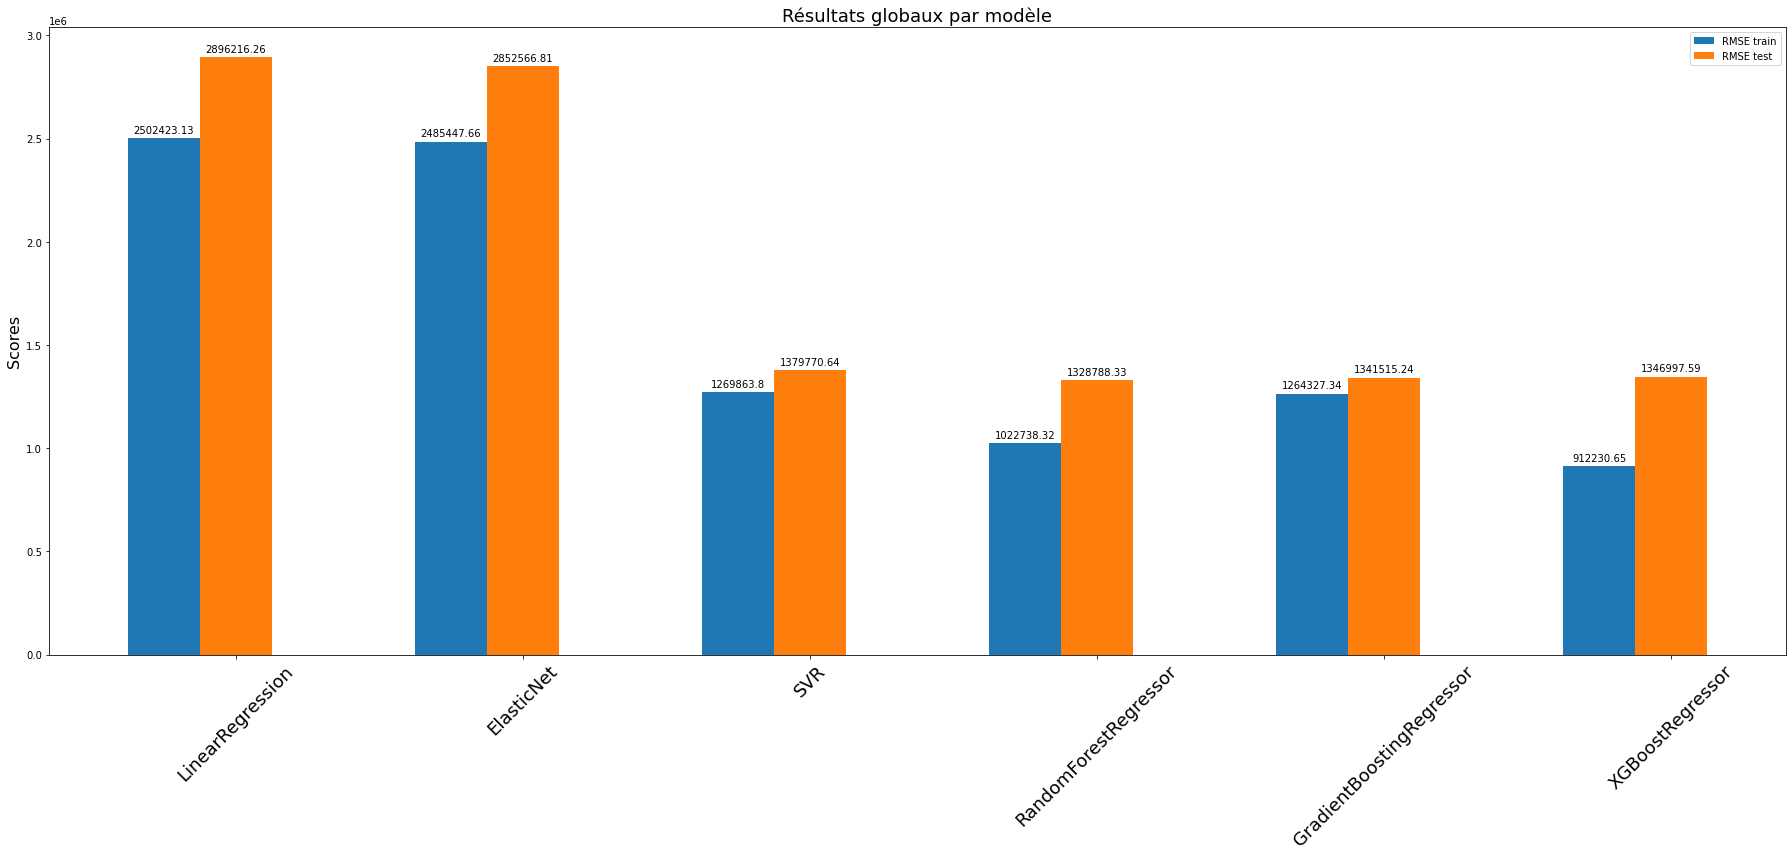

In [3814]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp3_tr, df_results_perf_target1_hyp3_te, 'RMSE')

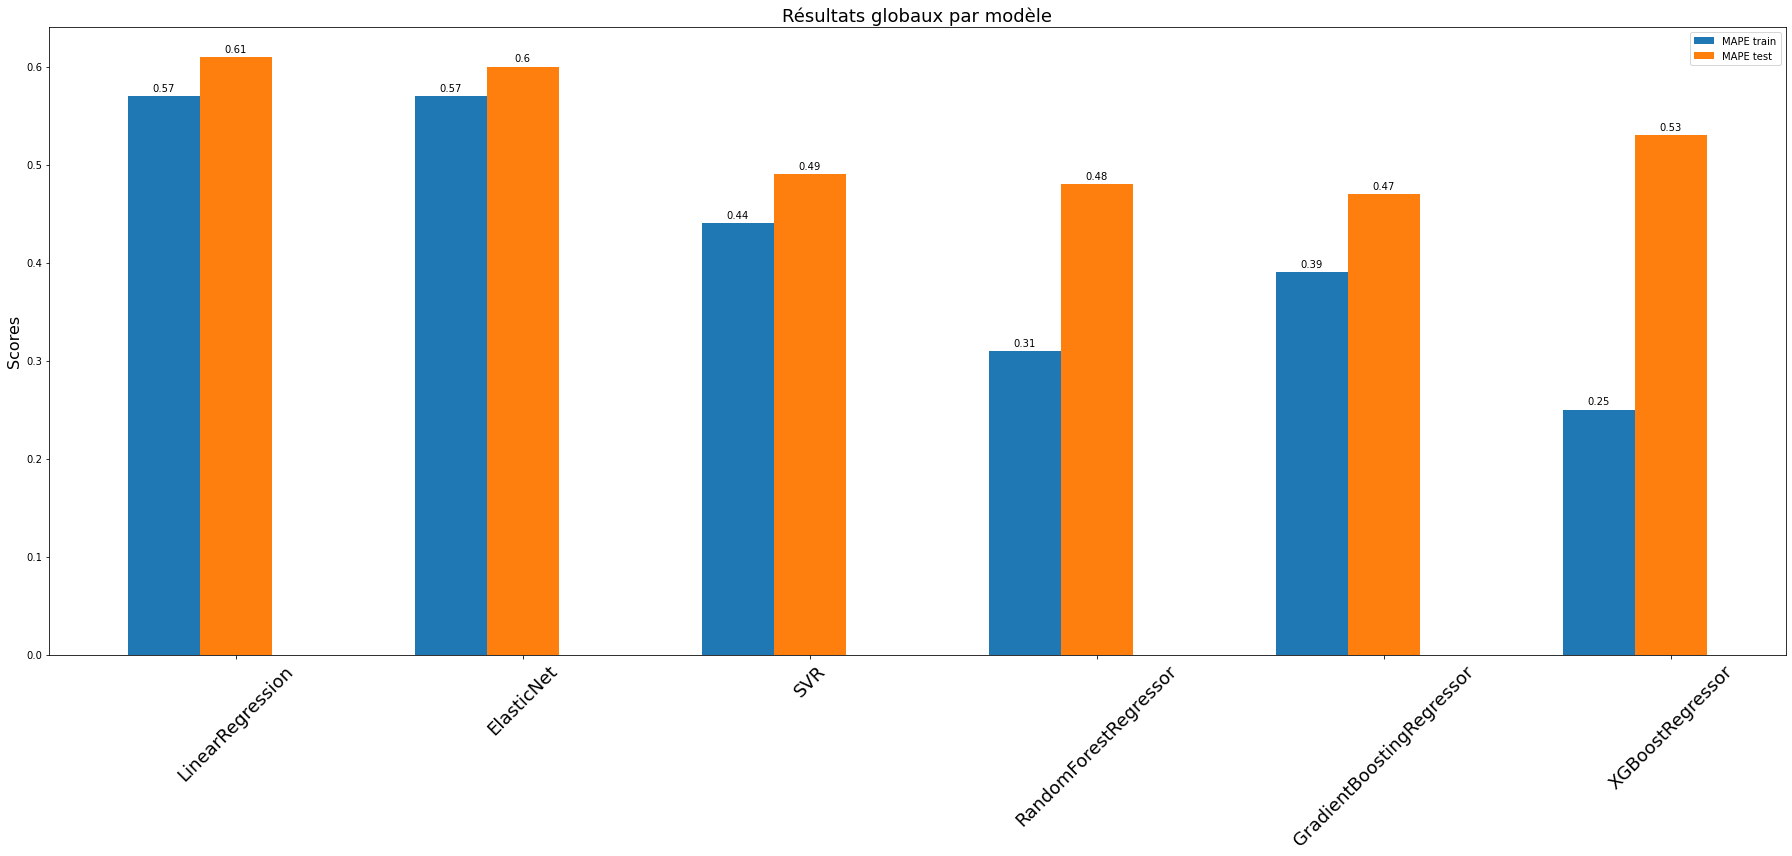

In [3815]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp3_tr, df_results_perf_target1_hyp3_te, 'MAPE')

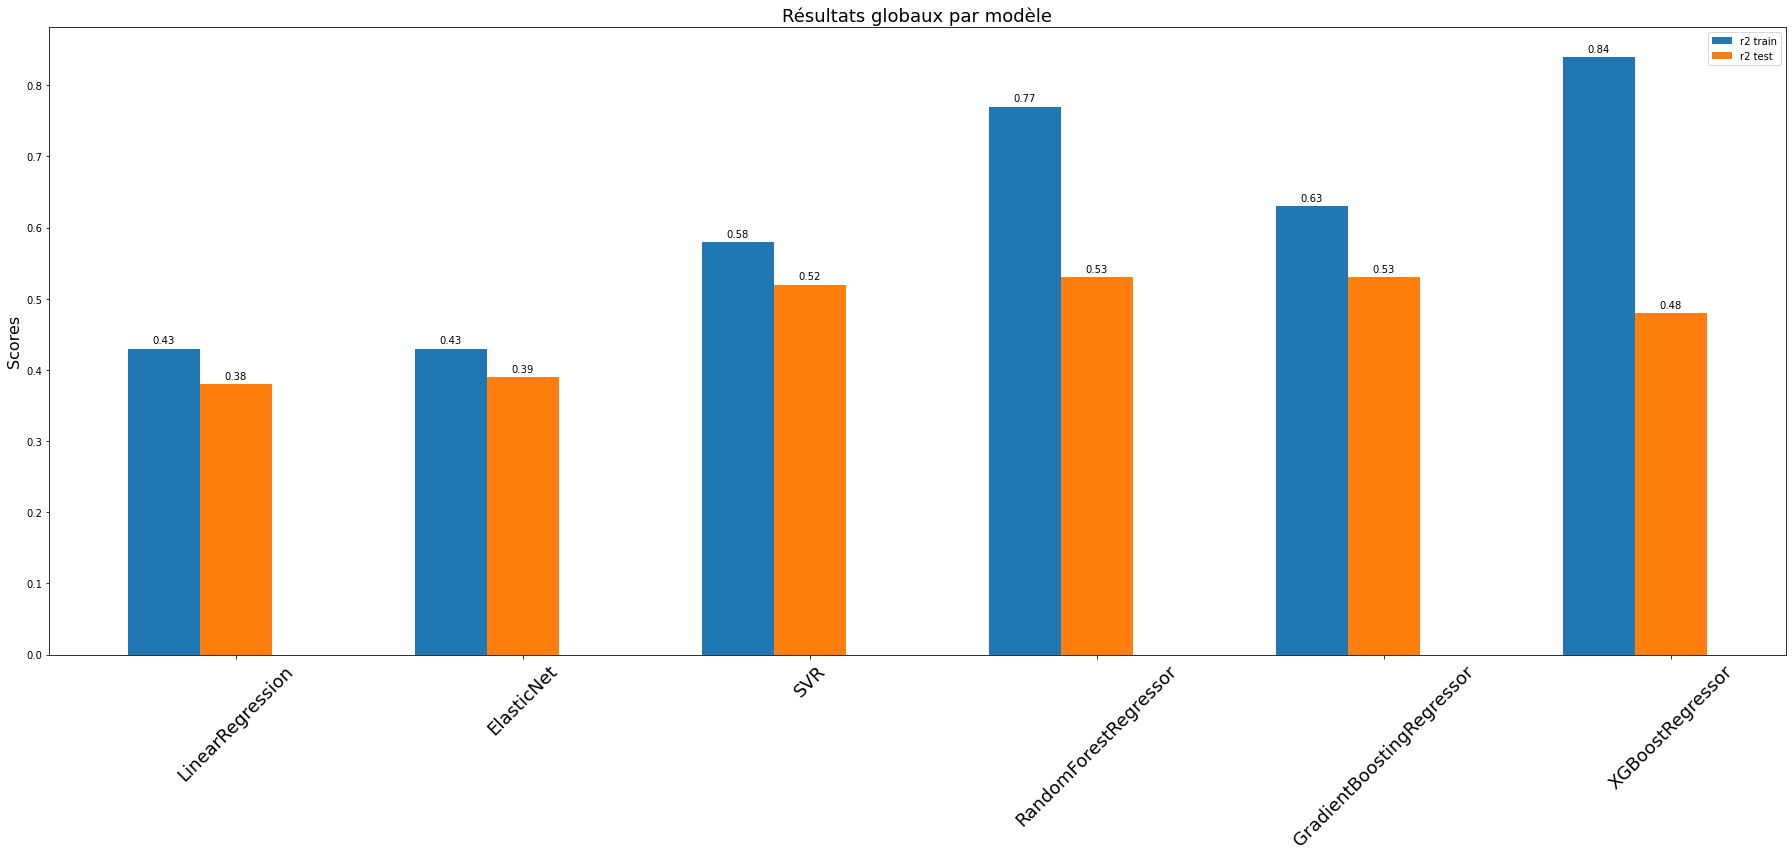

In [3816]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target1_hyp3_tr, df_results_perf_target1_hyp3_te, 'r2')

**L'hypothèse 3 semble mieux convenir que les 2 premières hypothèses pour la variable "SiteEnergyUse(kBty)", surtout pour les modèles SVR, RFR, GBR et XGR. On remarque toutefois un sur-apprentissage pour ces modèles sur le jeu de train.**

Sur la métrique de la RMSE, le Random Forest Regressor (RFR) propose la RMSE la plus faible sur le jeu de test (1328788).
De plus, sur la MAPE, le GBR est à égalité avec RFR avec un taux d'erreur moyen sur le jeu de test de 48%.

Enfin, le RFR obtient le R² le plus élévé sur le jeu de test (0,53), comme le GBR.

**Donc, le Random Forest Regressor est le meilleur modèle pour l'hypothèse 3 sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

En éliminant les valeurs atypiques, nous obtenons les meilleurs RMSE, tous modèles confondus. Le retrait des valeurs atypiques améliore fortement la RMSE, mais quand on convertit les résultats en valeurs réelles, il y a toujours des valeurs qui sont sous-estimées.
La variance du modèle correspond à 60% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité moyenne des prédictions.

Toutefois, il faut remarquer que dans cette hypothèse, les prédictions ne seront pas pertinentes si le jeu de données présente des valeurs atypiques (environ 11% du jeu de données d'origine).

On s'aperçoit que les 11% de valeurs atypique pour cette variable Consommation d'énergie représente environ 86% de la RMSE totale.  

Nous allons tester avec l'hypothèse 4, l'ajout de variables qualitatives (encodage OneHot), passage de 11 variables à 29 variables en entrée.

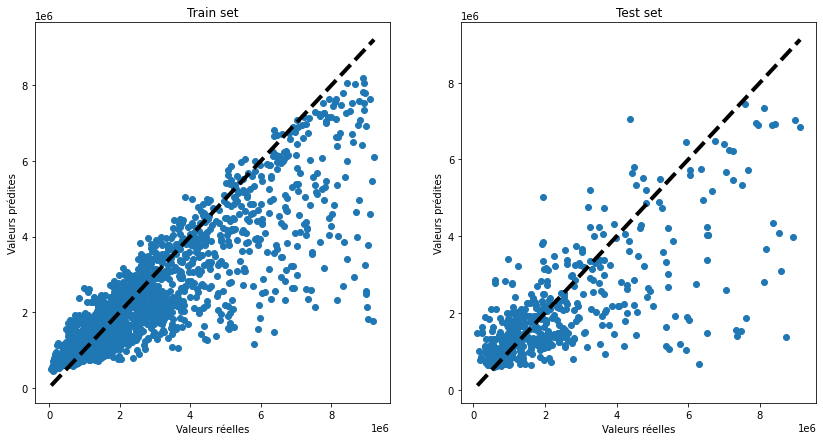

In [3817]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target1_hyp3_tr[df_results_error_target1_hyp3_tr['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

train_pred_values = df_results_error_target1_hyp3_tr[df_results_error_target1_hyp3_tr['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

test_values = df_results_error_target1_hyp3_te[df_results_error_target1_hyp3_te['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

test_pred_values = df_results_error_target1_hyp3_te[df_results_error_target1_hyp3_te['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values)

#### 5.8.4 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [ ]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target2_hyp3, X_test_target2_hyp3, y_train_target2_hyp3, y_test_target2_hyp3 = train_test_split(X_target2_hyp3,
                                                                                    y_target2_hyp3,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2_hyp3.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2_hyp3.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2_hyp3.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2_hyp3.shape))

In [4791]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_hyp3 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2_hyp3, X_test_target2_hyp3, y_train_target2_hyp3,y_test_target2_hyp3,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target2, 3, 10)
    
    df_optim_hyperparam_co2_hyp3 = pd.concat([df_optim_hyperparam_co2_hyp3, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  0.9832983080377804

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
Optimal hyperparameter combination:  {'alpha': 0.01, 'l1_ratio': 0.7000000000000001, 'tol': 0.0001}
Best score (RMSE):  0.9819824309681344

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
------------------------------------

In [4792]:
df_optim_hyperparam_co2_hyp3

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,TotalGHGEmissions_CO2,10,{'fit_intercept': True}
1,ElasticNet,TotalGHGEmissions_CO2,10,"{'alpha': 0.01, 'l1_ratio': 0.7000000000000001, 'tol': 0.0001}"
2,SVR,TotalGHGEmissions_CO2,10,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.1}"
3,RandomForestRegressor,TotalGHGEmissions_CO2,10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}"
4,GradientBoostingRegressor,TotalGHGEmissions_CO2,10,"{'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 4}"
5,XGBoostRegressor,TotalGHGEmissions_CO2,10,"{'max_depth': 4, 'n_estimators': 100}"


#### 5.8.5 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [4793]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_hyp3_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_hyp3_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_hyp3_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_hyp3_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target2_hyp3, y_train_target2_hyp3, X_test_target2_hyp3, y_test_target2_hyp3, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  3, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_hyp3_tr = pd.concat([df_results_error_target2_hyp3_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_hyp3_te = pd.concat([df_results_error_target2_hyp3_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_hyp3_tr = pd.concat([df_results_perf_target2_hyp3_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_hyp3_te = pd.concat([df_results_perf_target2_hyp3_te, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_TotalGHGEmissions_CO2_hyph3_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.28
Train RMSE:  58.03
Train MAPE:  1.3

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegress

In [4794]:
df_results_error_target2_hyp3_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,3,TotalGHGEmissions_CO2,Train,5.960,28.231152,22.271152,373.68
1,LinearRegression,3,TotalGHGEmissions_CO2,Train,30.755,27.496110,3.258890,10.60
2,LinearRegression,3,TotalGHGEmissions_CO2,Train,9.605,21.668052,12.063052,125.59
3,LinearRegression,3,TotalGHGEmissions_CO2,Train,46.970,72.803702,25.833702,55.00
4,LinearRegression,3,TotalGHGEmissions_CO2,Train,8.840,17.547248,8.707248,98.50
...,...,...,...,...,...,...,...,...
13945,XGBoostRegressor,3,TotalGHGEmissions_CO2,Train,3.730,11.642529,7.912529,212.13
13946,XGBoostRegressor,3,TotalGHGEmissions_CO2,Train,110.840,93.684151,17.155849,15.48
13947,XGBoostRegressor,3,TotalGHGEmissions_CO2,Train,18.900,28.455326,9.555326,50.56
13948,XGBoostRegressor,3,TotalGHGEmissions_CO2,Train,78.025,53.862541,24.162459,30.97


In [4795]:
df_results_error_target2_hyp3_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,3,TotalGHGEmissions_CO2,Test,159.640,37.644862,121.995138,76.42
1,LinearRegression,3,TotalGHGEmissions_CO2,Test,24.730,22.910500,1.819500,7.36
2,LinearRegression,3,TotalGHGEmissions_CO2,Test,9.805,18.533673,8.728673,89.02
3,LinearRegression,3,TotalGHGEmissions_CO2,Test,6.915,32.012579,25.097579,362.94
4,LinearRegression,3,TotalGHGEmissions_CO2,Test,39.600,19.581960,20.018040,50.55
...,...,...,...,...,...,...,...,...
3487,XGBoostRegressor,3,TotalGHGEmissions_CO2,Test,4.790,6.622519,1.832519,38.26
3488,XGBoostRegressor,3,TotalGHGEmissions_CO2,Test,36.025,22.866022,13.158978,36.53
3489,XGBoostRegressor,3,TotalGHGEmissions_CO2,Test,121.560,34.960644,86.599356,71.24
3490,XGBoostRegressor,3,TotalGHGEmissions_CO2,Test,12.205,8.735709,3.469291,28.43


In [4796]:
df_results_perf_target2_hyp3_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,3,TotalGHGEmissions_CO2,Train,0.28,58.03,1.30
1,ElasticNet,3,TotalGHGEmissions_CO2,Train,0.28,56.31,1.30
2,SVR,3,TotalGHGEmissions_CO2,Train,0.44,39.01,1.05
3,RandomForestRegressor,3,TotalGHGEmissions_CO2,Train,0.72,31.80,0.66
4,GradientBoostingRegressor,3,TotalGHGEmissions_CO2,Train,0.75,31.01,0.60
5,XGBoostRegressor,3,TotalGHGEmissions_CO2,Train,0.79,28.21,0.51


In [4797]:
df_results_perf_target2_hyp3_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,3,TotalGHGEmissions_CO2,Test,0.25,44.29,1.21
1,ElasticNet,3,TotalGHGEmissions_CO2,Test,0.25,45.21,1.21
2,SVR,3,TotalGHGEmissions_CO2,Test,0.36,38.55,0.99
3,RandomForestRegressor,3,TotalGHGEmissions_CO2,Test,0.44,36.90,1.01
4,GradientBoostingRegressor,3,TotalGHGEmissions_CO2,Test,0.35,37.76,1.11
5,XGBoostRegressor,3,TotalGHGEmissions_CO2,Test,0.33,38.93,1.14


In [4777]:
# Variable max cible test
np.expm1(y_test_target2_hyp3.max())

log_TotalGHGEmissions_CO2    214.945
dtype: float64

In [4798]:
# Valeur moyenne cible test
df_results_error_target2_hyp3_te[df_results_error_target2_hyp3_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    42.259716
dtype: float64

In [4778]:
# Variable max cible train
np.expm1(y_train_target2_hyp3.max())

log_TotalGHGEmissions_CO2    216.39
dtype: float64

In [4018]:
# Varaible moyenne cible train
df_results_error_target2_hyp3_tr[df_results_error_target2_hyp3_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    45.809802
dtype: float64

#### 5.8.6 Variable "TotalGHGEmissions_CO2"  - Affichage métriques  et choix du modéle

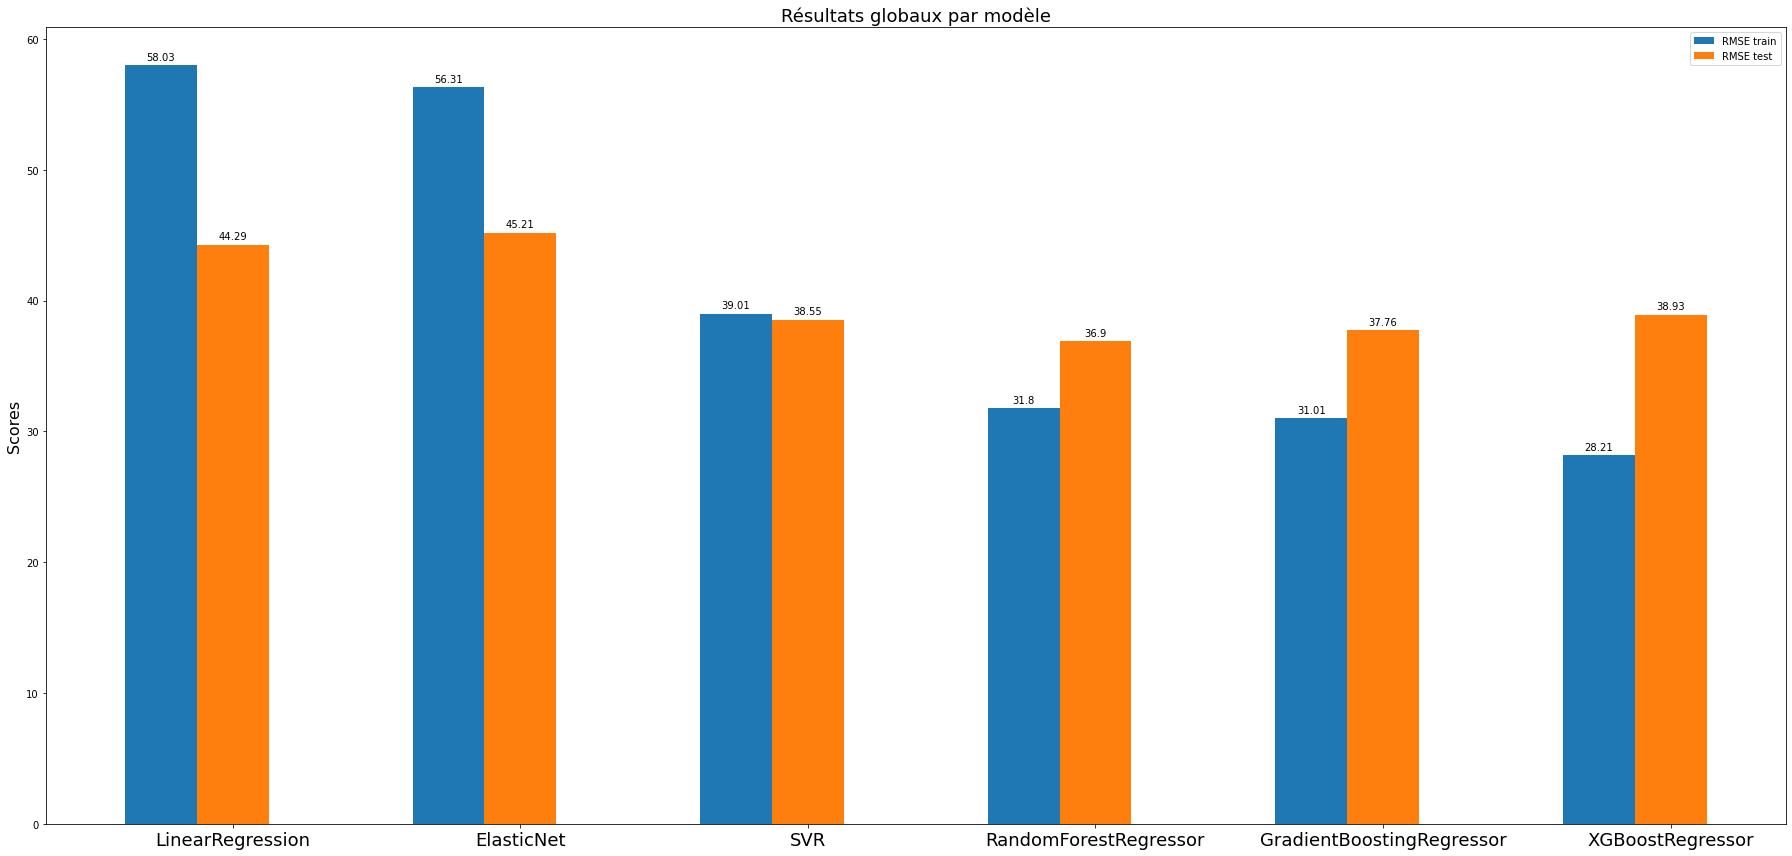

In [4799]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp3_tr, df_results_perf_target2_hyp3_te, 'RMSE')

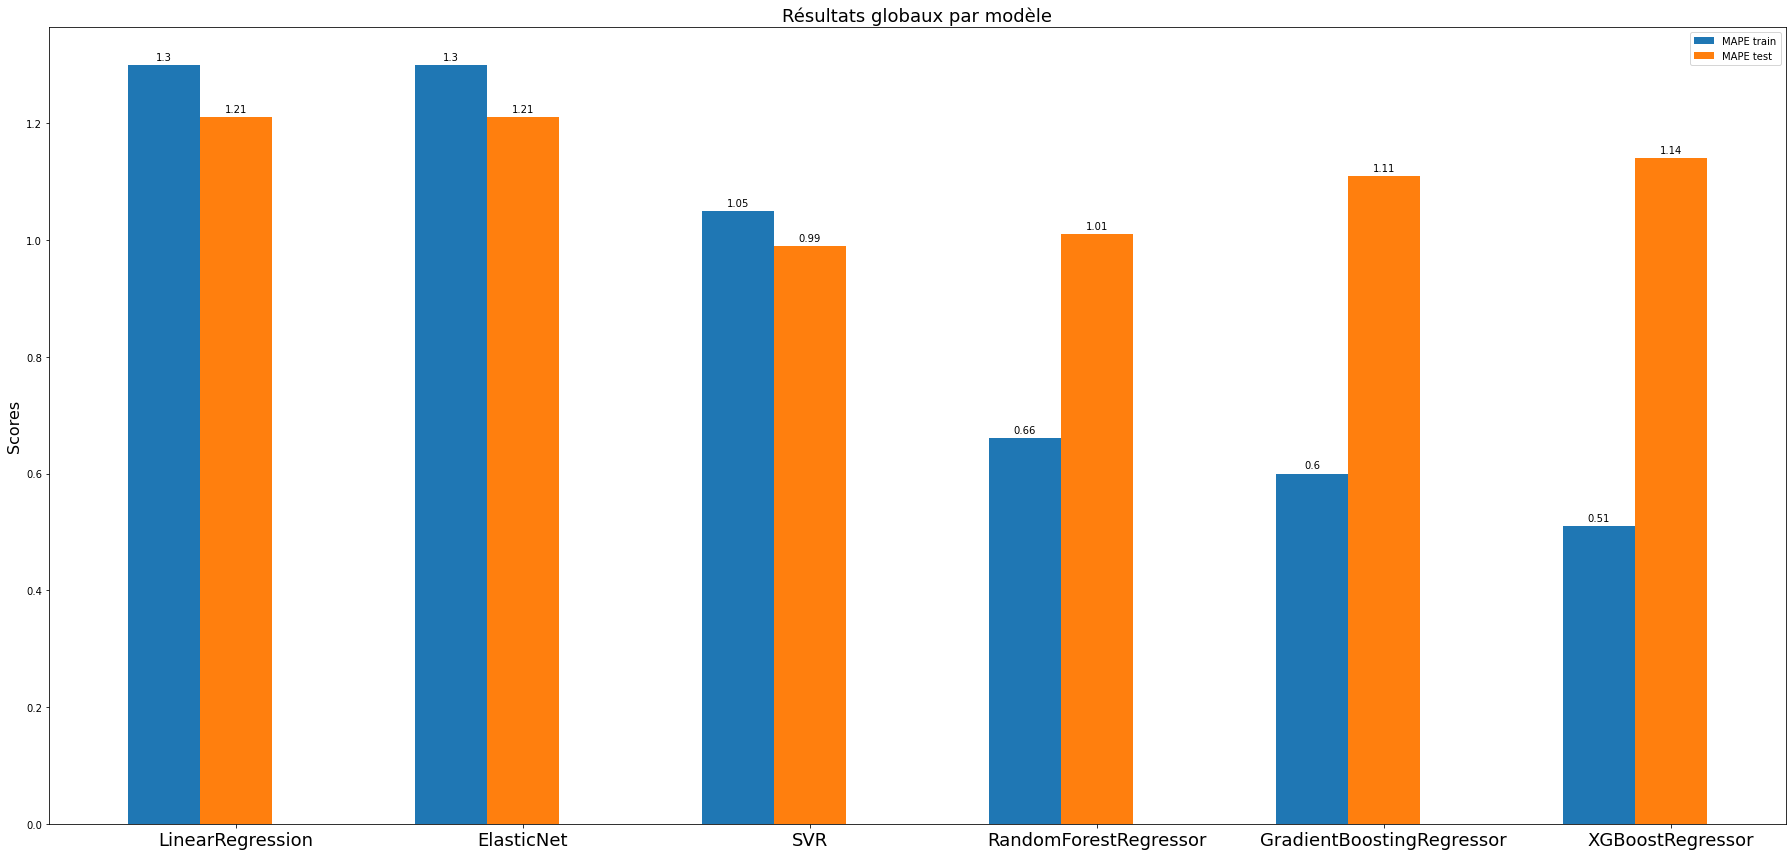

In [4800]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp3_tr, df_results_perf_target2_hyp3_te, 'MAPE')

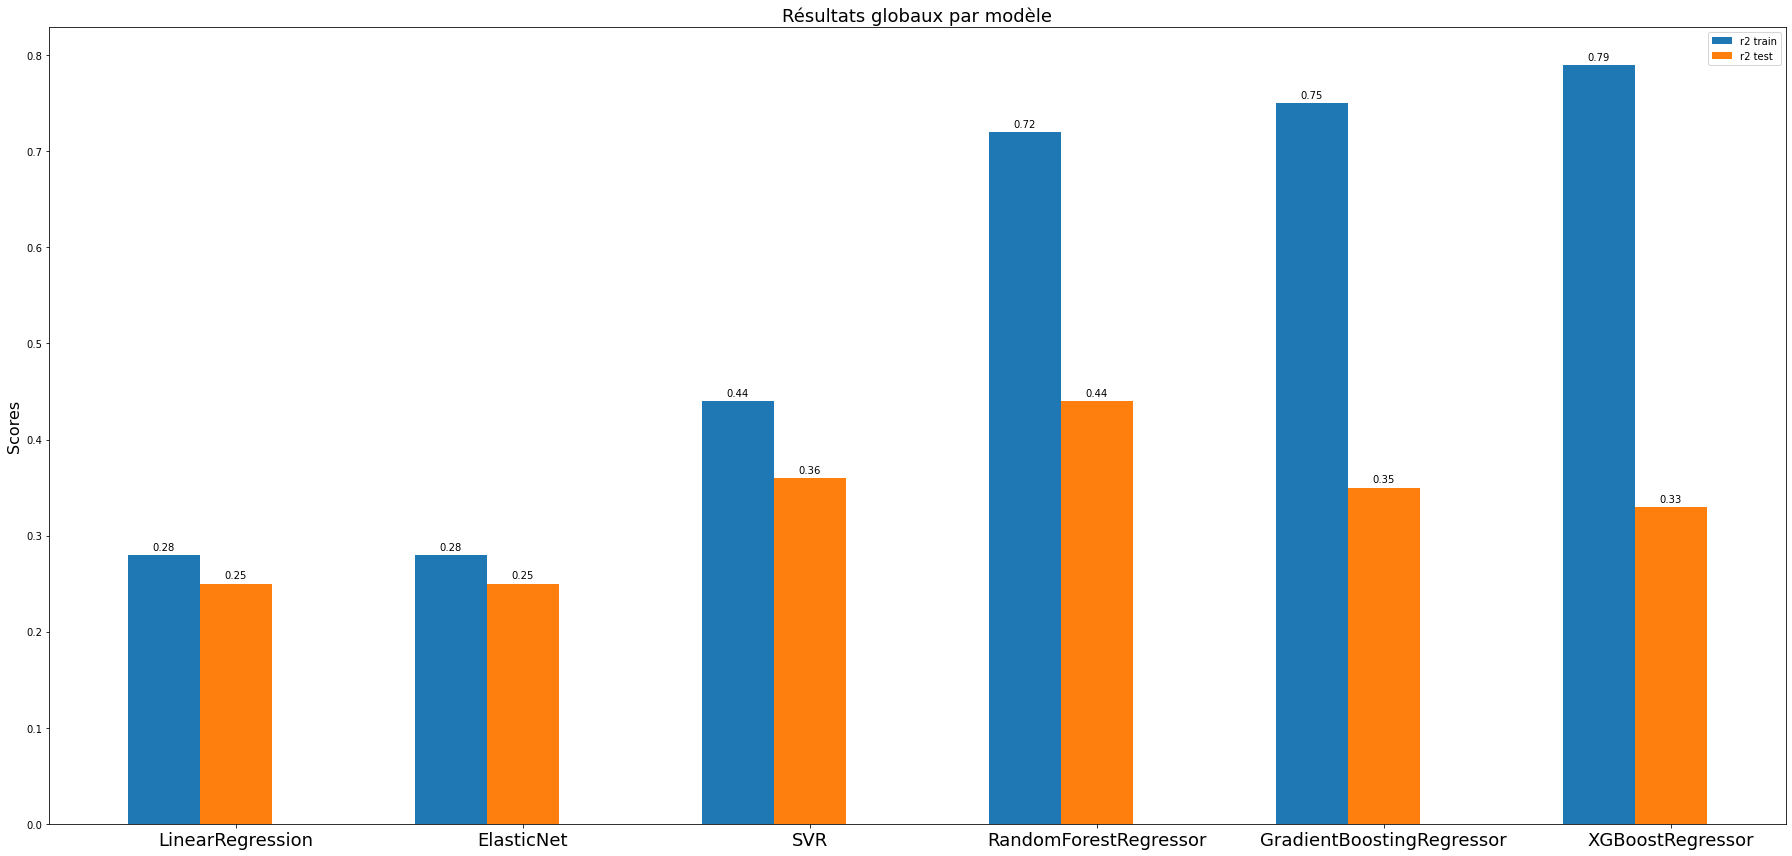

In [4802]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target2_hyp3_tr, df_results_perf_target2_hyp3_te, 'r2')

Sur la métrique de la RMSE, le Gradient Boosting Regressor (GBR) propose la RMSE la plus faible sur le jeu de test (38.86).
Par contre, sur la MAPE, on obtient un taux d'erreur moyen sur le jeu de test de 111%.

Enfin, le RFR obtient un R² de 0,41 sur le jeu de test.

**Donc, le Gradient Boosting Regressor est le meilleur modèle pour l'hypothèse 2 sur la variable "TotalGHGEmissions-CO2", compte tenu de la métrique RMSE.**

On peut remarquer que les modèles font du sur-apprentissage sur le jeu de train et ne permet pas de généraliser le modèle sur un jeu inédit.

En éliminant les valeurs atypiques, nous obtenons les meilleurs RMSE, tous modèles confondus. Le retrait des valeurs atypiques améliore fortement la RMSE, mais quand on convertit les résultats en valeurs réelles, il y a toujours des valeurs qui sont sous-estimées.
La variance du modèle correspond à 86% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité médiocre des prédictions.

Toutefois, il faut remarquer que dans cette hypothèse, les prédictions ne seront pas pertinentes si le jeu de données présente des valeurs atypiques (environ 11% du jeu de données d'origine).

On s'aperçoit que les 11% de valeurs atypique pour cette variable Emissions de CO2 représente environ 88% de la RMSE totale.  

Nous allons tester avec l'hypothèse 4, l'ajout de variables qualitatives (encodage OneHot), passage de 11 variables à 29 variables en entrée.

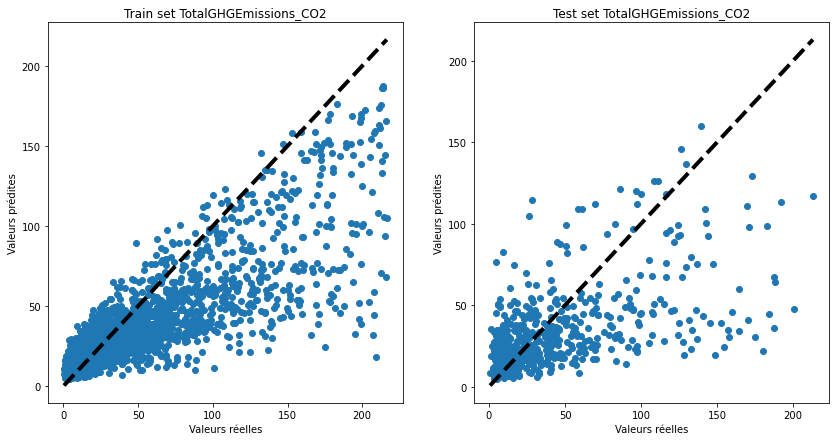

In [4804]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_hyp3_tr[df_results_error_target2_hyp3_tr['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

train_pred_values = df_results_error_target2_hyp3_tr[df_results_error_target2_hyp3_tr['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

test_values = df_results_error_target2_hyp3_te[df_results_error_target2_hyp3_te['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

test_pred_values = df_results_error_target2_hyp3_te[df_results_error_target2_hyp3_te['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target2)

### 5.9 Hypothèse 4: réglage hyper-paramètres, entraînement, prédictions sur les modèles

In [116]:
# Variables en entrée
X_target1_energystar_hyp4 = X_std_noout_target1[['EnergyStar']]
X_target2_energystar_hyp4 = X_std_noout_target2[['EnergyStar']]

# Jeu de données en entrée
X_target1_hyp4 = X_std_noout_target1.drop(columns=['EnergyStar','Electricity','SteamUse','NaturalGas'])
X_target2_hyp4 = X_std_noout_target2.drop(columns=['EnergyStar','Electricity','SteamUse','NaturalGas'])

In [117]:
X_target1_energystar_hyp4

,EnergyStar
0,0.292022
1,0.732213
3,-1.028553
5,0.336041
7,-2.965395
...,...
3254,-0.011710
3255,-0.011710
3256,-0.011710
3257,-0.011710


In [120]:
X_target2_energystar_hyp4

,EnergyStar
0,0.292531
1,0.730103
2,0.992645
3,-1.020182
4,-0.407582
...,...
3253,-0.009393
3254,-0.009393
3255,-0.009393
3257,-0.009393


In [158]:
X_target1_hyp4

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,-0.276391,0.164762,-0.253304,0.252413,1.978927,-0.153221,-0.306671,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.579088,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,-1.146547,-0.071133,0.007543,-0.203785
1,0.055793,-0.480173,-0.253304,-0.724330,-1.222779,-0.118290,-0.306671,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.579088,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,0.745851,-0.071133,0.007543,-0.133729
3,1.155842,-0.480173,-0.253304,-0.724330,1.799392,0.340777,1.261566,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.579088,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-1.243625,-0.071133,0.610764,0.729807
5,0.128454,0.872099,-0.253304,0.252413,-1.252701,-0.192636,0.988698,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.579088,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-0.057647,-0.071133,-0.294068,0.323178
7,0.408724,-0.480173,-0.253304,-0.724330,0.333190,-0.354330,-0.306671,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.882821,-0.071133,-0.897288,0.143321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.750114,-0.480173,-0.253304,-0.724330,-0.444794,-0.535763,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,0.829678,-0.071133,-0.897288,-0.766365
3255,-0.803908,-0.480173,-0.253304,-0.724330,-1.103089,-0.544185,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.989950,-0.071133,-0.897288,-0.808593
3256,-1.004166,-0.128115,-0.253304,1.229156,-0.205414,-0.554775,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.285788,-0.071133,-0.897288,-0.861691
3257,-1.027530,-0.069565,-0.125345,3.182643,-0.654252,-0.551259,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,5.041115,-0.579088,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,1.030151,-0.071133,-0.897288,-0.844060


In [159]:
X_target2_hyp4

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal
0,-0.293171,0.037121,-0.253480,0.233796,2.019592,-0.155762,-0.291236,-0.148835,1.379890,-0.479808,-0.849798,-0.168222,-0.208402,1.409846,-0.471652,-0.197374,-0.567419,-0.330971,-0.256917,-0.113543,0.923457,-0.26667,-0.418354,-0.504618,-0.173553,-1.135438,-0.070823,-0.038325,-0.242580
1,-0.048613,-0.429837,-0.253480,-0.738515,-1.204849,-0.140004,-0.291236,-0.148835,1.379890,-0.479808,-0.849798,-0.168222,-0.208402,1.409846,-0.471652,-0.197374,-0.567419,-0.330971,-0.256917,-0.113543,0.923457,-0.26667,-0.418354,-0.504618,-0.173553,0.765027,-0.070823,-0.038325,-0.192894
2,0.983831,-0.429837,-0.253480,-0.738515,-0.662420,0.107614,-0.291236,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,-0.208402,-0.709297,-0.471652,-0.197374,1.762366,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-1.143026,-0.070823,-0.038325,0.587879
3,0.761256,-0.429837,-0.253480,-0.738515,1.838782,0.067088,0.798229,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,-0.208402,-0.709297,-0.471652,-0.197374,-0.567419,3.021410,-0.256917,-0.113543,-1.082888,-0.26667,2.390319,-0.504618,-0.173553,-1.232929,-0.070823,0.492202,0.419559
4,1.467184,1.744163,2.259751,3.150731,0.603249,0.296058,1.299837,-0.148835,-0.724696,-0.479808,1.176750,-0.168222,4.798416,-0.709297,-0.471652,-0.197374,-0.567419,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,2.390319,-0.504618,-0.173553,-0.818603,-0.070823,-0.038325,1.683488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,-0.819771,-0.076520,0.597093,2.178419,-0.782959,-0.325326,-0.291236,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,5.066530,-0.567419,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-0.720116,-0.070823,-0.834115,-0.617886
3254,-0.641931,-0.429837,-0.253480,-0.738515,-0.421340,-0.328332,-0.291236,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,-0.197374,1.762366,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,0.849211,-0.070823,-0.834115,-0.641583
3255,-0.681535,-0.429837,-0.253480,-0.738515,-1.084309,-0.332131,-0.291236,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,-0.197374,1.762366,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,-0.978173,-0.070823,-0.834115,-0.671533
3257,-0.846168,-0.132540,-0.144542,3.150731,-0.632285,-0.335323,-0.291236,-0.148835,-0.724696,-0.479808,-0.849798,5.944535,-0.208402,-0.709297,-0.471652,5.066530,-0.567419,-0.330971,-0.256917,-0.113543,-1.082888,-0.26667,-0.418354,1.981696,-0.173553,1.050538,-0.070823,-0.834115,-0.696688


In [160]:
# Variable à prédire - variable "SiteEnergyUse(kBtu)"
y_target1_hyp4 = y_noout_target1[['log_SiteEnergyUse(kBtu)']]
y_target1_hyp4

,log_SiteEnergyUse(kBtu)
0,14.898447
1,14.008238
3,15.691288
5,15.314463
7,14.270135
...,...
3254,13.745177
3255,13.764509
3256,15.567472
3257,13.486273


In [161]:
# Variable à prédire - variable "TotalGHGEmissions_CO2"
y_target2_hyp4 = y_noout_target2[['log_TotalGHGEmissions_CO2']]
y_target2_hyp4

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3253,4.124065
3254,3.060115
3255,3.501646
3257,3.140265


In [136]:
# Hypothèse testée
id_hyp = 4

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_lr1 = ds_rep + 'LinearRegression_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet1 = ds_rep + 'ElasticNet_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr1 = ds_rep + 'SVR_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr1 = ds_rep + 'RandomForestRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr1 = ds_rep + 'GradientBoostingRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr1 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'

# Variable cible "TotalGHGEmissions_CO2"
fic_lr2 = ds_rep + 'LinearRegression_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_elasticnet2 = ds_rep + 'ElasticNet_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_svr2 = ds_rep + 'SVR_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_rfr2 = ds_rep + 'RandomForestRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_gbr2 = ds_rep + 'GradientBoostingRegressor_TotalGHGEmissions_CO2' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'
fic_xgr2 = ds_rep + 'XGBoostRegressor_SiteEnergyUse(kBtu)' + '_hyph' + str(id_hyp) + '_' + 'optim_params.pkl'

In [137]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target1 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr1}},
                        
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet1}},
                        
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr1}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr1}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr1}},
                       
                        'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr1}}}

In [126]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "TotalGHGEmissions_CO2"
hyper_params_target2 = {'LinearRegression'  : {'regressor': {'model' : LinearRegression(),
                                                             'model_txt' : 'LinearRegression',
                                                             'fic_hyperparam' :  fic_lr2}},
                    
                        
                        'ElasticNet'        : {'regressor': {'model' : ElasticNet(),
                                                             'model_txt' : 'ElasticNet',
                                                             'fic_hyperparam' :  fic_elasticnet2}},
                        
                        
                        'SVR'               : {'regressor': {'model' : SVR(),
                                                             'model_txt' : 'SVR',
                                                             'fic_hyperparam' :  fic_svr2}},
                        
                        'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr2}},
                        
                        'GradientBoostReg'  : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr2}},
                       
                        'XGBoostReg'        : {'regressor': {'model' : XGBRegressor(),
                                                             'model_txt' : 'XGBoostRegressor',
                                                             'fic_hyperparam' :  fic_xgr2}}}

#### 5.9.1 Variable "SiteEnergyUse(kBtu)" - Réglage hyper-paramètres et entraînement modèles

In [138]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target1_hyp4, X_test_target1_hyp4, y_train_target1_hyp4, y_test_target1_hyp4 = train_test_split(X_target1_hyp4,
                                                                                    y_target1_hyp4,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target1_hyp4.shape))
print('Dimension jeu de données y_train:' + str(y_train_target1_hyp4.shape))
print('Dimension jeu de données X_test:' + str(X_test_target1_hyp4.shape))
print('Dimension jeu de données y_test:' + str(y_test_target1_hyp4.shape))

Dimension jeu de données X_train:(2303, 29)
Dimension jeu de données y_train:(2303, 1)
Dimension jeu de données X_test:(576, 29)
Dimension jeu de données y_test:(576, 1)


In [139]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_energie_hyp4 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target1_hyp4, X_test_target1_hyp4, y_train_target1_hyp4,y_test_target1_hyp4,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target1, 4, 10)
    
    df_optim_hyperparam_energie_hyp4 = pd.concat([df_optim_hyperparam_energie_hyp4, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  0.5879034617612311

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
Optimal hyperparameter combination:  {'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.001}
Best score (RMSE):  0.5778647487623166

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
----------------------------------------------------------

In [140]:
df_optim_hyperparam_energie_hyp4

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,SiteEnergyUse(kBtu),10,{'fit_intercept': True}
1,ElasticNet,SiteEnergyUse(kBtu),10,"{'alpha': 0.01, 'l1_ratio': 0.1, 'tol': 0.001}"
2,SVR,SiteEnergyUse(kBtu),10,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}"
3,RandomForestRegressor,SiteEnergyUse(kBtu),10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}"
4,GradientBoostingRegressor,SiteEnergyUse(kBtu),10,"{'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}"
5,XGBoostRegressor,SiteEnergyUse(kBtu),10,"{'max_depth': 4, 'n_estimators': 100}"


#### 5.9.2 Variable "SiteEnergyUse(kBtu)" - Prédictions 

In [141]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target1_hyp4_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target1_hyp4_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target1_hyp4_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target1_hyp4_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target1:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te,
     perm_fea_tg1,
     imp_fea_tg1) = predict_model_fi(X_train_target1_hyp4, y_train_target1_hyp4, X_test_target1_hyp4, y_test_target1_hyp4, 
                  hyper_params_target1[model_hyper_param]['regressor']['model'],
                  hyper_params_target1[model_hyper_param]['regressor']['model_txt'],
                  4, hyper_params_target1[model_hyper_param]['regressor']['fic_hyperparam'],target1, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target1_hyp4_tr = pd.concat([df_results_error_target1_hyp4_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target1_hyp4_te = pd.concat([df_results_error_target1_hyp4_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target1_hyp4_tr = pd.concat([df_results_perf_target1_hyp4_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target1_hyp4_te = pd.concat([df_results_perf_target1_hyp4_te, df_results_perf_te],
                                                 ignore_index=True)
    
    if hyper_params_target1[model_hyper_param]['regressor']['model_txt'] == 'RandomForestRegressor':
        imp_rfr_tg1 = imp_fea_tg1
        perm_rfr_tg1 = perm_fea_tg1
    
    if hyper_params_target1[model_hyper_param]['regressor']['model_txt'] == 'GradientBoostingRegressor':
        imp_gbr_tg1 = imp_fea_tg1
        perm_gbr_tg1 = perm_fea_tg1
        
    if hyper_params_target1[model_hyper_param]['regressor']['model_txt'] == 'XGBoostRegressor':
        imp_xgb_tg1 = imp_fea_tg1
        perm_xgb_tg1 = perm_fea_tg1    
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_SiteEnergyUse(kBtu)_hyph4_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.53
Train RMSE:  2149254.02
Train MAPE:  0.5

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegr

In [164]:
df_results_error_target1_hyp4_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,4,SiteEnergyUse(kBtu),Train,5.902939e+05,1.243236e+06,652942.261877,110.61
1,LinearRegression,4,SiteEnergyUse(kBtu),Train,1.122166e+06,1.038780e+06,83386.591885,7.43
2,LinearRegression,4,SiteEnergyUse(kBtu),Train,2.073188e+06,1.144223e+06,928964.674155,44.81
3,LinearRegression,4,SiteEnergyUse(kBtu),Train,7.259614e+05,1.289877e+06,563915.218758,77.68
4,LinearRegression,4,SiteEnergyUse(kBtu),Train,2.662508e+06,3.012071e+06,349563.375823,13.13
...,...,...,...,...,...,...,...,...
13813,XGBoostRegressor,4,SiteEnergyUse(kBtu),Train,2.201797e+06,1.478986e+06,722810.375000,32.83
13814,XGBoostRegressor,4,SiteEnergyUse(kBtu),Train,9.665941e+05,1.259462e+06,292867.937500,30.30
13815,XGBoostRegressor,4,SiteEnergyUse(kBtu),Train,1.022050e+06,1.175989e+06,153939.312500,15.06
13816,XGBoostRegressor,4,SiteEnergyUse(kBtu),Train,1.327245e+06,2.152317e+06,825072.625000,62.16


In [993]:
df_results_error_target1_hyp4_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,4,SiteEnergyUse(kBtu),Test,2.792930e+06,1.570554e+06,1.222376e+06,43.77
1,LinearRegression,4,SiteEnergyUse(kBtu),Test,1.677271e+06,1.387659e+06,2.896125e+05,17.27
2,LinearRegression,4,SiteEnergyUse(kBtu),Test,3.170859e+06,1.993439e+06,1.177420e+06,37.13
3,LinearRegression,4,SiteEnergyUse(kBtu),Test,9.759322e+05,1.379756e+06,4.038236e+05,41.38
4,LinearRegression,4,SiteEnergyUse(kBtu),Test,5.383513e+06,2.203654e+06,3.179859e+06,59.07
...,...,...,...,...,...,...,...,...
3451,XGBoostRegressor,4,SiteEnergyUse(kBtu),Test,6.790344e+05,7.482699e+05,6.923544e+04,10.20
3452,XGBoostRegressor,4,SiteEnergyUse(kBtu),Test,5.806158e+06,5.479561e+06,3.265975e+05,5.63
3453,XGBoostRegressor,4,SiteEnergyUse(kBtu),Test,2.815514e+06,1.730546e+06,1.084969e+06,38.54
3454,XGBoostRegressor,4,SiteEnergyUse(kBtu),Test,2.787237e+06,2.995330e+06,2.080927e+05,7.47


In [144]:
df_results_perf_target1_hyp4_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,4,SiteEnergyUse(kBtu),Train,0.53,2149254.02,0.50
1,ElasticNet,4,SiteEnergyUse(kBtu),Train,0.53,2095356.82,0.51
2,SVR,4,SiteEnergyUse(kBtu),Train,0.66,1134134.35,0.38
3,RandomForestRegressor,4,SiteEnergyUse(kBtu),Train,0.77,1017520.94,0.31
4,GradientBoostingRegressor,4,SiteEnergyUse(kBtu),Train,0.69,1133689.97,0.36
5,XGBoostRegressor,4,SiteEnergyUse(kBtu),Train,0.88,794854.61,0.22


In [145]:
df_results_perf_target1_hyp4_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,4,SiteEnergyUse(kBtu),Test,0.38,3775749.16,0.94
1,ElasticNet,4,SiteEnergyUse(kBtu),Test,0.41,2426863.20,0.71
2,SVR,4,SiteEnergyUse(kBtu),Test,0.53,1310900.27,0.48
3,RandomForestRegressor,4,SiteEnergyUse(kBtu),Test,0.56,1284228.52,0.49
4,GradientBoostingRegressor,4,SiteEnergyUse(kBtu),Test,0.56,1280229.97,0.48
5,XGBoostRegressor,4,SiteEnergyUse(kBtu),Test,0.48,1349157.61,0.54


In [146]:
# Valeur max cible test
np.expm1(y_test_target1_hyp4.max())

log_SiteEnergyUse(kBtu)    9037875.0
dtype: float64

In [147]:
# Valeur moyenne cible test
df_results_error_target1_hyp4_te[df_results_error_target1_hyp4_te['Modeles'] ==
                                                'SVR'][['y']].mean()

y    2.270360e+06
dtype: float64

In [148]:
# Valeur max cible train
np.expm1(y_train_target1_hyp4.max())

log_SiteEnergyUse(kBtu)    9215900.5
dtype: float64

In [149]:
# Valeur moyenne cible train
df_results_error_target1_hyp4_tr[df_results_error_target1_hyp4_tr['Modeles'] ==
                                                'SVR'][['y']].mean()

y    2.272728e+06
dtype: float64

#### 5.9.3 Variable "SiteEneryUse(kBtu)"  - Affichage métriques  et choix du modéle

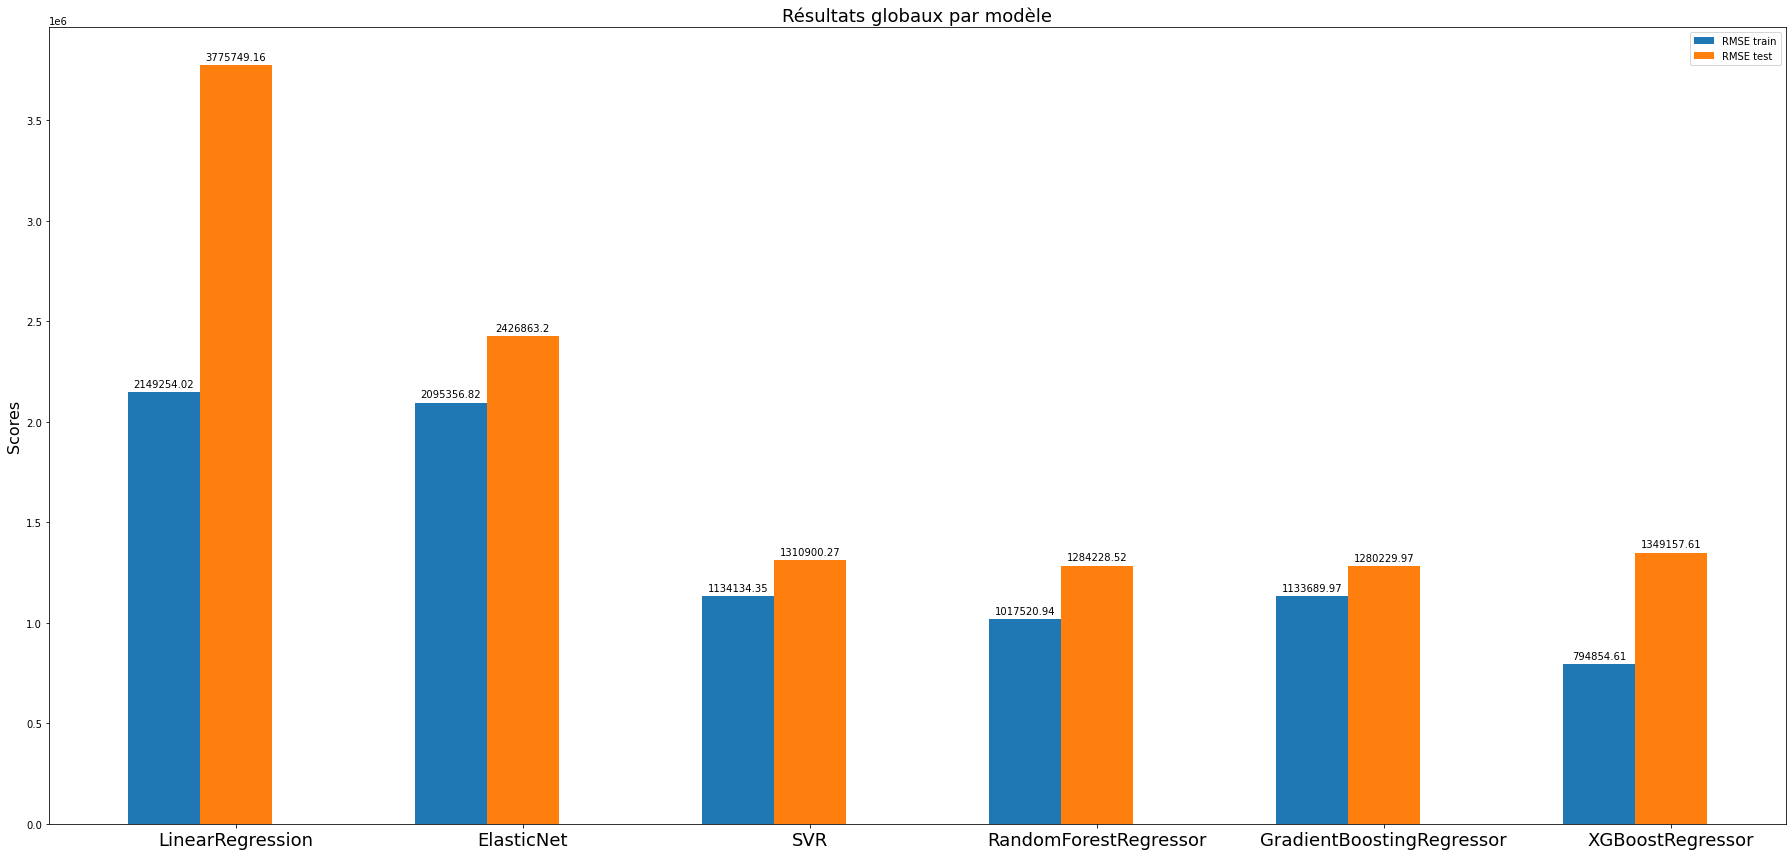

In [153]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp4_tr, df_results_perf_target1_hyp4_te, 'RMSE')

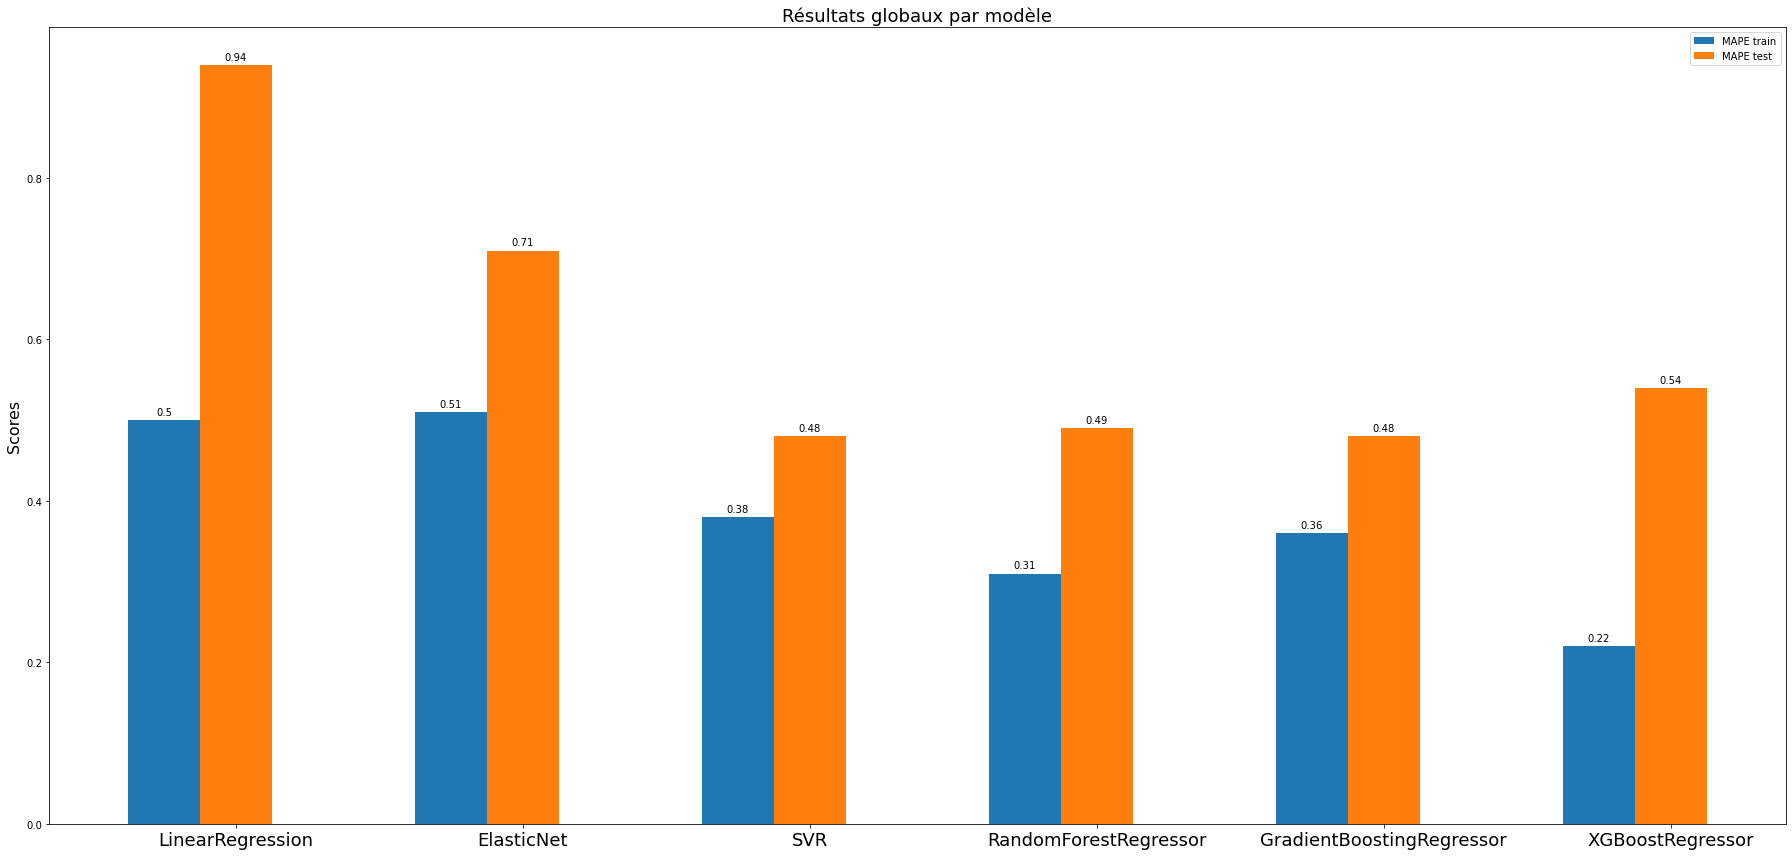

In [152]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target1_hyp4_tr, df_results_perf_target1_hyp4_te, 'MAPE')

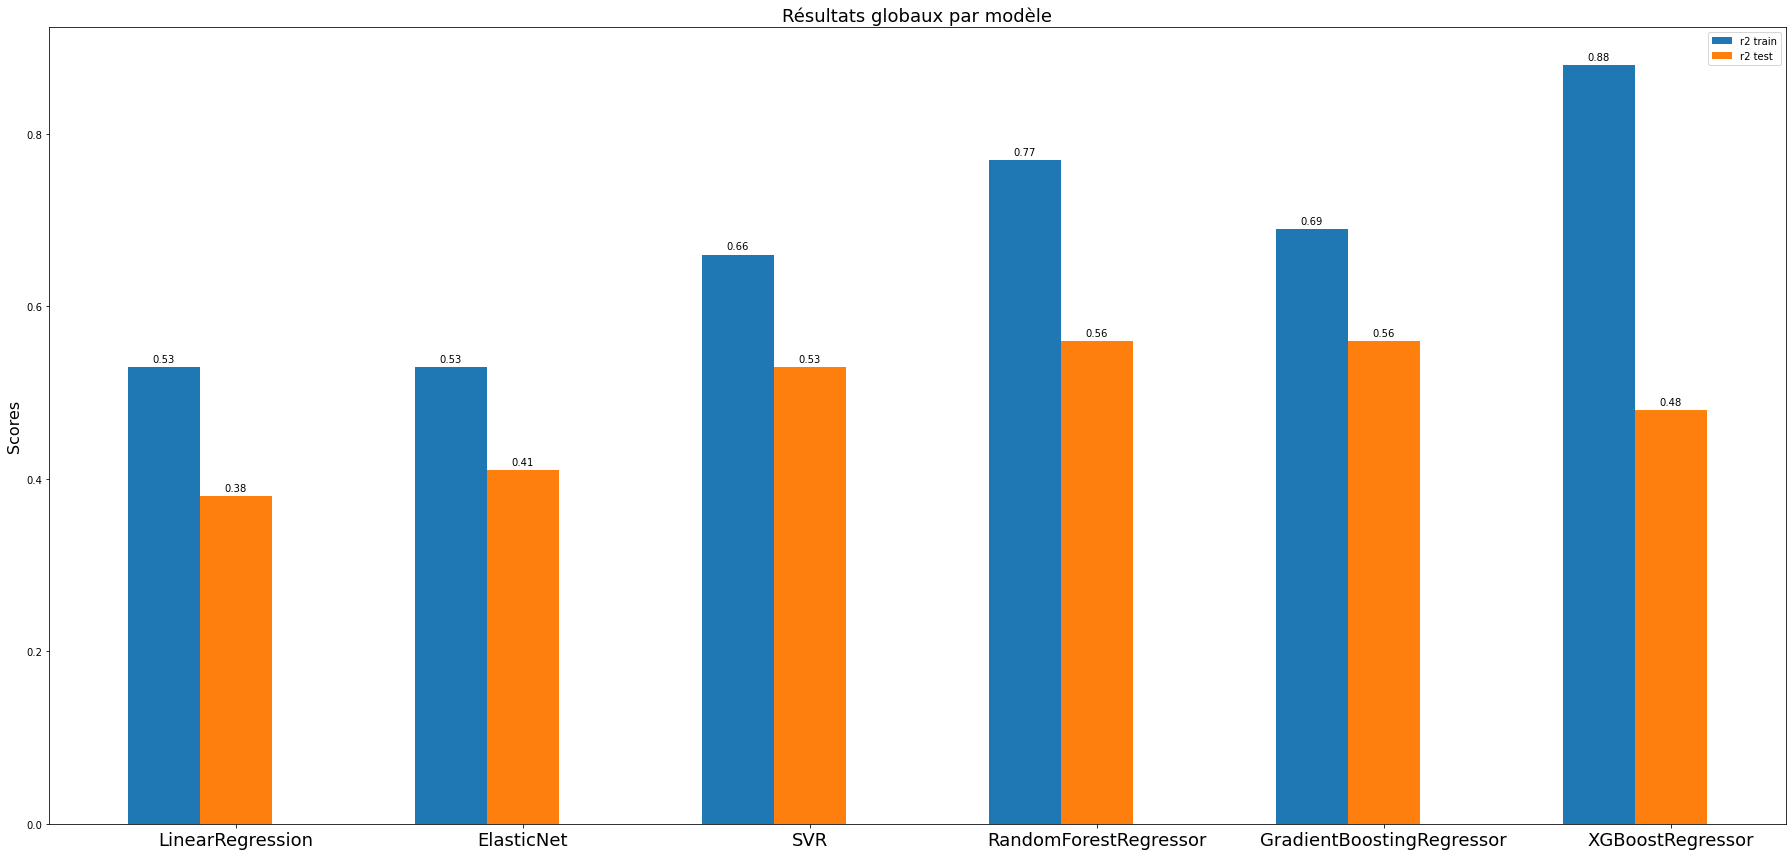

In [154]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target1_hyp4_tr, df_results_perf_target1_hyp4_te, 'r2')

**La prise en compte de l'encodage OneHot des variables catégorielles sur les bâtiments améliore nettement toutes les métriques pour l'estimateur Gradient Boosting Regressor (GBR). On remarque aussi qu'il y a moins de sur-apprentissage pour ces modèles sur le jeu de train, à l'exception du XGBoost.**

Sur la métrique de la RMSE, le GBR propose la RMSE la plus faible sur le jeu de test (1280229).
Et, sur la MAPE, le GBR  donne un taux d'erreur moyen sur le jeu de test de 48 % (MAPE).

Enfin, le RFR obtient le R² le plus élévé sur le jeu de test (0,56).

Pour la baseline (LR), le RMSE est de 3 775 749, avec un R² de 0,38.

**Donc, le Gradient Boosting Regressor est le meilleur modèle pour l'hypothèse 4 sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

On remarque enfin que la variance du meilleur modèle s'améliore sensiblement et correspond à 56% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité moyenne des prédictions.


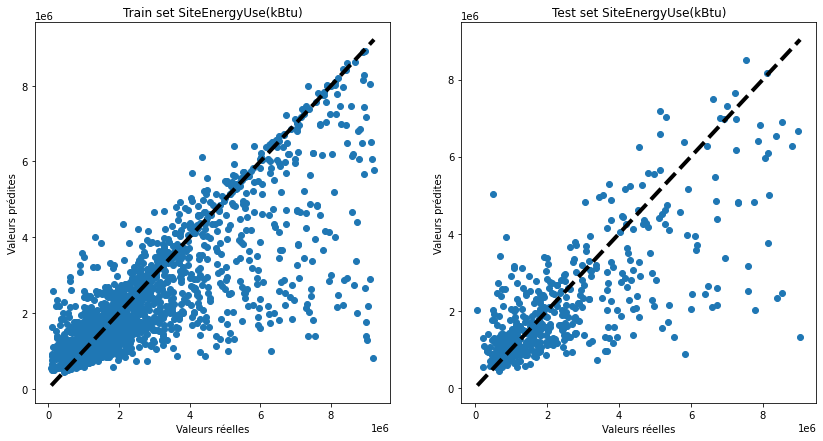

In [167]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target1_hyp4_tr[df_results_error_target1_hyp4_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target1_hyp4_tr[df_results_error_target1_hyp4_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]


test_values = df_results_error_target1_hyp4_te[df_results_error_target1_hyp4_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target1_hyp4_te[df_results_error_target1_hyp4_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target1)

#### 5.9.4 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [168]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 4
X_train_target2_hyp4, X_test_target2_hyp4, y_train_target2_hyp4, y_test_target2_hyp4 = train_test_split(X_target2_hyp4,
                                                                                    y_target2_hyp4,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2_hyp4.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2_hyp4.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2_hyp4.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2_hyp4.shape))

Dimension jeu de données X_train:(2325, 29)
Dimension jeu de données y_train:(2325, 1)
Dimension jeu de données X_test:(582, 29)
Dimension jeu de données y_test:(582, 1)


In [169]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_hyp4 = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2_hyp4, X_test_target2_hyp4, y_train_target2_hyp4,y_test_target2_hyp4,
               model_hyper_params[model_hyper_param]['regressor']['model'], 
               model_hyper_params[model_hyper_param]['hyperparam_grid'],
               model_hyper_params[model_hyper_param]['regressor']['model_txt'],
               'N', target2, 4, 10)
    
    df_optim_hyperparam_co2_hyp4 = pd.concat([df_optim_hyperparam_co2_hyp4, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle LinearRegression ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Optimal hyperparameter combination:  {'fit_intercept': True}
Best score (RMSE):  0.9268620012767533

------ Optimisation hyper-paramètres du modèle ElasticNet ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 280 candidates, totalling 2800 fits
Optimal hyperparameter combination:  {'alpha': 0.01, 'l1_ratio': 0.4, 'tol': 0.01}
Best score (RMSE):  0.9123589878298143

------ Optimisation hyper-paramètres du modèle SVR ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
-----------------------------------------------------

In [170]:
df_optim_hyperparam_co2_hyp4

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,LinearRegression,TotalGHGEmissions_CO2,10,{'fit_intercept': True}
1,ElasticNet,TotalGHGEmissions_CO2,10,"{'alpha': 0.01, 'l1_ratio': 0.4, 'tol': 0.01}"
2,SVR,TotalGHGEmissions_CO2,10,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}"
3,RandomForestRegressor,TotalGHGEmissions_CO2,10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}"
4,GradientBoostingRegressor,TotalGHGEmissions_CO2,10,"{'learning_rate': 0.2, 'loss': 'huber', 'max_depth': 4}"
5,XGBoostRegressor,TotalGHGEmissions_CO2,10,"{'max_depth': 4, 'n_estimators': 100}"


#### 5.9.5 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [174]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_hyp4_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_hyp4_te = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_hyp4_tr = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_hyp4_te = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te,
     perm_fea_tg2,
     imp_fea_tg2) = predict_model_fi(X_train_target2_hyp4, y_train_target2_hyp4, X_test_target2_hyp4, y_test_target2_hyp4, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  4, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_hyp4_tr = pd.concat([df_results_error_target2_hyp4_tr, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_hyp4_te = pd.concat([df_results_error_target2_hyp4_te, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_hyp4_tr = pd.concat([df_results_perf_target2_hyp4_tr, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_hyp4_te = pd.concat([df_results_perf_target2_hyp4_te, df_results_perf_te],
                                                 ignore_index=True)
    
    if hyper_params_target2[model_hyper_param]['regressor']['model_txt'] == 'RandomForestRegressor':
        imp_rfr_tg2 = imp_fea_tg2
        perm_rfr_tg2 = perm_fea_tg2
    
    if hyper_params_target2[model_hyper_param]['regressor']['model_txt'] == 'GradientBoostingRegressor':
        imp_gbr_tg2 = imp_fea_tg1
        perm_gbr_tg2 = perm_fea_tg1
        
    if hyper_params_target1[model_hyper_param]['regressor']['model_txt'] == 'XGBoostRegressor':
        imp_xgb_tg2 = imp_fea_tg1
        perm_xgb_tg2 = perm_fea_tg1    
    
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: LinearRegression
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/LinearRegression_TotalGHGEmissions_CO2_hyph4_optim_params.pkl
Hyper-paramètres optimisés: {'fit_intercept': True}
Prédictions avec les paramètres suivants du modèle:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegression sur le jeu de données train
----------------------------------------------------------------------------------------
Train R2:  0.35
Train RMSE:  52.94
Train MAPE:  1.22

----------------------------------------------------------------------------------------
Calcul des prédictions pour le modèle LinearRegres

In [176]:
df_results_error_target2_hyp4_tr

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,4,TotalGHGEmissions_CO2,Train,46.290,36.218446,10.071554,21.76
1,LinearRegression,4,TotalGHGEmissions_CO2,Train,10.610,27.244632,16.634632,156.78
2,LinearRegression,4,TotalGHGEmissions_CO2,Train,113.710,22.529468,91.180532,80.19
3,LinearRegression,4,TotalGHGEmissions_CO2,Train,22.570,19.881260,2.688740,11.91
4,LinearRegression,4,TotalGHGEmissions_CO2,Train,4.195,15.401393,11.206393,267.14
...,...,...,...,...,...,...,...,...
13945,XGBoostRegressor,4,TotalGHGEmissions_CO2,Train,133.080,60.928875,72.151125,54.22
13946,XGBoostRegressor,4,TotalGHGEmissions_CO2,Train,76.085,74.282814,1.802186,2.37
13947,XGBoostRegressor,4,TotalGHGEmissions_CO2,Train,58.905,64.918228,6.013228,10.21
13948,XGBoostRegressor,4,TotalGHGEmissions_CO2,Train,48.380,25.882154,22.497846,46.50


In [178]:
df_results_error_target2_hyp4_te

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,LinearRegression,4,TotalGHGEmissions_CO2,Test,37.350,37.921673,0.571673,1.53
1,LinearRegression,4,TotalGHGEmissions_CO2,Test,5.175,8.837835,3.662835,70.78
2,LinearRegression,4,TotalGHGEmissions_CO2,Test,45.385,13.106313,32.278687,71.12
3,LinearRegression,4,TotalGHGEmissions_CO2,Test,3.005,18.335130,15.330130,510.15
4,LinearRegression,4,TotalGHGEmissions_CO2,Test,26.580,71.179939,44.599939,167.80
...,...,...,...,...,...,...,...,...
3487,XGBoostRegressor,4,TotalGHGEmissions_CO2,Test,139.025,44.762943,94.262057,67.80
3488,XGBoostRegressor,4,TotalGHGEmissions_CO2,Test,5.575,16.550869,10.975869,196.88
3489,XGBoostRegressor,4,TotalGHGEmissions_CO2,Test,129.575,54.063194,75.511806,58.28
3490,XGBoostRegressor,4,TotalGHGEmissions_CO2,Test,20.745,5.657351,15.087649,72.73


In [179]:
df_results_perf_target2_hyp4_tr

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,4,TotalGHGEmissions_CO2,Train,0.35,52.94,1.22
1,ElasticNet,4,TotalGHGEmissions_CO2,Train,0.36,50.39,1.20
2,SVR,4,TotalGHGEmissions_CO2,Train,0.49,36.28,0.99
3,RandomForestRegressor,4,TotalGHGEmissions_CO2,Train,0.70,31.41,0.69
4,GradientBoostingRegressor,4,TotalGHGEmissions_CO2,Train,0.75,28.58,0.61
5,XGBoostRegressor,4,TotalGHGEmissions_CO2,Train,0.81,26.02,0.47


In [180]:
df_results_perf_target2_hyp4_te

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,LinearRegression,4,TotalGHGEmissions_CO2,Test,0.38,56.56,1.26
1,ElasticNet,4,TotalGHGEmissions_CO2,Test,0.38,54.27,1.27
2,SVR,4,TotalGHGEmissions_CO2,Test,0.46,41.85,1.13
3,RandomForestRegressor,4,TotalGHGEmissions_CO2,Test,0.50,41.17,1.10
4,GradientBoostingRegressor,4,TotalGHGEmissions_CO2,Test,0.51,40.28,1.09
5,XGBoostRegressor,4,TotalGHGEmissions_CO2,Test,0.48,42.02,1.05


In [181]:
# Valeur max cible test
np.expm1(y_test_target2_hyp4.max())

log_TotalGHGEmissions_CO2    214.945
dtype: float64

In [182]:
# Valeur moyenne cible test
df_results_error_target2_hyp4_te[df_results_error_target2_hyp4_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    45.047199
dtype: float64

In [183]:
# Valeur max cible train
np.expm1(y_train_target2_hyp4.max())

log_TotalGHGEmissions_CO2    216.39
dtype: float64

In [184]:
# Valeur moyenne cible train
df_results_error_target2_hyp4_tr[df_results_error_target2_hyp4_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    45.86028
dtype: float64

#### 5.9.6 Variable "TotalGHGEmissions_CO2"  - Affichage métriques  et choix du modéle

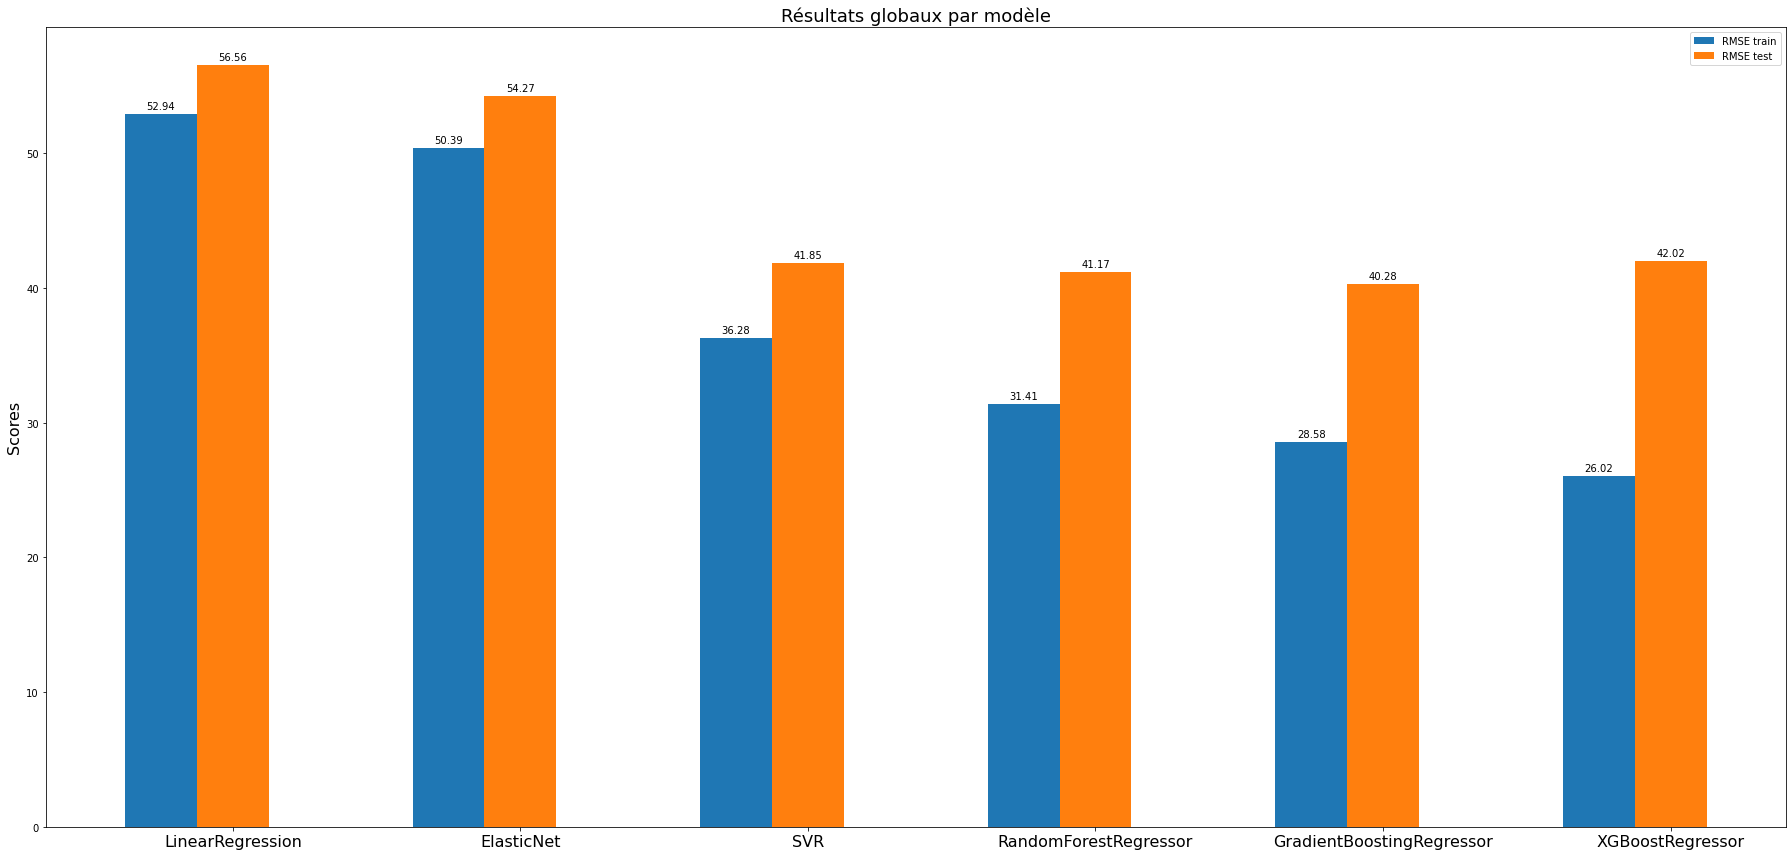

In [660]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp4_tr, df_results_perf_target2_hyp4_te, 'RMSE')

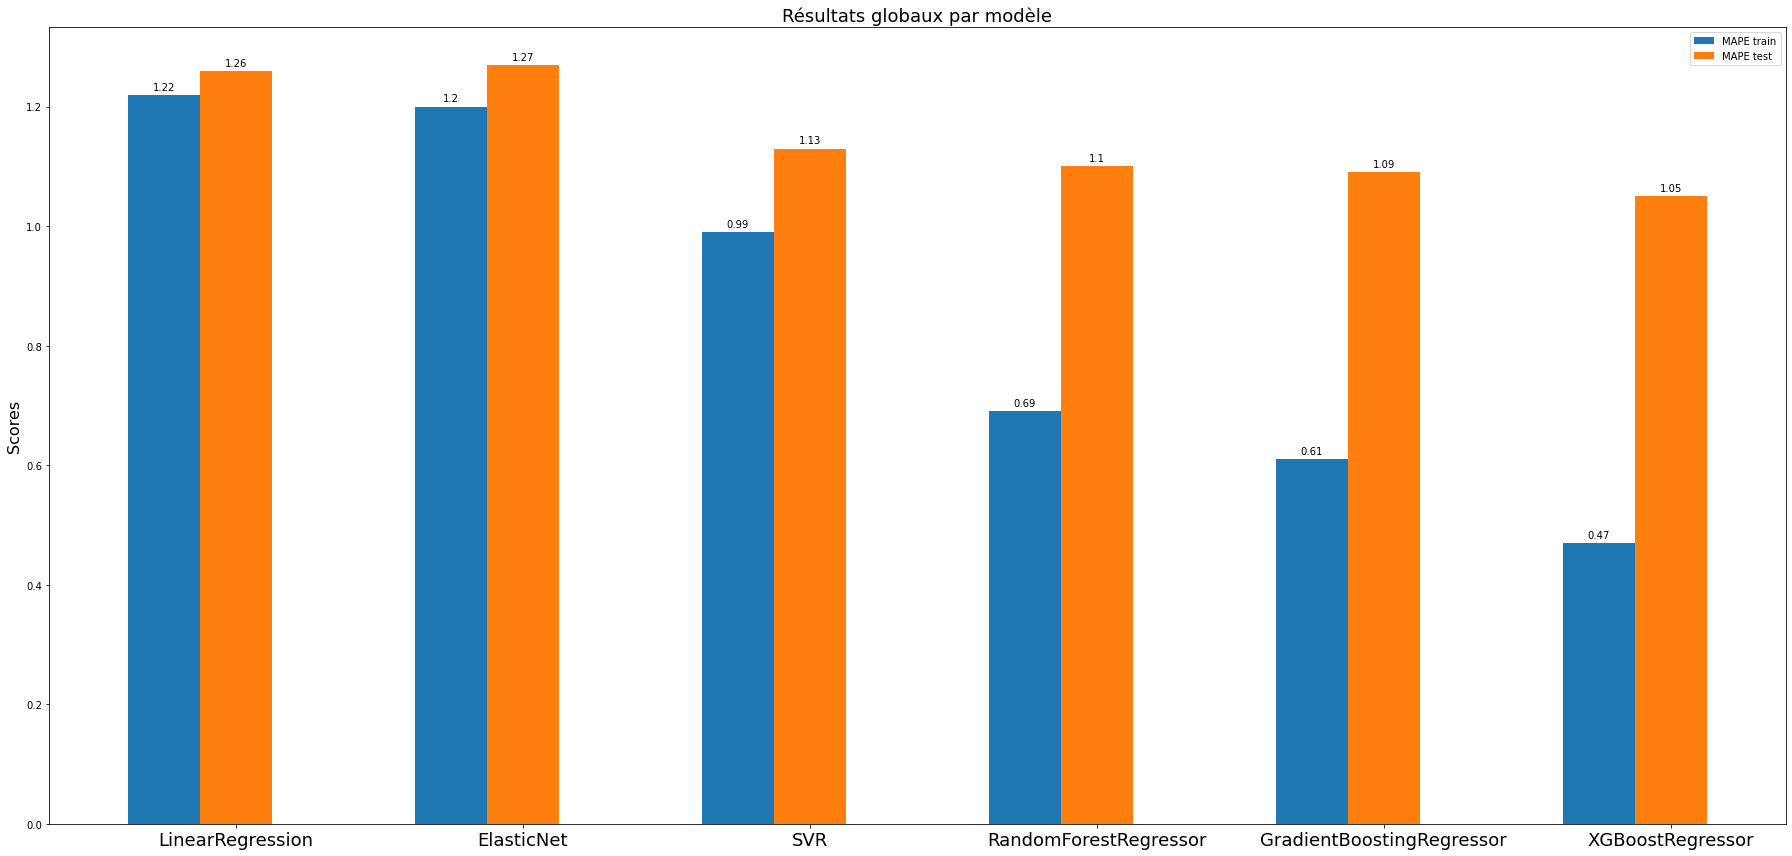

In [186]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model(df_results_perf_target2_hyp4_tr, df_results_perf_target2_hyp4_te, 'MAPE')

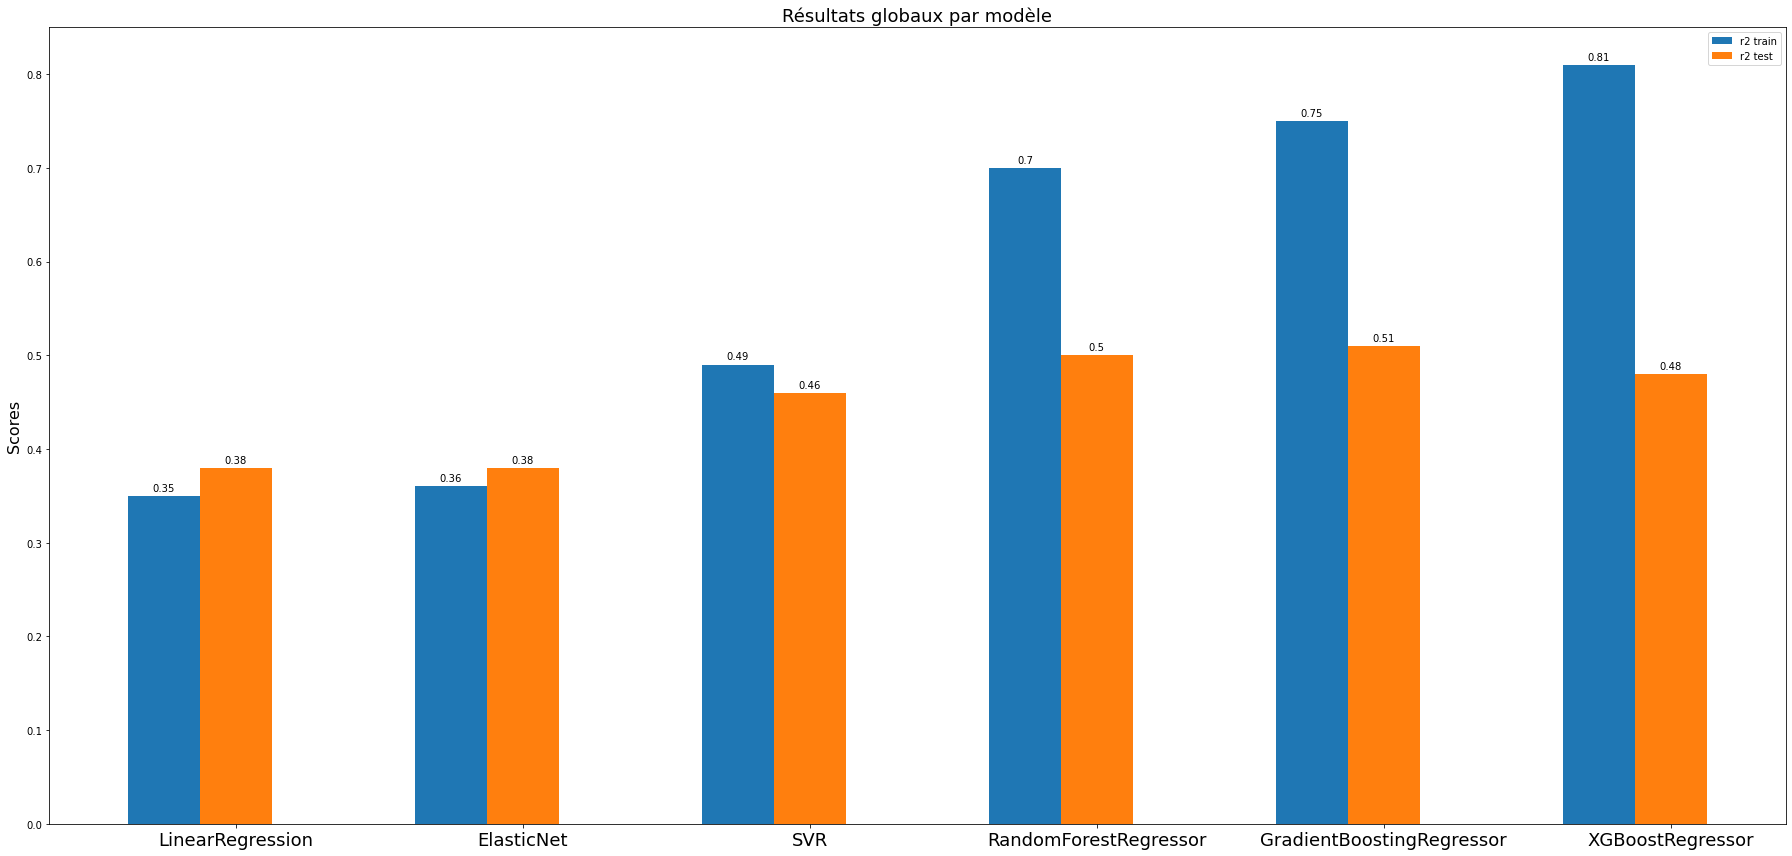

In [187]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model(df_results_perf_target2_hyp4_tr, df_results_perf_target2_hyp4_te, 'r2')

**L'hypothèse 4 n'améliore pas la métrique RMSE par rapport à l'hypothèse 3, mais on reste dans le même ordre de grandeur. Il y a toujours un sur-apprentissage pour ces modèles sur le jeu de train pour les modèles basés sur Random Forest Regressor, GradienBoostingRegressor et XGBoost.**

Sur la métrique de la RMSE, le Gradient Boosting Regressor (GBR) propose un RMSE la plus faible sur le jeu de test (40.28).
Et, sur la MAPE, le GBR  donne un taux d'erreur moyen sur le jeu de test de 109 %.

Enfin, le RFR obtient le R² de 0,51 sur le jeu de test.

**Donc, le Gradient Boosting Regressor est le meilleur modèle pour l'hypothèse 4 sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

La variance du modèle correspond à 89% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité médiocre des prédictions


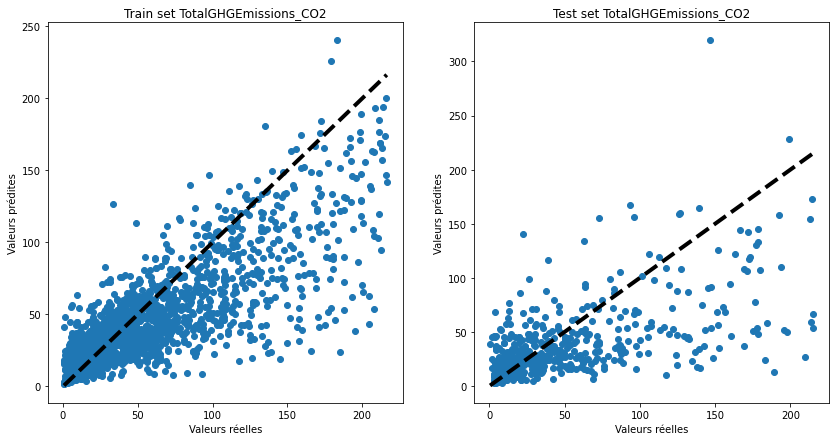

In [188]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_hyp4_tr[df_results_error_target2_hyp4_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target2_hyp4_tr[df_results_error_target2_hyp4_tr['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

test_values = df_results_error_target2_hyp4_te[df_results_error_target2_hyp4_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target2_hyp4_te[df_results_error_target2_hyp4_te['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values,target2)

## 6 Choix et amélioration du modèle final

Suite à la prise en compte des hypothèses jusqu'à l'hypothèse 4, 2 modèles se détachent basés, sur l'estimateur Gradient Boosting Regressor:

**- le modèle Gradient Boosting Regressor pour la variable cible "SiteEnergyUse(kBtu)" avec le traitement des données de l'hypothèse 4**

**- le modèle Gradient Boosting Regressor pour la variable cible "TotalGHGEMissions_CO2"  avec le traitement des données de l'hypothèse 3**

Nous allons à présent tenter d'améliorer les modèles finaux:
- Analyse l'importance des features et la permutation des features à partir des données de l'hypothèse 4 pour les variables "SiteEnergyUse(kBtu)" et "TotalGHGEmissions_CO2", ce qui amènera sans doute à supprimer certaines features.
- Ajout de 3 variables relevés (Electricity, NaturalGas, SteamUse) encodées en binaire (utilisation ou pas de l'énergie dans les batiment) pour la variable "SiteEnergyUse(kBtu)" à partir de l'hypothèse 4 (32 variables en tout), et pour la variable "TotalGHGEmissions_CO2" à partir de l'hypothèse 3 (14 variables en tout).

### 6.1 Analyse de l'importance des features et permutation des features

In [284]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_fi_tg1 = {
                      
                      
                      
                      'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(), 
                                                           'model_txt' : 'GradientBoostingRegressor'},
                                             'hyperparam_grid': {'learning_rate': [0.2, 0.4, 0.7],
                                                                 'max_depth'    : [4, 6, 8, 10],
                                                                 'loss' : ['ls','lad','huber']}}
                    
                        
                     }

# Liste des hyper-paramètres à régler par modèle
model_hyper_params_fi_tg2= {
                      
                      
                      
                       'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(), 
                                                           'model_txt' : 'GradientBoostingRegressor'},
                                             'hyperparam_grid': {'learning_rate': [0.2, 0.4, 0.7],
                                                                 'max_depth'    : [4, 6, 8, 10],
                                                                 'loss' : ['ls','lad','huber']}}
                    
                        
                     }

#### 6.1.1 Variable "SiteEnergyUse(kBtu)"

Affichage des features / permutation importance pour la variable "SiteEnergyUse(kBtu)" avec le modèle retenu Gradient Boosting Regressor avec l'hypothèse 4.

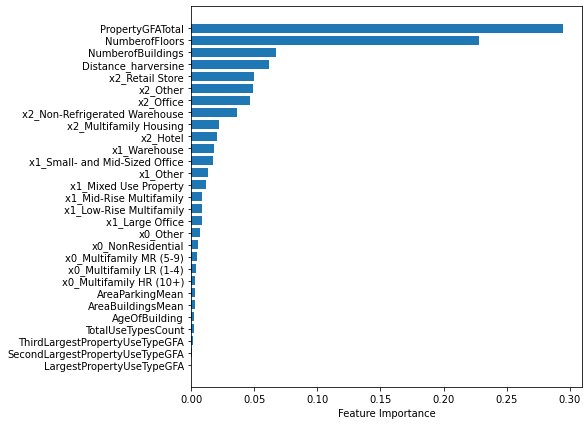

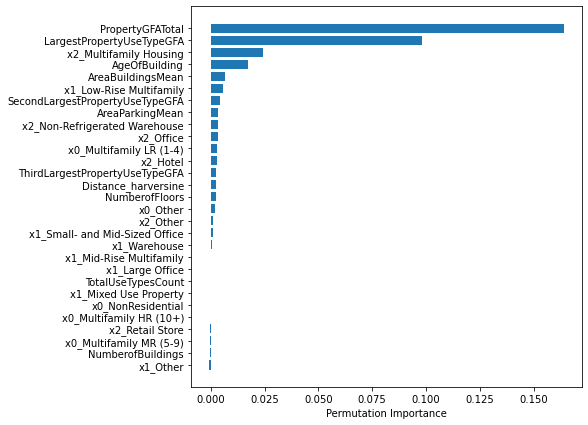

In [203]:
# Appel fonction affichage Features importance - Cible "SiteEnergyUse(kBtu)" - Gradient Boosting Regressor
affic_features_impotance_model(imp_gbr_tg1,
                               perm_gbr_tg1,
                               X_test_target1_hyp4)

Pour la variable "SiteEnergyUse(kBtu)", on remarque que les variables les plus importantes dans notre modèle GBR (hypothèse 4) sont (graphique "Feature Importance"):
- PropertyGFATotal
- NumberofFloors
- NumberofBuildings
- Distance_harversine
- x2_Retail Store
- x2_Other
- x2_Office

Sur la graphique "Permutation Importance", on va écarter les varaibles ayant un score négatif ou avec un faible score (cad faible impact sur les , à savoir:
- x1_Other
- NumberofBuildings
- x0_Multifamily MR (5-9)
- x2_Retail Store
- x0_Multifamily HR (10+)
- x0_NonResidential
- x1_Mixed Use Property
- TotalUseTypesCount
- x1_Large Office
- x1_Mid-Rise Multifamily


L'importance des caractéristiques (permutation importance) est définie comme la diminution du score d'un modèle lorsqu'une seule valeur de caractéristique est mélangée au hasard. 

Cette procédure rompt la relation entre la fonctionnalité et la cible, ainsi la baisse du score du modèle indique à quel point le modèle dépend de la fonctionnalité. Cette technique a l'avantage d'être indépendante du modèle et peut être calculée plusieurs fois avec différentes permutations de la fonctionnalité.

#### 6.1.2 Variable "TotalGHGEmissions_CO2"

Affichage des features / permutation importance pour la variable "TotalGHGEmissions_CO2" avec le modèle retenu Gradient Boosting Regressor avec l'hypothèse 4.

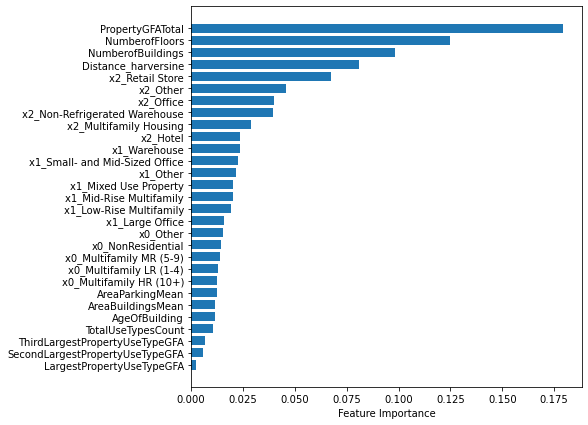

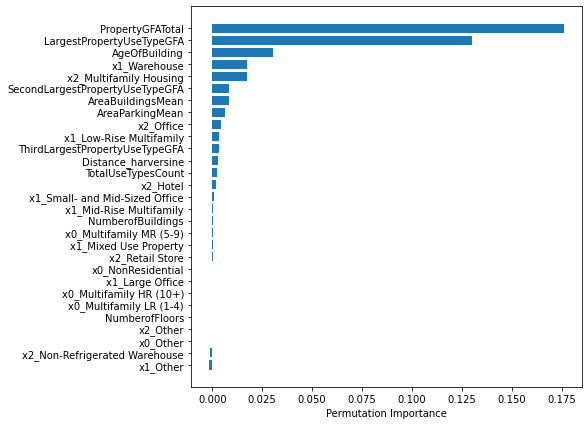

In [311]:
# Appel fonction affichage Features importance - Cible "TotalGHGEmissions_CO2" - Gradient Boosting Regressor
affic_features_impotance_model(imp_gbr_tg2,
                               perm_gbr_tg2,
                               X_test_target2_hyp4)

Pour la variable "Total_GHGEmissions_CO2", on remarque que les variables les plus importantes dans notre modèle GBR (hypothèse 4) sont (graphique "Feature Importance"):
- PropertyGFATotal
- NumberofFloors
- NumberofBuildings
- Distance_harversine
- x2_Retail Store
- x2_Other

Sur la graphique "Permutation Importance", on va écarter les varaibles ayant un score négatif ou avec un score à 0, à savoir:
- x1_Other
- x2_Non-Refrigerated Warehouse
- x0_Other
- x2_Other
- NumberofFloors
- x0_Multifamily LR (1-4)
- x0_Multifamily HR (10+)
- x1_Large Office
- x0_NonResidential


#### 6.1.3 Variable "SiteEnergyUse(kBtu)" - Suppression des features les moins pertinents

In [287]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 1
X_train_target1_hyp4_fi, X_test_target1_hyp4_fi, y_train_target1_hyp4_fi, y_test_target1_hyp4_fi = train_test_split(X_target1_hyp4,
                                                                                    y_target1_hyp4,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target1_hyp4_fi.shape))
print('Dimension jeu de données y_train:' + str(y_train_target1_hyp4_fi.shape))
print('Dimension jeu de données X_test:' + str(X_test_target1_hyp4_fi.shape))
print('Dimension jeu de données y_test:' + str(y_test_target1_hyp4_fi.shape))

Dimension jeu de données X_train:(2303, 29)
Dimension jeu de données y_train:(2303, 1)
Dimension jeu de données X_test:(576, 29)
Dimension jeu de données y_test:(576, 1)


In [288]:
# Suppression des features les moins pertinents sur jeux de train / test
X_train_target1_hyp4_fi.drop(columns=['x1_Other',
                                      'NumberofBuildings',
                                      'x0_Multifamily MR (5-9)',
                                      'x2_Retail Store',
                                      'x0_Multifamily HR (10+)',
                                      'x0_NonResidential',
                                      'x1_Mixed Use Property',
                                      'TotalUseTypesCount',
                                      'x1_Large Office',
                                      'x1_Mid-Rise Multifamily'], inplace=True)

X_test_target1_hyp4_fi.drop(columns=['x1_Other',
                                      'NumberofBuildings',
                                      'x0_Multifamily MR (5-9)',
                                      'x2_Retail Store',
                                      'x0_Multifamily HR (10+)',
                                      'x0_NonResidential',
                                      'x1_Mixed Use Property',
                                      'TotalUseTypesCount',
                                      'x1_Large Office',
                                      'x1_Mid-Rise Multifamily'], inplace=True)
                                      
                                     

In [289]:
X_train_target1_hyp4_fi

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,x0_Multifamily LR (1-4),x0_Other,x1_Low-Rise Multifamily,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,Distance_harversine,NumberofFloors,PropertyGFATotal
1291,-0.645786,-0.480173,-0.253304,-0.594407,-0.435073,-0.306671,1.366576,-0.172294,1.397434,-0.332110,-0.259011,-0.131585,0.902917,-0.268800,-0.386989,-0.509859,2.330777,-0.294068,-0.684468
994,-0.447028,-0.480173,-0.253304,-0.085724,-0.430573,-0.306671,-0.731756,-0.172294,-0.715598,-0.332110,3.860839,-0.131585,-1.107522,3.720243,-0.386989,-0.509859,-0.491178,-0.595678,-0.528443
989,-0.851492,0.036482,-0.253304,1.290710,-0.521165,-0.306671,-0.731756,-0.172294,-0.715598,-0.332110,-0.259011,-0.131585,-1.107522,-0.268800,-0.386989,1.961326,0.453720,-0.897288,-0.693171
1264,-0.461850,-0.480173,-0.253304,-0.654252,0.113059,-0.306671,-0.731756,-0.172294,-0.715598,-0.332110,-0.259011,-0.131585,0.902917,-0.268800,-0.386989,-0.509859,-1.175749,1.213985,-0.308711
1292,-0.681903,-0.480173,-0.253304,0.243423,-0.485733,-0.306671,-0.731756,-0.172294,-0.715598,3.011052,-0.259011,-0.131585,-1.107522,-0.268800,2.584054,-0.509859,-0.848718,-0.595678,-0.712819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,-0.591231,-0.480173,-0.253304,1.290710,-0.417990,-0.306671,1.366576,-0.172294,1.397434,-0.332110,-0.259011,-0.131585,0.902917,-0.268800,-0.386989,-0.509859,-0.853303,-0.294068,-0.641642
2199,-0.201732,-0.480173,-0.253304,-1.043244,-0.065209,-0.306671,-0.731756,-0.172294,-0.715598,-0.332110,-0.259011,-0.131585,0.902917,-0.268800,-0.386989,-0.509859,0.101557,0.610764,-0.335886
1261,-0.577884,0.056694,-0.253304,1.440322,-0.159711,-0.306671,-0.731756,-0.172294,-0.715598,3.011052,-0.259011,-0.131585,-1.107522,-0.268800,2.584054,-0.509859,-1.150166,0.007543,-0.216803
817,-0.623565,0.656721,-0.253304,-1.043244,-0.032522,-0.306671,-0.731756,-0.172294,-0.715598,-0.332110,-0.259011,-0.131585,0.902917,-0.268800,-0.386989,-0.509859,-1.005906,1.213985,-0.470918


In [290]:
X_test_target1_hyp4_fi.shape

(576, 19)

In [292]:
# Hypothèse testée
id_hyp = '4_AME1'

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_gbr1 = ds_rep + 'GradientBoostingRegressor_SiteEnergyUse(kBtu)' + '_hyph' + id_hyp + '_' + 'optim_params.pkl'

In [293]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target1 = {
                        'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr1}}}

#### 6.1.4 Variable "SiteEnergyUse(kBtu)" - Réglage hyper-paramètres et entraînement modèles

In [294]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_energie_hyp4_fi = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params_fi_tg1:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params_fi_tg1[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target1_hyp4_fi, X_test_target1_hyp4_fi, y_train_target1_hyp4_fi,y_test_target1_hyp4_fi,
               model_hyper_params_fi_tg1[model_hyper_param]['regressor']['model'], 
               model_hyper_params_fi_tg1[model_hyper_param]['hyperparam_grid'],
               model_hyper_params_fi_tg1[model_hyper_param]['regressor']['model_txt'],
               'N', target1, id_hyp, 10)
    
    df_optim_hyperparam_energie_hyp4_fi = pd.concat([df_optim_hyperparam_energie_hyp4_fi, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle GradientBoostingRegressor ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Optimal hyperparameter combination:  {'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}
Best score (RMSE):  0.524034488863828



In [295]:
df_optim_hyperparam_energie_hyp4_fi

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,GradientBoostingRegressor,SiteEnergyUse(kBtu),10,"{'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}"


#### 6.1.5 Variable "SiteEnergyUse(kBtu)" - Prédictions 

In [296]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target1_hyp4_tr_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target1_hyp4_te_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target1_hyp4_tr_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target1_hyp4_te_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target1:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target1_hyp4_fi, y_train_target1_hyp4_fi, X_test_target1_hyp4_fi, y_test_target1_hyp4_fi, 
                  hyper_params_target1[model_hyper_param]['regressor']['model'],
                  hyper_params_target1[model_hyper_param]['regressor']['model_txt'],
                  id_hyp, hyper_params_target1[model_hyper_param]['regressor']['fic_hyperparam'],target1, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target1_hyp4_tr_fi = pd.concat([df_results_error_target1_hyp4_tr_fi, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target1_hyp4_te_fi = pd.concat([df_results_error_target1_hyp4_te_fi, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target1_hyp4_tr_fi = pd.concat([df_results_perf_target1_hyp4_tr_fi, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target1_hyp4_te_fi = pd.concat([df_results_perf_target1_hyp4_te_fi, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingRegressor
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/GradientBoostingRegressor_SiteEnergyUse(kBtu)_hyph4_AME1_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}
Prédictions avec les paramètres suivants du modèle:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

--------------------

In [297]:
df_results_error_target1_hyp4_tr_fi

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,6.699800e+05,6.623827e+05,7.597291e+03,1.13
1,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,3.169567e+06,1.547989e+06,1.621578e+06,51.16
2,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,5.076418e+06,8.737940e+05,4.202624e+06,82.79
3,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,1.854665e+06,1.618808e+06,2.358573e+05,12.72
4,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,5.607345e+05,9.551960e+05,3.944615e+05,70.35
...,...,...,...,...,...,...,...,...
2298,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,5.879040e+05,8.881114e+05,3.002074e+05,51.06
2299,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,9.431634e+05,1.511416e+06,5.682525e+05,60.25
2300,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,1.926367e+06,1.906201e+06,2.016532e+04,1.05
2301,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,1.508404e+06,1.292163e+06,2.162408e+05,14.34


In [298]:
df_results_error_target1_hyp4_te_fi

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,1.572816e+06,1.943484e+06,3.706684e+05,23.57
1,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,1.026061e+06,9.060481e+05,1.200130e+05,11.70
2,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,1.388091e+06,8.685583e+05,5.195328e+05,37.43
3,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,1.626087e+06,1.223303e+06,4.027840e+05,24.77
4,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,2.346692e+06,1.703655e+06,6.430377e+05,27.40
...,...,...,...,...,...,...,...,...
571,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,4.383915e+06,7.847163e+06,3.463248e+06,79.00
572,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,7.700540e+05,1.544714e+06,7.746595e+05,100.60
573,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,8.111655e+06,8.795864e+06,6.842088e+05,8.43
574,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,6.730884e+05,9.193086e+05,2.462202e+05,36.58


In [299]:
df_results_perf_target1_hyp4_tr_fi

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Train,0.67,1115128.26,0.38


In [300]:
df_results_perf_target1_hyp4_te_fi

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,GradientBoostingRegressor,4_AME1,SiteEnergyUse(kBtu),Test,0.58,1486558.14,0.43


In [410]:
# Valeur max cible test
np.expm1(y_test_target1_hyp4_fi.max())

log_SiteEnergyUse(kBtu)    9215900.5
dtype: float64

In [411]:
# Valeur moyenne cible test
df_results_error_target1_hyp4_te_fi[df_results_error_target1_hyp4_te_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    2.435588e+06
dtype: float64

In [412]:
# Valeur max cible train
np.expm1(y_train_target1_hyp4_fi.max())

log_SiteEnergyUse(kBtu)    9168620.0
dtype: float64

In [309]:
# Valeur moyenne cible test
df_results_error_target1_hyp4_tr_fi[df_results_error_target1_hyp4_tr_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    2.231403e+06
dtype: float64

#### 6.1.6 Variable "SiteEnergyUse(kBtu)" - Affichage métriques et choix du modèle

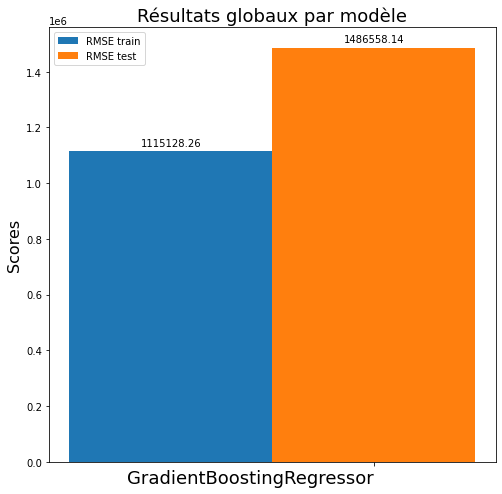

In [667]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model_2(df_results_perf_target1_hyp4_tr_fi, df_results_perf_target1_hyp4_te_fi, 'RMSE')

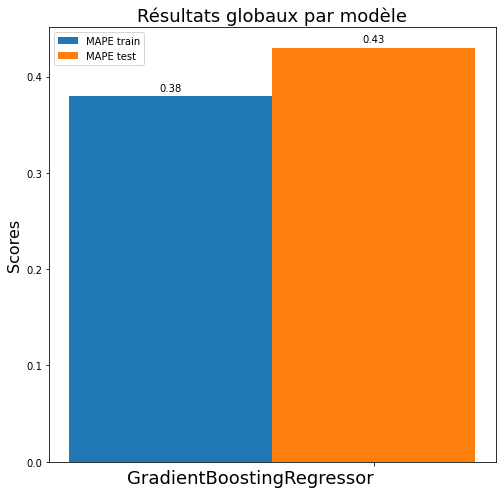

In [668]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model_2(df_results_perf_target1_hyp4_tr_fi, df_results_perf_target1_hyp4_te_fi, 'MAPE')

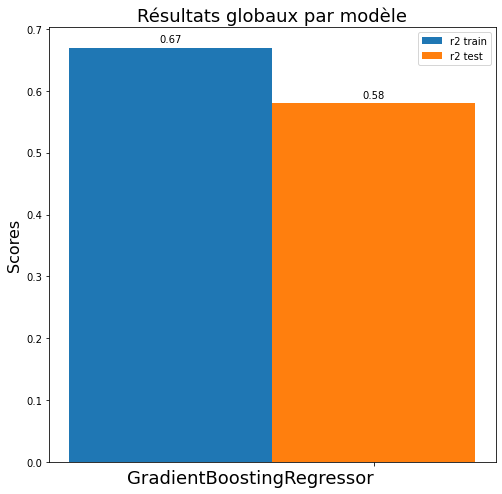

In [669]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model_2(df_results_perf_target1_hyp4_tr_fi, df_results_perf_target1_hyp4_te_fi, 'r2')

**La réduction de features (10 variables supprimées) n'apportent d'améliorations sur la  RMSE par rapport au modèle Gradient Boosting Regressor de l'hypothèse 4, au contraire une dégradation sensible.**

Sur la métrique de la RMSE, le modèle GBR propose un RMSE de (1486558).
Et, sur la MAPE, le modèle GBR donne un taux d'erreur moyen sur le jeu de test de 43 % (MAPE).

Enfin, le GBR obtient un R² de 0,58.

Le R² et la MAPE sont meilleurs que celui renconté lors de l'hypothèse 4, mais la RMSE et RMSE relative sont dégradés

**Donc, le Gradient Boosting Regressor avec les données de l'hypothèse 4 reste le meilleur modèle sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

Enfin, nous tenterons d'ajouter des variables "Electricity", "NaturalGas" et "SteamUse" sous forme de variables binaires encodées (consommation ou pas de l'énergie par le bâtiment).


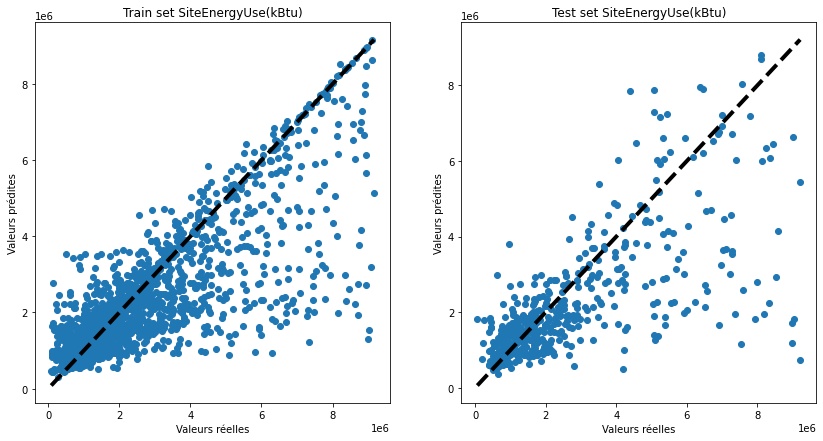

In [310]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target1_hyp4_tr_fi[df_results_error_target1_hyp4_tr_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target1_hyp4_tr_fi[df_results_error_target1_hyp4_tr_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

test_values = df_results_error_target1_hyp4_te_fi[df_results_error_target1_hyp4_te_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target1_hyp4_te_fi[df_results_error_target1_hyp4_te_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target1)

#### 6.1.7 Variable "TotalGHGEmissions_CO2" - Suppression des features les moins pertinents

In [312]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 2
X_train_target2_hyp4_fi, X_test_target2_hyp4_fi, y_train_target2_hyp4_fi, y_test_target2_hyp4_fi = train_test_split(X_target2_hyp4,
                                                                                    y_target2_hyp4,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2_hyp4_fi.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2_hyp4_fi.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2_hyp4_fi.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2_hyp4_fi.shape))

Dimension jeu de données X_train:(2325, 29)
Dimension jeu de données y_train:(2325, 1)
Dimension jeu de données X_test:(582, 29)
Dimension jeu de données y_test:(582, 1)


In [313]:
# Suppression des features les moins pertinents sur jeux de train / test
X_train_target2_hyp4_fi.drop(columns=['x1_Other',
                                      'x2_Non-Refrigerated Warehouse',
                                      'x0_Other',
                                      'x2_Other',
                                      'NumberofFloors',
                                      'x0_Multifamily LR (1-4)',
                                      'x0_Multifamily HR (10+)',
                                      'x1_Large Office',
                                      'x0_NonResidential'], inplace=True)

X_test_target2_hyp4_fi.drop(columns=['x1_Other',
                                      'x2_Non-Refrigerated Warehouse',
                                      'x0_Other',
                                      'x2_Other',
                                      'NumberofFloors',
                                      'x0_Multifamily LR (1-4)',
                                      'x0_Multifamily HR (10+)',
                                      'x1_Large Office',
                                      'x0_NonResidential'], inplace=True)

In [314]:
X_train_target2_hyp4_fi

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,x0_Multifamily MR (5-9),x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Office,x2_Retail Store,Distance_harversine,NumberofBuildings,PropertyGFATotal
1984,-0.333598,-0.429837,-0.25348,-0.738515,0.603249,-0.268619,-0.291236,-0.479808,-0.709297,-0.471652,-0.197374,-0.330971,-0.256917,-0.113543,-1.082888,-0.418354,-0.173553,0.211691,-0.070823,-0.408410
442,0.763182,-0.429837,-0.25348,-0.738515,0.362169,-0.193533,-0.291236,-0.479808,-0.709297,-0.471652,-0.197374,-0.330971,3.892300,-0.113543,-1.082888,-0.418354,-0.173553,-0.093120,-0.070823,0.421016
935,0.729867,1.591468,-0.25348,0.233796,-0.632285,0.239259,0.637667,2.084167,-0.709297,2.120206,-0.197374,-0.330971,-0.256917,-0.113543,0.923457,-0.418354,-0.173553,-1.080093,-0.070823,0.981306
2456,-0.485706,0.134665,-0.25348,0.233796,-0.903499,-0.222392,-0.031815,2.084167,-0.709297,2.120206,-0.197374,-0.330971,-0.256917,-0.113543,0.923457,-0.418354,-0.173553,-0.949307,-0.070823,-0.442718
1186,1.892052,1.996689,-0.25348,0.233796,-0.782959,3.006336,2.096424,2.084167,-0.709297,2.120206,-0.197374,-0.330971,-0.256917,-0.113543,0.923457,-0.418354,-0.173553,-0.610658,-1.666802,2.145610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,-0.064973,-0.429837,-0.25348,-0.738515,0.030684,0.030225,-0.291236,-0.479808,1.409846,-0.471652,-0.197374,-0.330971,-0.256917,-0.113543,0.923457,-0.418354,-0.173553,1.826704,-0.070823,0.650693
3025,0.495013,0.409965,-0.25348,0.233796,-0.511745,0.064141,-0.291236,-0.479808,-0.709297,-0.471652,-0.197374,3.021410,-0.256917,-0.113543,-1.082888,2.390319,-0.173553,-1.189127,-0.070823,0.069580
2016,-0.611699,-0.086626,-0.25348,0.233796,-0.662420,-0.290281,0.174561,-0.479808,-0.709297,-0.471652,-0.197374,-0.330971,-0.256917,-0.113543,-1.082888,-0.418354,-0.173553,0.278396,-0.070823,-0.375453
1885,-0.699051,0.238703,-0.25348,0.233796,-0.662420,-0.309246,-0.291236,-0.479808,-0.709297,-0.471652,-0.197374,-0.330971,-0.256917,-0.113543,-1.082888,-0.418354,-0.173553,1.032777,-0.070823,-0.491133


In [315]:
X_test_target2_hyp4_fi.shape

(582, 20)

In [316]:
# Hypothèse testée
id_hyp = '4_AME2'

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_gbr2 = ds_rep + 'GradientBoostingRegressor_TotalGHGEmissions_CO2' + '_hyph' + id_hyp + '_' + 'optim_params.pkl'

In [317]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target2 = {
                        'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr2}}}

#### 6.1.8 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [318]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_hyp4_fi = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params_fi_tg2:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params_fi_tg2[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2_hyp4_fi, X_test_target2_hyp4_fi, y_train_target2_hyp4_fi,y_test_target2_hyp4_fi,
               model_hyper_params_fi_tg2[model_hyper_param]['regressor']['model'], 
               model_hyper_params_fi_tg2[model_hyper_param]['hyperparam_grid'],
               model_hyper_params_fi_tg2[model_hyper_param]['regressor']['model_txt'],
               'N', target2, id_hyp, 10)
    
    df_optim_hyperparam_co2_hyp4_fi = pd.concat([df_optim_hyperparam_co2_hyp4_fi, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle GradientBoostingRegressor ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Optimal hyperparameter combination:  {'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 4}
Best score (RMSE):  0.8206877868747998



In [319]:
df_optim_hyperparam_co2_hyp4_fi

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,GradientBoostingRegressor,TotalGHGEmissions_CO2,10,"{'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 4}"


#### 6.1.9 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [320]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_hyp4_tr_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_hyp4_te_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_hyp4_tr_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_hyp4_te_fi = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target2_hyp4_fi, y_train_target2_hyp4_fi, X_test_target2_hyp4_fi, y_test_target2_hyp4_fi, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  id_hyp, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_hyp4_tr_fi = pd.concat([df_results_error_target2_hyp4_tr_fi, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_hyp4_te_fi = pd.concat([df_results_error_target2_hyp4_te_fi, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_hyp4_tr_fi = pd.concat([df_results_perf_target2_hyp4_tr_fi, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_hyp4_te_fi = pd.concat([df_results_perf_target2_hyp4_te_fi, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingRegressor
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/GradientBoostingRegressor_TotalGHGEmissions_CO2_hyph4_AME2_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 4}
Prédictions avec les paramètres suivants du modèle:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

--------------------

In [323]:
df_results_error_target2_hyp4_tr_fi

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,43.705,36.811122,6.893878,15.77
1,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,40.325,29.765767,10.559233,26.19
2,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,19.470,33.456496,13.986496,71.84
3,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,27.585,14.625858,12.959142,46.98
4,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,102.540,90.952286,11.587714,11.30
...,...,...,...,...,...,...,...,...
2320,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,71.725,28.469118,43.255882,60.31
2321,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,30.300,33.310503,3.010503,9.94
2322,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,14.615,17.883680,3.268680,22.37
2323,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,31.415,38.644009,7.229009,23.01


In [324]:
df_results_error_target2_hyp4_te_fi

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,63.015,29.709880,33.305120,52.85
1,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,47.195,9.545892,37.649108,79.77
2,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,158.670,45.789285,112.880715,71.14
3,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,3.535,4.608103,1.073103,30.36
4,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,87.070,20.947545,66.122455,75.94
...,...,...,...,...,...,...,...,...
577,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,67.995,11.485274,56.509726,83.11
578,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,22.110,80.668634,58.558634,264.85
579,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,7.350,7.114896,0.235104,3.20
580,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,18.065,48.393640,30.328640,167.89


In [325]:
df_results_perf_target2_hyp4_tr_fi

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Train,0.78,28.41,0.54


In [326]:
df_results_perf_target2_hyp4_te_fi

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,GradientBoostingRegressor,4_AME2,TotalGHGEmissions_CO2,Test,0.41,39.73,1.17


In [413]:
# Valeur max cible test
np.expm1(y_test_target2_hyp4_fi.max())

log_TotalGHGEmissions_CO2    213.05
dtype: float64

In [328]:
# Valeur moyenne cible test
df_results_error_target2_hyp4_te_fi[df_results_error_target2_hyp4_te_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    44.052947
dtype: float64

In [414]:
# Valeur max cible train
np.expm1(y_train_target2_hyp4_fi.max())

log_TotalGHGEmissions_CO2    216.39
dtype: float64

In [331]:
# Valeur moyenne cible test
df_results_error_target2_hyp4_tr_fi[df_results_error_target2_hyp4_tr_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    46.109163
dtype: float64

#### 6.1.10 Variable "TotalGHGEmissions_CO2" - Affichage métriques et choix du modèle

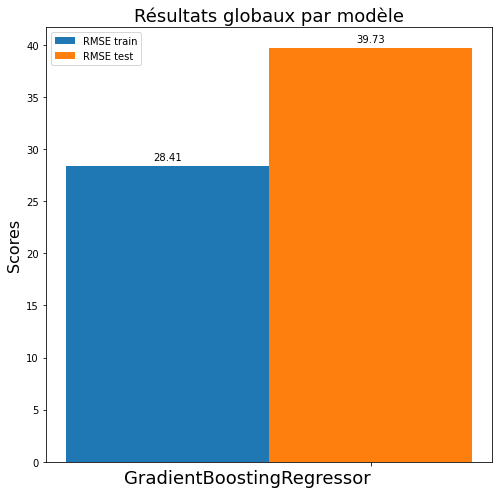

In [670]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model_2(df_results_perf_target2_hyp4_tr_fi, df_results_perf_target2_hyp4_te_fi, 'RMSE')

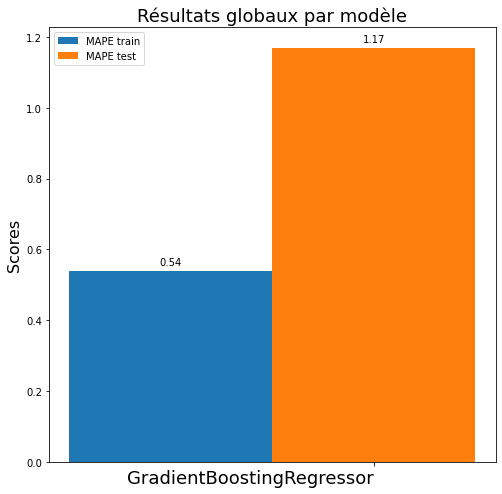

In [671]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model_2(df_results_perf_target2_hyp4_tr_fi, df_results_perf_target2_hyp4_te_fi, 'MAPE')

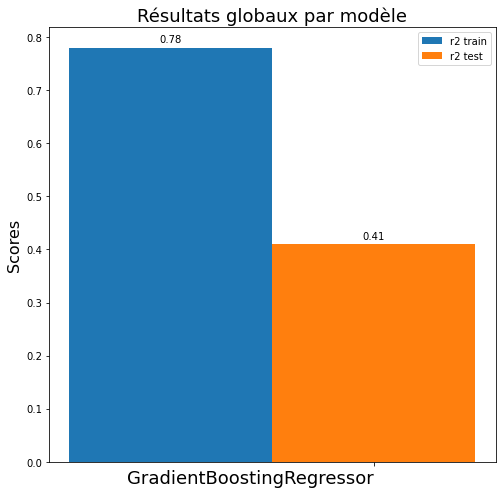

In [672]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model_2(df_results_perf_target2_hyp4_tr_fi, df_results_perf_target2_hyp4_te_fi, 'r2')

**La réduction de features (9 variables supprimées) apporte une faible amélioration sur la  RMSE par rapport au modèle Gradient Boosting Regressor de l'hypothèse 4, mais un forte dégradation du R² et de la MAPE.**

Sur la métrique de la RMSE, le modèle RFR propose un RMSE de (39,73).
Et, sur la MAPE, le modèle RFR donne un taux d'erreur moyen sur le jeu de test de 117 % (MAPE).

Enfin, le RFR obtient un R² de 0,41, indiquant un sur-apprentissage par rapport au jeu de train. On n'arrive pas à généraliser le modèle.

**Donc, le Gradient Boosting Regressor avec les données de l'hypothèse 4 reste le meilleur modèle sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**

Enfin, nous tenterons d'ajouter des variables "Electricity", "NaturalGas" et "SteamUse" sous forme de variables binaires encodées (consommation ou pas de l'énergie par le bâtiment).


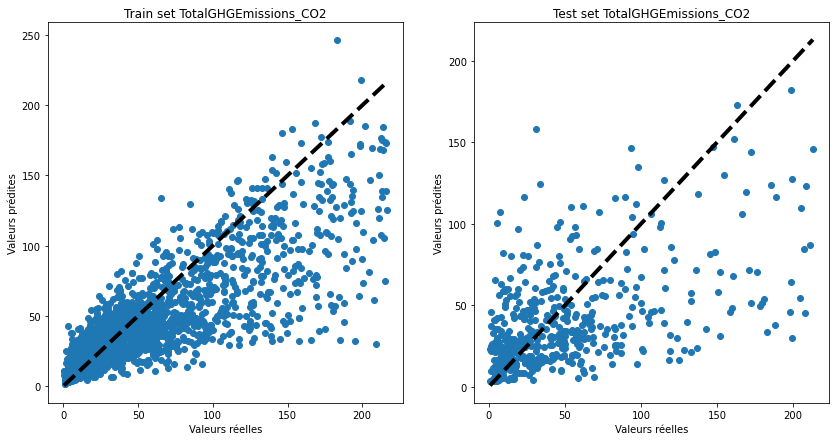

In [335]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_hyp4_tr_fi[df_results_error_target2_hyp4_tr_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target2_hyp4_tr_fi[df_results_error_target2_hyp4_tr_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

test_values = df_results_error_target2_hyp4_te_fi[df_results_error_target2_hyp4_te_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target2_hyp4_te_fi[df_results_error_target2_hyp4_te_fi['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target2)

### 6.2 Ajout des variables relevés en encodage binaire

In [388]:
# Liste des hyper-paramètres à régler par modèle
model_hyper_params_rel_tg1 = {
                      
                      
                      
                      'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(), 
                                                           'model_txt' : 'GradientBoostingRegressor'},
                                             'hyperparam_grid': {'learning_rate': [0.2, 0.4, 0.7],
                                                                 'max_depth'    : [4, 6, 8, 10],
                                                                 'loss' : ['ls','lad','huber']}}
                    
                        
                     }

# Liste des hyper-paramètres à régler par modèle
model_hyper_params_rel_tg2= {
                      
                      
                      
                       'RandomForestReg'   : {'regressor': {'model' : RandomForestRegressor(), 
                                                           'model_txt' : 'RandomForestRegressor'},
                                             'hyperparam_grid': {'bootstrap' : [True], 
                                                                 'max_depth' : [4, 6, 8, 10], 
                                                                 'max_features' : ['log2', 'sqrt', 'auto'], 
                                                                 'n_estimators' : [500]}}
                    
                        
                     }

#### 6.2.1 Variables "SiteEnergyUse(kBtu)" et "TotalGHGEmissions_CO2" - Préparation des données

In [395]:
# Variables en entrée
X_target1_energystar_hyp4 = X_std_noout_target1[['EnergyStar']]

# Jeu de données en entrée
X_target1_hyp4 = X_std_noout_target1.drop(columns=['EnergyStar'])

In [394]:
# Variables en entrée
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'Distance_harversine','PropertyGFATotal', 'NumberofBuildings', 
               'NumberofFloors','Electricity', 'NaturalGas', 'SteamUse']

# Jeu de données en entrée
X_target2_hyp3 = X_std_noout_target2[liste_col_X]

In [383]:
X_target1_hyp4 

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Other,x1_Large Office,x1_Low-Rise Multifamily,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Small- and Mid-Sized Office,x1_Warehouse,x2_Hotel,x2_Multifamily Housing,x2_Non-Refrigerated Warehouse,x2_Office,x2_Other,x2_Retail Store,Distance_harversine,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity,NaturalGas,SteamUse
0,-0.276391,0.164762,-0.253304,0.252413,1.978927,-0.153221,-0.306671,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.579088,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,-1.146547,-0.071133,0.007543,-0.203785,0.0,0.799701,6.334712
1,0.055793,-0.480173,-0.253304,-0.724330,-1.222779,-0.118290,-0.306671,-0.153175,1.366576,-0.48923,-0.827412,-0.172294,-0.150782,1.397434,-0.481035,-0.198369,-0.579088,-0.332110,-0.259011,-0.131585,0.902917,-0.2688,-0.386989,-0.509859,-0.170145,0.745851,-0.071133,0.007543,-0.133729,0.0,-1.250467,-0.157860
3,1.155842,-0.480173,-0.253304,-0.724330,1.799392,0.340777,1.261566,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.579088,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-1.243625,-0.071133,0.610764,0.729807,0.0,0.799701,-0.157860
5,0.128454,0.872099,-0.253304,0.252413,-1.252701,-0.192636,0.988698,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,-0.579088,3.011052,-0.259011,-0.131585,-1.107522,-0.2688,2.584054,-0.509859,-0.170145,-0.057647,-0.071133,-0.294068,0.323178,0.0,0.799701,-0.157860
7,0.408724,-0.480173,-0.253304,-0.724330,0.333190,-0.354330,-0.306671,-0.153175,-0.731756,-0.48923,1.208588,-0.172294,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.882821,-0.071133,-0.897288,0.143321,0.0,0.799701,-0.157860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,-0.750114,-0.480173,-0.253304,-0.724330,-0.444794,-0.535763,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,0.829678,-0.071133,-0.897288,-0.766365,0.0,0.799701,-0.157860
3255,-0.803908,-0.480173,-0.253304,-0.724330,-1.103089,-0.544185,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.989950,-0.071133,-0.897288,-0.808593,0.0,0.799701,-0.157860
3256,-1.004166,-0.128115,-0.253304,1.229156,-0.205414,-0.554775,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,-0.198369,1.726852,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,-0.285788,-0.071133,-0.897288,-0.861691,0.0,0.799701,-0.157860
3257,-1.027530,-0.069565,-0.125345,3.182643,-0.654252,-0.551259,-0.306671,-0.153175,-0.731756,-0.48923,-0.827412,5.804029,-0.150782,-0.715598,-0.481035,5.041115,-0.579088,-0.332110,-0.259011,-0.131585,-1.107522,-0.2688,-0.386989,1.961326,-0.170145,1.030151,-0.071133,-0.897288,-0.844060,0.0,0.799701,-0.157860


In [396]:
X_target2_hyp3

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,Distance_harversine,PropertyGFATotal,NumberofBuildings,NumberofFloors,Electricity,NaturalGas,SteamUse
0,-0.293171,0.037121,-0.253480,0.233796,2.019592,-0.155762,-0.291236,-1.135438,-0.242580,-0.070823,-0.038325,0.0,0.814859,7.201010
1,-0.048613,-0.429837,-0.253480,-0.738515,-1.204849,-0.140004,-0.291236,0.765027,-0.192894,-0.070823,-0.038325,0.0,-1.227206,-0.138869
2,0.983831,-0.429837,-0.253480,-0.738515,-0.662420,0.107614,-0.291236,-1.143026,0.587879,-0.070823,-0.038325,0.0,-1.227206,-0.138869
3,0.761256,-0.429837,-0.253480,-0.738515,1.838782,0.067088,0.798229,-1.232929,0.419559,-0.070823,0.492202,0.0,0.814859,-0.138869
4,1.467184,1.744163,2.259751,3.150731,0.603249,0.296058,1.299837,-0.818603,1.683488,-0.070823,-0.038325,0.0,-1.227206,-0.138869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,-0.819771,-0.076520,0.597093,2.178419,-0.782959,-0.325326,-0.291236,-0.720116,-0.617886,-0.070823,-0.834115,0.0,0.814859,-0.138869
3254,-0.641931,-0.429837,-0.253480,-0.738515,-0.421340,-0.328332,-0.291236,0.849211,-0.641583,-0.070823,-0.834115,0.0,0.814859,-0.138869
3255,-0.681535,-0.429837,-0.253480,-0.738515,-1.084309,-0.332131,-0.291236,-0.978173,-0.671533,-0.070823,-0.834115,0.0,0.814859,-0.138869
3257,-0.846168,-0.132540,-0.144542,3.150731,-0.632285,-0.335323,-0.291236,1.050538,-0.696688,-0.070823,-0.834115,0.0,0.814859,-0.138869


In [397]:
# Variable à prédire - variable "SiteEnergyUse(kBtu)"
y_target1_hyp4 = y_noout_target1[['log_SiteEnergyUse(kBtu)']]
y_target1_hyp4

,log_SiteEnergyUse(kBtu)
0,14.898447
1,14.008238
3,15.691288
5,15.314463
7,14.270135
...,...
3254,13.745177
3255,13.764509
3256,15.567472
3257,13.486273


In [398]:
# Variable à prédire - variable "TotalGHGEmissions_CO2"
y_target2_hyp3 = y_noout_target2[['log_TotalGHGEmissions_CO2']]
y_target2_hyp3

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3253,4.124065
3254,3.060115
3255,3.501646
3257,3.140265


In [387]:
# Séparation du jeu de données - entraînement / test - variable "SiteEnergyUse(kBtu)" - hypothèse 4
X_train_target1_hyp4_rel, X_test_target1_hyp4_rel, y_train_target1_hyp4_rel, y_test_target1_hyp4_rel = train_test_split(X_target1_hyp4,
                                                                                    y_target1_hyp4,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target1_hyp4_rel.shape))
print('Dimension jeu de données y_train:' + str(y_train_target1_hyp4_rel.shape))
print('Dimension jeu de données X_test:' + str(X_test_target1_hyp4_rel.shape))
print('Dimension jeu de données y_test:' + str(y_test_target1_hyp4_rel.shape))

Dimension jeu de données X_train:(2303, 32)
Dimension jeu de données y_train:(2303, 1)
Dimension jeu de données X_test:(576, 32)
Dimension jeu de données y_test:(576, 1)


In [399]:
# Séparation du jeu de données - entraînement / test - variable "TotalGHGEmissions_CO2" - hypothèse 4
X_train_target2_hyp3_rel, X_test_target2_hyp3_rel, y_train_target2_hyp3_rel, y_test_target2_hyp3_rel = train_test_split(X_target2_hyp3,
                                                                                    y_target2_hyp3,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2_hyp3_rel.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2_hyp3_rel.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2_hyp3_rel.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2_hyp3_rel.shape))

Dimension jeu de données X_train:(2325, 14)
Dimension jeu de données y_train:(2325, 1)
Dimension jeu de données X_test:(582, 14)
Dimension jeu de données y_test:(582, 1)


In [401]:
# Hypothèse testée
id_hyp = '4_REL1'

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "SiteEnergyUse(kBtu)"
fic_gbr1 = ds_rep + 'GradientBoostingRegressor_SiteEnergyUse(kBtu)' + '_hyph' + id_hyp + '_' + 'optim_params.pkl'

In [402]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "SiteEnergyUse(kBtu)"
hyper_params_target1 = {
                        'GradientBoostReg'   : {'regressor': {'model' : GradientBoostingRegressor(),
                                                             'model_txt' : 'GradientBoostingRegressor',
                                                             'fic_hyperparam' :  fic_gbr1}}}

In [424]:
# Hypothèse testée
id_hyp = '3_REL1'

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "Total_GHGEmissions_CO2"
fic_rfr2 = ds_rep + 'RandomForestRegressor_TotalGHGEmissions_CO2' + '_hyph' + id_hyp + '_' + 'optim_params.pkl'

In [425]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "TotalGHGemissions_CO2"
hyper_params_target2 = {
                        'RandomBoostReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr2}}}

#### 6.2.2 Variable "SiteEnergyUse(kBtu)" - Réglage hyper-paramètres et entraînement modèles

In [403]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_energie_hyp4_rel = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params_rel_tg1:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params_rel_tg1[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target1_hyp4_rel, X_test_target1_hyp4_rel, y_train_target1_hyp4_rel,y_test_target1_hyp4_rel,
               model_hyper_params_rel_tg1[model_hyper_param]['regressor']['model'], 
               model_hyper_params_rel_tg1[model_hyper_param]['hyperparam_grid'],
               model_hyper_params_rel_tg1[model_hyper_param]['regressor']['model_txt'],
               'N', target1, id_hyp, 10)
    
    df_optim_hyperparam_energie_hyp4_rel = pd.concat([df_optim_hyperparam_energie_hyp4_rel, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle GradientBoostingRegressor ------
Optimisation des hyper-paramètres pour la variable cible SiteEnergyUse(kBtu)
---------------------------------------------------------------------------------

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Optimal hyperparameter combination:  {'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}
Best score (RMSE):  0.5034111535033421



In [404]:
df_optim_hyperparam_energie_hyp4_rel

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,GradientBoostingRegressor,SiteEnergyUse(kBtu),10,"{'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}"


#### 6.2.3 Variable "SiteEnergyUse(kBtu)" - Prédictions 

In [405]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target1_hyp4_tr_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target1_hyp4_te_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target1_hyp4_tr_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target1_hyp4_te_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target1:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target1_hyp4_rel, y_train_target1_hyp4_rel, X_test_target1_hyp4_rel, y_test_target1_hyp4_rel, 
                  hyper_params_target1[model_hyper_param]['regressor']['model'],
                  hyper_params_target1[model_hyper_param]['regressor']['model_txt'],
                  id_hyp, hyper_params_target1[model_hyper_param]['regressor']['fic_hyperparam'],target1, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target1_hyp4_tr_rel = pd.concat([df_results_error_target1_hyp4_tr_rel, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target1_hyp4_te_rel = pd.concat([df_results_error_target1_hyp4_te_rel, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target1_hyp4_tr_rel = pd.concat([df_results_perf_target1_hyp4_tr_rel, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target1_hyp4_te_rel = pd.concat([df_results_perf_target1_hyp4_te_rel, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: GradientBoostingRegressor
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/GradientBoostingRegressor_SiteEnergyUse(kBtu)_hyph4_REL1_optim_params.pkl
Hyper-paramètres optimisés: {'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4}
Prédictions avec les paramètres suivants du modèle:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'lad', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

--------------------

In [406]:
df_results_error_target1_hyp4_tr_rel

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,8.910500e+05,9.187268e+05,27676.846172,3.11
1,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,7.455733e+05,8.976912e+05,152117.851276,20.40
2,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,8.158118e+05,1.049328e+06,233516.477373,28.62
3,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,1.863655e+06,2.403068e+06,539412.631827,28.94
4,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,8.343965e+06,8.352902e+06,8937.373561,0.11
...,...,...,...,...,...,...,...,...
2298,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,9.665941e+05,1.187547e+06,220953.135225,22.86
2299,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,7.337605e+06,7.902350e+06,564744.186563,7.70
2300,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,2.486200e+06,2.492873e+06,6673.108753,0.27
2301,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,6.893738e+05,6.383551e+05,51018.694727,7.40


In [407]:
df_results_error_target1_hyp4_te_rel

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,5.101595e+05,6.799610e+05,1.698014e+05,33.28
1,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,7.580913e+06,3.813944e+06,3.766969e+06,49.69
2,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,1.038352e+06,1.120609e+06,8.225685e+04,7.92
3,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,5.176479e+06,4.857912e+06,3.185677e+05,6.15
4,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,1.338297e+06,1.401153e+06,6.285550e+04,4.70
...,...,...,...,...,...,...,...,...
571,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,2.043542e+06,2.928036e+06,8.844940e+05,43.28
572,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,1.132262e+05,6.995183e+05,5.862921e+05,517.81
573,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,1.101156e+06,9.300407e+05,1.711156e+05,15.54
574,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,1.652457e+06,2.240493e+06,5.880362e+05,35.59


In [408]:
df_results_perf_target1_hyp4_tr_rel

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Train,0.71,1129065.06,0.34


In [409]:
df_results_perf_target1_hyp4_te_rel

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,GradientBoostingRegressor,4_REL1,SiteEnergyUse(kBtu),Test,0.59,1157556.03,0.49


In [416]:
# Valeur max cible test
np.expm1(y_test_target1_hyp4_rel.max())

log_SiteEnergyUse(kBtu)    9102583.0
dtype: float64

In [417]:
# Valeur moyenne cible test
df_results_error_target1_hyp4_te_rel[df_results_error_target1_hyp4_te_rel['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    2.156596e+06
dtype: float64

In [418]:
# Valeur max cible train
np.expm1(y_train_target1_hyp4_rel.max())

log_SiteEnergyUse(kBtu)    9215900.5
dtype: float64

In [419]:
# Valeur moyenne cible test
df_results_error_target1_hyp4_tr_rel[df_results_error_target1_hyp4_tr_rel['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']].mean()

y    2.301181e+06
dtype: float64

#### 6.2.4 Variable "SiteEnergyUse(kBtu)" - Affichage métriques et choix du modèle

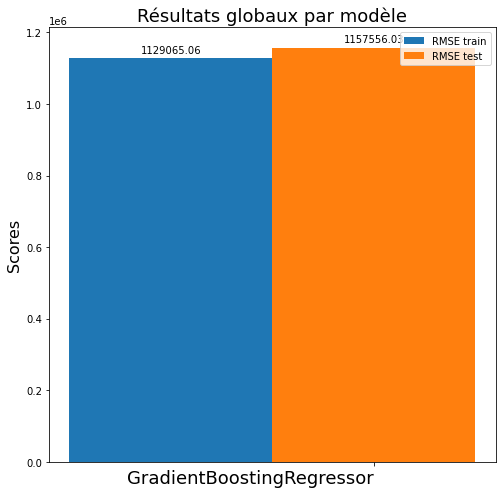

In [673]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model_2(df_results_perf_target1_hyp4_tr_rel, df_results_perf_target1_hyp4_te_rel, 'RMSE')

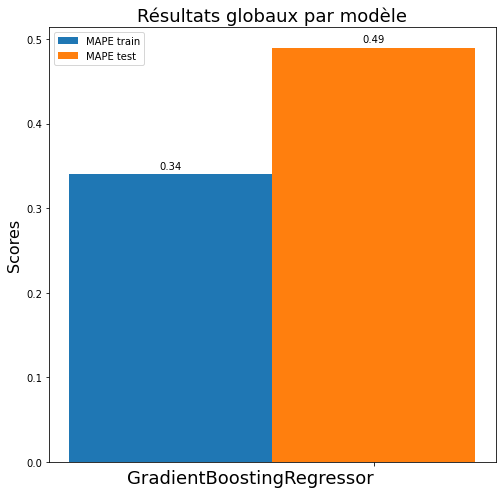

In [674]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model_2(df_results_perf_target1_hyp4_tr_rel, df_results_perf_target1_hyp4_te_rel, 'MAPE')

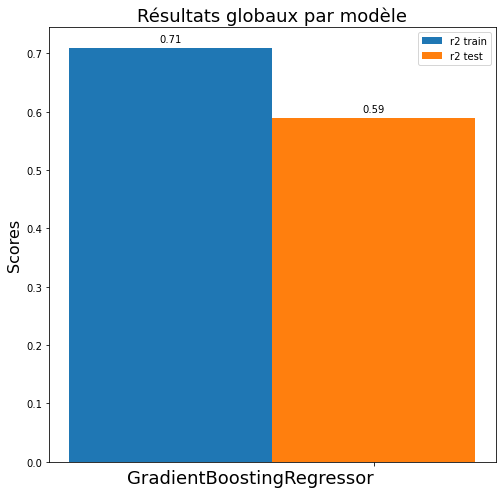

In [675]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model_2(df_results_perf_target1_hyp4_tr_rel, df_results_perf_target1_hyp4_te_rel, 'r2')

**La prise en compte des 3 variables relevés sous forme binaire (utilisation ou non du type d'énergie dans le bâtiment), soit 32 variables en entrée en tout permet d'améliorer la  RMSE par rapport au modèle Gradient Boosting Regressor de l'hypothèse 4**

Sur la métrique de la RMSE, le modèle RFR propose un RMSE de (1157556).
Et, sur la MAPE, le modèle GBR donne un taux d'erreur moyen sur le jeu de test de 49 % (MAPE).

Enfin, le GBR obtient un R² de 0,59.

**Donc, le Gradient Boosting Regressor avec les données de l'amélioration REL1 sur l'hypothèse 4 reste le meilleur modèle sur la variable "SiteEnergyUse(kBtu)", compte tenu de la métrique RMSE.**


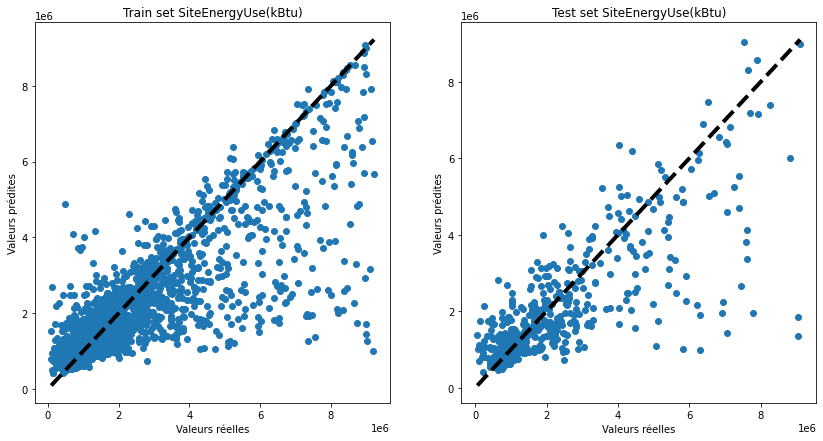

In [423]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target1_hyp4_tr_rel[df_results_error_target1_hyp4_tr_rel['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

train_pred_values = df_results_error_target1_hyp4_tr_rel[df_results_error_target1_hyp4_tr_rel['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

test_values = df_results_error_target1_hyp4_te_rel[df_results_error_target1_hyp4_te_rel['Modeles'] ==
                                                'GradientBoostingRegressor'][['y']]

test_pred_values = df_results_error_target1_hyp4_te_rel[df_results_error_target1_hyp4_te_rel['Modeles'] ==
                                                'GradientBoostingRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target1)

#### 6.2.5 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [426]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_hyp3_rel = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params_rel_tg2:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params_rel_tg2[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2_hyp3_rel, X_test_target2_hyp3_rel, y_train_target2_hyp3_rel,y_test_target2_hyp3_rel,
               model_hyper_params_rel_tg2[model_hyper_param]['regressor']['model'], 
               model_hyper_params_rel_tg2[model_hyper_param]['hyperparam_grid'],
               model_hyper_params_rel_tg2[model_hyper_param]['regressor']['model_txt'],
               'N', target2, id_hyp, 10)
    
    df_optim_hyperparam_co2_hyp3_rel = pd.concat([df_optim_hyperparam_co2_hyp3_rel, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle RandomForestRegressor ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Optimal hyperparameter combination:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
Best score (RMSE):  0.6106702009935348



In [427]:
df_optim_hyperparam_co2_hyp3_rel

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,RandomForestRegressor,TotalGHGEmissions_CO2,10,"{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}"


#### 6.2.6 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [428]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_hyp3_tr_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_hyp3_te_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_hyp3_tr_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_hyp3_te_rel = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target2_hyp3_rel, y_train_target2_hyp3_rel, X_test_target2_hyp3_rel, y_test_target2_hyp3_rel, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  id_hyp, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_hyp3_tr_rel = pd.concat([df_results_error_target2_hyp3_tr_rel, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_hyp3_te_rel = pd.concat([df_results_error_target2_hyp3_te_rel, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_hyp3_tr_rel = pd.concat([df_results_perf_target2_hyp3_tr_rel, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_hyp3_te_rel = pd.concat([df_results_perf_target2_hyp3_te_rel, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: RandomForestRegressor
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/RandomForestRegressor_TotalGHGEmissions_CO2_hyph3_REL1_optim_params.pkl
Hyper-paramètres optimisés: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
Prédictions avec les paramètres suivants du modèle:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

--------------------------------------------------------------------------------

In [429]:
df_results_error_target2_hyp3_tr_rel

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,70.350,58.817532,11.532468,16.39
1,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,199.345,44.723554,154.621446,77.56
2,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,61.495,53.717079,7.777921,12.65
3,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,34.065,37.053144,2.988144,8.77
4,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,14.275,15.362702,1.087702,7.62
...,...,...,...,...,...,...,...,...
2320,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,107.875,60.349253,47.525747,44.06
2321,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,16.590,18.798124,2.208124,13.31
2322,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,0.705,3.260865,2.555865,362.53
2323,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,29.110,55.304500,26.194500,89.98


In [444]:
df_results_error_target2_hyp3_te_rel

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,5.550,6.577993,1.027993,18.52
1,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,13.605,21.154190,7.549190,55.49
2,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,60.410,60.444587,0.034587,0.06
3,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,34.265,43.583155,9.318155,27.19
4,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,37.895,21.684812,16.210188,42.78
...,...,...,...,...,...,...,...,...
577,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,2.180,6.248416,4.068416,186.62
578,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,74.680,45.109399,29.570601,39.60
579,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,97.140,35.286780,61.853220,63.67
580,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,92.220,80.976325,11.243675,12.19


In [431]:
df_results_perf_target2_hyp3_tr_rel

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Train,0.84,27.32,0.42


In [432]:
df_results_perf_target2_hyp3_te_rel

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,RandomForestRegressor,3_REL1,TotalGHGEmissions_CO2,Test,0.68,36.72,0.65


In [433]:
# Valeur max cible test
np.expm1(y_test_target2_hyp3_rel.max())

log_TotalGHGEmissions_CO2    212.195
dtype: float64

In [435]:
# Valeur moyenne cible test
df_results_error_target2_hyp3_te_rel[df_results_error_target2_hyp3_te_rel['Modeles'] ==
                                                'RandomForestRegressor'][['y']].mean()

y    45.501624
dtype: float64

In [436]:
# Valeur max cible train
np.expm1(y_train_target2_hyp3_rel.max())

log_TotalGHGEmissions_CO2    216.39
dtype: float64

In [438]:
# Valeur moyenne cible test
df_results_error_target2_hyp3_tr_rel[df_results_error_target2_hyp3_tr_rel['Modeles'] ==
                                                'RandomForestRegressor'][['y']].mean()

y    45.746527
dtype: float64

#### 6.2.7 Variable "TotalGHGEmissions_CO2" - Affichage métriques et choix du modèle

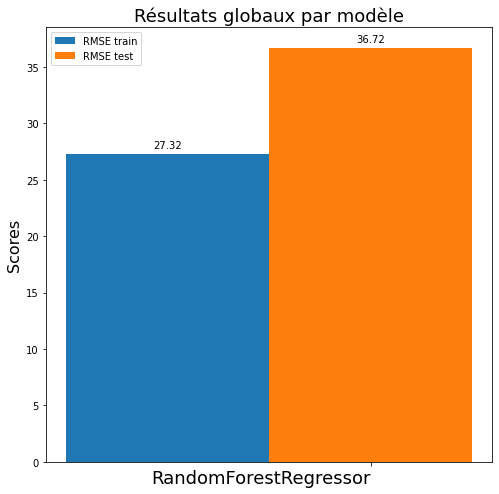

In [676]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model_2(df_results_perf_target2_hyp3_tr_rel, df_results_perf_target2_hyp3_te_rel, 'RMSE')

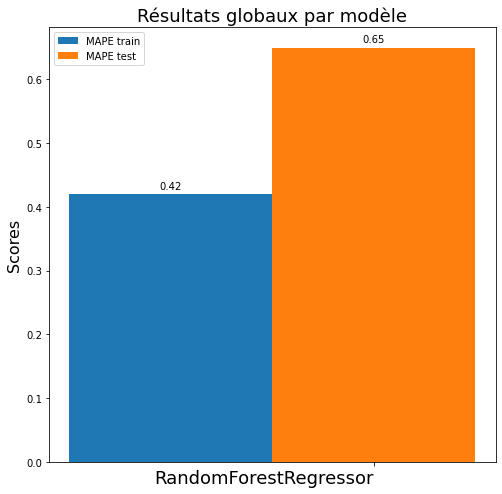

In [677]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model_2(df_results_perf_target2_hyp3_tr_rel, df_results_perf_target2_hyp3_te_rel, 'MAPE')

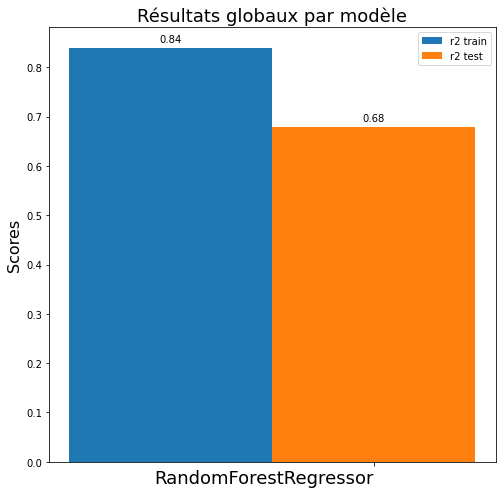

In [678]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model_2(df_results_perf_target2_hyp3_tr_rel, df_results_perf_target2_hyp3_te_rel, 'r2')

**La prise en compte des 3 variables relevés sous forme binaire (utilisation ou non du type d'énergie dans le bâtiment), soit 14 variables en entrée en tout permet d'améliorer la  RMSE par rapport au modèle Random Forest  Regressor de l'hypothèse 3**

Sur la métrique de la RMSE, le modèle RFR propose un RMSE de (36,72).
Et, sur la MAPE, le modèle GBR donne un taux d'erreur moyen sur le jeu de test de 65% (MAPE).

Enfin, le GBR obtient un R² de 0,68.

**Donc, le Random Forest Regressor avec les données de l'amélioration REL1 sur l'hypothèse 3 est le meilleur modèle sur la variable "TotalGHGEmissions_CO2", compte tenu de la métrique RMSE.**


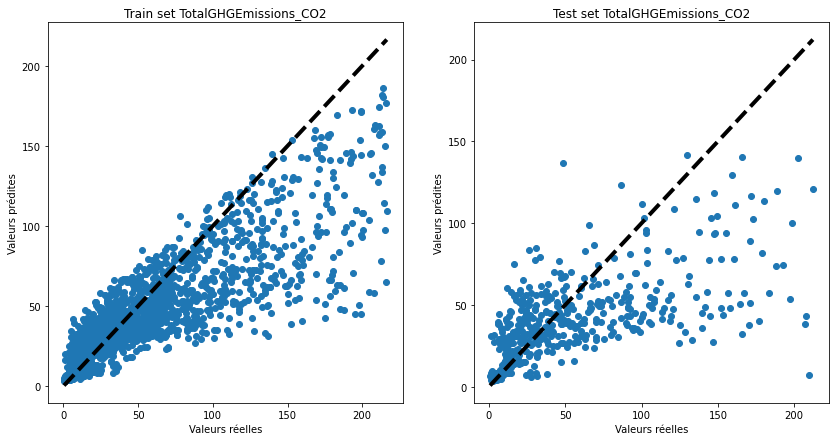

In [446]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_hyp3_tr_rel[df_results_error_target2_hyp3_tr_rel['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

train_pred_values = df_results_error_target2_hyp3_tr_rel[df_results_error_target2_hyp3_tr_rel['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

test_values = df_results_error_target2_hyp3_te_rel[df_results_error_target2_hyp3_te_rel['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

test_pred_values = df_results_error_target2_hyp3_te_rel[df_results_error_target2_hyp3_te_rel['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target2)

### 6.3 Conclusion sur les modèles finaux

Compte tenu des **améliorations (ajout de 3 variables pour indiquer l'utilisation ou non des différents types d'énergie dans un bâtiment)** sur le modèle avec l'estimateur Gradient Boosting Regressor de l'hypothèse 4 pour la variable cible "SiteEnergyUse(kBtu)" et sur le modèle avec l'estimateur Random Forest Regressor de l'hypothèse 3 pour la variable "TotalGHGEMissions_CO2", nous obtenons les meilleurs modèles:

**- modèle Gradient Boosting Regressor avec 32 variables en entrée pour la variable cible "SiteEnergyUse(kBtu)": RMSE = 1 157 556, MAPE = 49% taux d'erreur moyen, R² = 0,59.**

La variance du modèle final correspond à 53% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité moyenne des prédictions.

**- modèle Random Forest Regressor avec 14 variables en entrée pour la variable cible "TotalGHGEMissions_CO2": RMSE = 36,72 , MAPE = 65% taux d'erreur moyen, R² = 0,68.**

La variance du modèle final correspond à 80% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité médiocre des prédictions.


## 7 Impact du score EnergyStar sur les predictions d'émissions de CO²

### 7.1 Variable "TotalGHGEmissions_CO2" - Préparation des données

In [525]:
# Variables en entrée
liste_col_X = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'TotalUseTypesCount', 'AgeOfBuilding', 'AreaBuildingsMean',
               'AreaParkingMean', 'Distance_harversine','PropertyGFATotal', 'NumberofBuildings', 
               'NumberofFloors','Electricity', 'NaturalGas', 'SteamUse','EnergyStar']

# Jeu de données en entrée
X_target2_energystar = X_std_noout_target2[liste_col_X]

In [526]:
X_target2_energystar

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,TotalUseTypesCount,AgeOfBuilding,AreaBuildingsMean,AreaParkingMean,Distance_harversine,PropertyGFATotal,NumberofBuildings,NumberofFloors,Electricity,NaturalGas,SteamUse,EnergyStar
0,-0.293171,0.037121,-0.253480,0.233796,2.019592,-0.155762,-0.291236,-1.135438,-0.242580,-0.070823,-0.038325,0.0,0.814859,7.201010,0.293530
1,-0.048613,-0.429837,-0.253480,-0.738515,-1.204849,-0.140004,-0.291236,0.765027,-0.192894,-0.070823,-0.038325,0.0,-1.227206,-0.138869,0.731047
2,0.983831,-0.429837,-0.253480,-0.738515,-0.662420,0.107614,-0.291236,-1.143026,0.587879,-0.070823,-0.038325,0.0,-1.227206,-0.138869,0.993558
3,0.761256,-0.429837,-0.253480,-0.738515,1.838782,0.067088,0.798229,-1.232929,0.419559,-0.070823,0.492202,0.0,0.814859,-0.138869,-1.019024
4,1.467184,1.744163,2.259751,3.150731,0.603249,0.296058,1.299837,-0.818603,1.683488,-0.070823,-0.038325,0.0,-1.227206,-0.138869,-0.406499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,-0.819771,-0.076520,0.597093,2.178419,-0.782959,-0.325326,-0.291236,-0.720116,-0.617886,-0.070823,-0.834115,0.0,0.814859,-0.138869,-0.012733
3254,-0.641931,-0.429837,-0.253480,-0.738515,-0.421340,-0.328332,-0.291236,0.849211,-0.641583,-0.070823,-0.834115,0.0,0.814859,-0.138869,-0.012733
3255,-0.681535,-0.429837,-0.253480,-0.738515,-1.084309,-0.332131,-0.291236,-0.978173,-0.671533,-0.070823,-0.834115,0.0,0.814859,-0.138869,-0.012733
3257,-0.846168,-0.132540,-0.144542,3.150731,-0.632285,-0.335323,-0.291236,1.050538,-0.696688,-0.070823,-0.834115,0.0,0.814859,-0.138869,-0.012733


In [527]:
# Variable à prédire - variable "TotalGHGEmissions_CO2"
y_target2_energystar = y_noout_target2[['log_TotalGHGEmissions_CO2']]
y_target2_energystar

,log_TotalGHGEmissions_CO2
0,4.727919
1,2.246015
2,4.248638
3,3.876189
4,4.769328
...,...
3253,4.124065
3254,3.060115
3255,3.501646
3257,3.140265


In [529]:
# Séparation du jeu de données - entraînement / test - variable "TotalGHGEmissions_CO2" - hypothèse 4
X_train_target2_es, X_test_target2_es, y_train_target2_es, y_test_target2_es = train_test_split(X_target2_energystar,
                                                                                    y_target2_energystar,
                                                                                    test_size=0.2,
                                                                                    shuffle=True)
print('Dimension jeu de données X_train:' + str(X_train_target2_es.shape))
print('Dimension jeu de données y_train:' + str(y_train_target2_es.shape))
print('Dimension jeu de données X_test:' + str(X_test_target2_es.shape))
print('Dimension jeu de données y_test:' + str(y_test_target2_es.shape))

Dimension jeu de données X_train:(2325, 15)
Dimension jeu de données y_train:(2325, 1)
Dimension jeu de données X_test:(582, 15)
Dimension jeu de données y_test:(582, 1)


In [532]:
# Hypothèse testée
id_hyp = '3_REL1_ES'

# Liste des fichers pickle des meilleurs hyper-paramètres par modèle

# Variable cible "Total_GHGEmissions_CO2"
fic_rfr2 = ds_rep + 'RandomForestRegressor_TotalGHGEmissions_CO2' + '_hyph' + id_hyp + '_' + 'optim_params.pkl'

In [533]:
# ATTENTION: cellule à relancer chaque nouvelle hypothèse de pre-processing

# Liste des hyper-paramètres à régler par modèle - variable cible "TotalGHGemissions_CO2"
hyper_params_target2 = {
                        'RandomBoostReg'   : {'regressor': {'model' : RandomForestRegressor(),
                                                             'model_txt' : 'RandomForestRegressor',
                                                             'fic_hyperparam' :  fic_rfr2}}}

### 7.2 Variable "TotalGHGEmissions_CO2" - Réglage hyper-paramètres et entraînement modèles

In [534]:
# Création du tableau de synthèse des hyper-paramètres
df_optim_hyperparam_co2_es = pd.DataFrame(columns=["Modele",  "Target", "Nombre Pli",
                                                         "Liste hyper-paramètres"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in model_hyper_params_rel_tg2:
   
    print('------ Optimisation hyper-paramètres du modèle ' + 
          model_hyper_params_rel_tg2[model_hyper_param]['regressor']['model_txt'] + ' ------')

    df_tab_hyperparam = optim_hyperparam_model(X_train_target2_es, X_test_target2_es, y_train_target2_es,y_test_target2_es,
               model_hyper_params_rel_tg2[model_hyper_param]['regressor']['model'], 
               model_hyper_params_rel_tg2[model_hyper_param]['hyperparam_grid'],
               model_hyper_params_rel_tg2[model_hyper_param]['regressor']['model_txt'],
               'N', target2, id_hyp, 10)
    
    df_optim_hyperparam_co2_es = pd.concat([df_optim_hyperparam_co2_es, df_tab_hyperparam],
                                                 ignore_index=True)
    print('')

------ Optimisation hyper-paramètres du modèle RandomForestRegressor ------
Optimisation des hyper-paramètres pour la variable cible TotalGHGEmissions_CO2
---------------------------------------------------------------------------------

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Optimal hyperparameter combination:  {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best score (RMSE):  0.5994513919888111



In [535]:
df_optim_hyperparam_co2_es

,Modele,Target,Nombre Pli,Liste hyper-paramètres
0,RandomForestRegressor,TotalGHGEmissions_CO2,10,"{'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}"


### 7.3 Variable "TotalGHGEmissions_CO2" - Prédictions 

In [537]:
# Création du tableau de synthèse des erreurs de prédiction - train
df_results_error_target2_tr_es = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])

# Création du tableau de synthèse des erreurs de prédiction - test
df_results_error_target2_te_es = pd.DataFrame(columns=["Modeles", "Hypothese_id", "Target", "Dataset", 
                                             "y", "y_pred", "abs(y-y_pred)", "%error"])
    
# Création du tableau de synthèse des indicateurs de performance du modèle - train
df_results_perf_target2_tr_es = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Création du tableau de synthèse des indicateurs de performance du modèle - test
df_results_perf_target2_te_es = pd.DataFrame(columns=["Modeles", "Hypothese_id",  "Target", "Dataset",
                                            "r2", "RMSE", "MAPE"])

# Boucle pour le réglage des hyper-paramètres des différents modèles
for model_hyper_param in hyper_params_target2:

    (df_results_error_tr, 
     df_results_error_te,
     df_results_perf_tr,
     df_results_perf_te) = predict_model(X_train_target2_es, y_train_target2_es, X_test_target2_es, y_test_target2_es, 
                  hyper_params_target2[model_hyper_param]['regressor']['model'],
                  hyper_params_target2[model_hyper_param]['regressor']['model_txt'],
                  id_hyp, hyper_params_target2[model_hyper_param]['regressor']['fic_hyperparam'],target2, 'O')
    
    # Concaténation des résultats pour le tableau de synthèse des erreurs de prédictions
    df_results_error_target2_tr_es = pd.concat([df_results_error_target2_tr_es, df_results_error_tr],
                                                 ignore_index=True)
    df_results_error_target2_te_es = pd.concat([df_results_error_target2_te_es, df_results_error_te],
                                                 ignore_index=True)
    
    # Concaténation des résultats pour le tableau de synthèse des performances (métriques)
    df_results_perf_target2_tr_es = pd.concat([df_results_perf_target2_tr_es, df_results_perf_tr],
                                                 ignore_index=True)
    df_results_perf_target2_te_es = pd.concat([df_results_perf_target2_te_es, df_results_perf_te],
                                                 ignore_index=True)
    
    print('')
    

-----------------------------------------------------------------------------
Entraînement du modèle sur les hyper-paramètres optimisés: RandomForestRegressor
-----------------------------------------------------------------------------
Chargement du fichier des hyper-paramètres: ./input/RandomForestRegressor_TotalGHGEmissions_CO2_hyph3_REL1_ES_optim_params.pkl
Hyper-paramètres optimisés: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Prédictions avec les paramètres suivants du modèle:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

-------------------------------------------------------------------------------

In [539]:
df_results_error_target2_tr_es

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,3.905,4.425885,0.520885,13.34
1,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,97.715,107.890364,10.175364,10.41
2,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,2.700,4.709453,2.009453,74.42
3,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,6.115,5.700471,0.414529,6.78
4,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,8.870,8.830794,0.039206,0.44
...,...,...,...,...,...,...,...,...
2320,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,3.820,4.724681,0.904681,23.68
2321,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,51.940,34.748256,17.191744,33.10
2322,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,24.430,53.432462,29.002462,118.72
2323,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,6.090,6.422760,0.332760,5.46


In [540]:
df_results_error_target2_te_es

,Modeles,Hypothese_id,Target,Dataset,y,y_pred,abs(y-y_pred),%error
0,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,9.520,9.539846,0.019846,0.21
1,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,49.295,33.421722,15.873278,32.20
2,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,13.230,15.625213,2.395213,18.10
3,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,6.985,7.653946,0.668946,9.58
4,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,3.725,3.989871,0.264871,7.11
...,...,...,...,...,...,...,...,...
577,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,24.645,26.346690,1.701690,6.90
578,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,8.425,8.156172,0.268828,3.19
579,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,0.855,16.565086,15.710086,1837.44
580,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,42.700,27.119711,15.580289,36.49


In [541]:
df_results_perf_target2_tr_es

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Train,0.84,27.37,0.42


In [542]:
df_results_perf_target2_te_es

,Modeles,Hypothese_id,Target,Dataset,r2,RMSE,MAPE
0,RandomForestRegressor,3_REL1_ES,TotalGHGEmissions_CO2,Test,0.73,33.38,0.67


In [543]:
# Valeur max cible test
np.expm1(y_test_target2_es.max())

log_TotalGHGEmissions_CO2    214.19
dtype: float64

In [544]:
# Valeur moyenne cible test
df_results_error_target2_te_es[df_results_error_target2_te_es['Modeles'] ==
                                                'RandomForestRegressor'][['y']].mean()

y    46.403376
dtype: float64

In [545]:
# Valeur max cible train
np.expm1(y_train_target2_es.max())

log_TotalGHGEmissions_CO2    216.39
dtype: float64

In [546]:
# Valeur moyenne cible test
df_results_error_target2_tr_es[df_results_error_target2_tr_es['Modeles'] ==
                                                'RandomForestRegressor'][['y']].mean()

y    45.520798
dtype: float64

### 7.4 Variable "TotalGHGEmissions_CO2" - Affichage métriques et choix du modèle

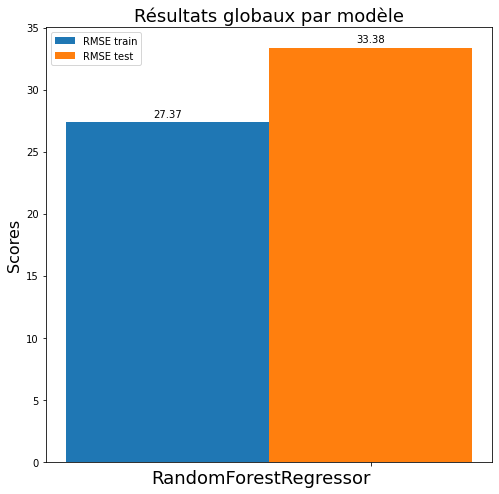

In [665]:
# Affichage de la métrique RMSE (Root Mean Squared Error) par modèle
affic_results_glob_model_2(df_results_perf_target2_tr_es, df_results_perf_target2_te_es, 'RMSE')

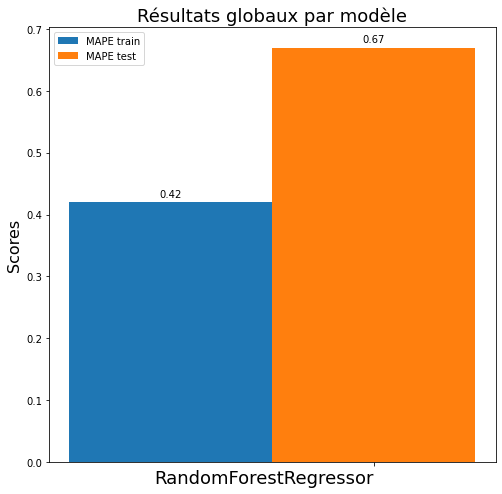

In [664]:
# Affichage de la métrique MAPE (Mean Absolute Percentage Error) par modèle
affic_results_glob_model_2(df_results_perf_target2_tr_es, df_results_perf_target2_te_es, 'MAPE')

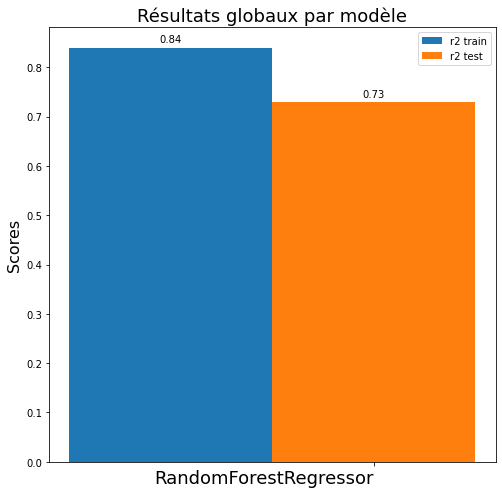

In [666]:
# Affichage de la métrique r2 (coefficient de détermination) par modèle
affic_results_glob_model_2(df_results_perf_target2_tr_es, df_results_perf_target2_te_es, 'r2')

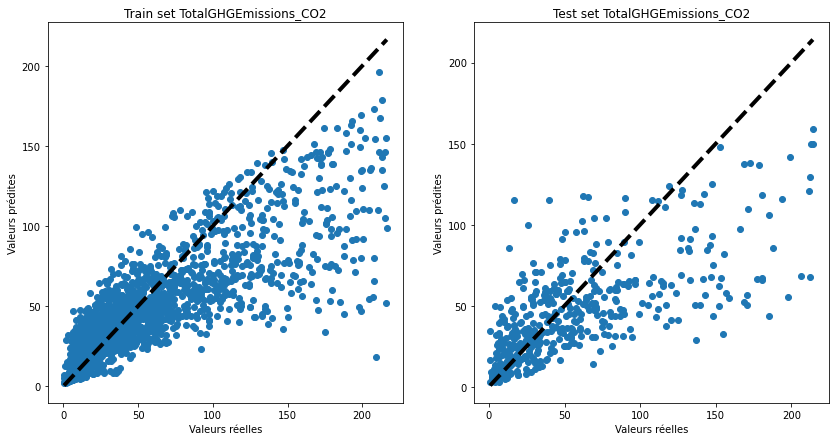

In [550]:
# Affichage des valeurs réelles / prédites sur le meilleur modèle
train_values = df_results_error_target2_tr_es[df_results_error_target2_tr_es['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

train_pred_values = df_results_error_target2_tr_es[df_results_error_target2_tr_es['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

test_values = df_results_error_target2_te_es[df_results_error_target2_te_es['Modeles'] ==
                                                'RandomForestRegressor'][['y']]

test_pred_values = df_results_error_target2_te_es[df_results_error_target2_te_es['Modeles'] ==
                                                'RandomForestRegressor'][['y_pred']]

affic_plot_predict_model(train_values, train_pred_values, test_values, test_pred_values, target2)

### 7.5 Conclusion sur l'impact de l'EnergyStar score sur les émissions de CO²

**Suite à l'ajout de la variable "EnergyStar" dans les variables en entrée sur le modèle Random Forest Regressor avec 14 variables (meilleur modèle final pour la variable "TotalGHGemissions_CO2"), le modèle est supérieur au modèle final pour la RMSE (33,38).**

De plus, le R² es largement supérieur (0,73) avec une MAPE sensiblement équivalente (0,67).

La variance du modèle final correspond à 72% de la moyenne des observations sur le jeu de test (RMSE relative), ce qui correspond plutôt à une qualité médiocre des prédictions.
